In [14]:
library(reshape2)
library(dplyr)
library(igraph)

## Plotting
library(pROC)
library(ggplot2)
theme_set(theme_gray())
library(cowplot)
library(rgl)
library(RColorBrewer)
library(pheatmap)
library(UpSetR)
library(VennDiagram)
library(xtable)
library(Rtsne)
# library(dendextend)
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

library(limma)
library(sva)

## Custom
source("../functions.R")

In [15]:
# FUNCTIONS ---------------------------------------------------------------
plot_mean <- function(df, batch_vec1) {
  # Melt dataframe
  melt_df <- melt(df, variable.name = "ID")
  print(head(melt_df))
  # Trimmed mean probe intensities for each chip
  mean_tibble <- melt_df %>% group_by(ID) %>%
    summarise(mean = mean(value))
  mean_batch_tibble <- cbind(mean_tibble,
                             batch_vec1 = batch_vec1[mean_tibble$ID])
  
  mean_scatter <- ggplot(mean_batch_tibble, aes(x = ID, y = mean)) +
    geom_point(aes(col = factor(batch_vec1)),
               show.legend = F, size = 3) +
    facet_wrap(factor(batch_vec1), scales = "free_x") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())
  return(mean_scatter)
}

# Selecting drug responsive genes between D0 and D8
# using paired t-test and logfc
selectFeatures <- function(df1, metadata_df,
                           alpha = 0.05, logfc_threshold = 1) {
  # Subset df according to D0 and D8
  class_info <- metadata_df[colnames(df1), "class_info"]
  df_d0 <- df1[,class_info == "D0"]
  df_d8 <- df1[,class_info == "D8"]
  print(head(colnames(df_d0)))
  print(head(colnames(df_d8)))
  stopifnot(ncol(df_d0) == ncol(df_d8))
  
  # Identify drug responsive probesets
  ttest_pvalue <- calc_ttest(cbind(df_d0, df_d8), ncol(df_d0), is_paired = T)
  log_fc <- rowMeans(df_d8) - rowMeans(df_d0)
  ttest_probesets <- names(ttest_pvalue)[ttest_pvalue <= alpha]
  fc_probesets <- names(log_fc)[log_fc > logfc_threshold]
  intersect_probesets <- intersect(ttest_probesets, fc_probesets)
  print(paste("T-test:", length(ttest_probesets)))
  print(paste("Log fold change:", length(fc_probesets)))
  print(paste("Intersection:", length(intersect_probesets)))
  return(intersect_probesets)
}

# 3D PCA plot
plotPCA3D <- function(df, colour, pch, pc_labels = NULL,
                      ratio_list = list(2,1,1)) {
  if (is.null(pc_labels)) {
    print("PCA performed!")
    pca_obj <- prcomp(t(df), center = T, scale. = F)
    pca_df <- as.data.frame(pca_obj$x[,1:3])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:3]/sum(eigenvalues)
    print(var_pc)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:3, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- as.data.frame(df)
  }
  
  # RGL plot parameters
  rgl.open()
  rgl.bg(color="white")
  rgl.viewpoint(zoom = 0.8)
  # rgl.viewpoint(theta = 110, phi = 5, zoom = 0.8)
  par3d(windowRect = c(50, 20, 500, 500))
  with(pca_df, pch3d(PC1, PC2, PC3, bg = colour,
                     pch = pch, cex = 0.5, lwd = 1.5))
  box3d(col = "black")
  title3d(xlab = pc_labels[1], ylab = pc_labels[2],
          zlab = pc_labels[3], col = "black")
  # Plot aspect ratios of axis according to variance
  do.call(aspect3d, ratio_list)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  batch_palette <- generate_colour(10)
  # batch_palette <- brewer.pal(10, "Set3")
  batch_colour <- batch_palette[batch_info]
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "class_info"]
  print(levels(class_info))
  levels(class_info) <- 21:23
  timepoint_shape <- as.numeric(as.character(class_info))
  plotPCA3D(df1, batch_colour, timepoint_shape)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh1 <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  batch_factor <- droplevels(as.factor(batch_info))
  print(batch_factor)
  print(levels(batch_factor))
  levels(batch_factor) <- 21:22
  pch <- as.numeric(as.character(batch_factor))
  # generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  # batch_palette <- generate_colour(10)
  
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "subtype"]
  palette <- brewer.pal(10, "Set3")
  col <- palette[class_info]
  
  plotPCA3D(df1, col, pch)
}

plotJitterYeoh <- function(X, metadata_df, n_pc = 10) {
  pca_obj <- prcomp(t(X))
  X_pca <- data.frame(pca_obj$x)
  batch <- as.factor(metadata_df[rownames(X_pca),"batch_info"])
  class <- as.factor(metadata_df[rownames(X_pca),"class_info"])
  X_meta <- cbind(batch, class, X_pca[,1:n_pc])
  X_long <- melt(X_meta, id = c("batch", "class"), variable.name="PC")
  
  ax_batch <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=batch), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=batch), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  ax_class <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=class), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=class), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  fig <- plot_grid(ax_batch, ax_class, nrow = 2)
  return(fig)  
}

plotFeatures <- function(results, metadata_df) {
  y <- as.factor(metadata_df[rownames(results),"label"])
  subset_features1 <- c("erm1", "angle_d0d8_normal", "l2norm_d0_d8",
                        "l2norm_d0_normal", "l2norm_d8_normal", "l2norm_diff",
                        "erm1_ratio1", "erm1_ratio2", "erm1_ratio3",
                        "l2norm_ratio1", "l2norm_ratio2", "l2norm_diff_ratio")
  
  features1 <- results[, subset_features1, drop=F]
  features1_y <- data.frame(features1, label = y)
  long_features1_y <- melt(features1_y, id="label", variable.name = "feature")
  
  # PLOT: FEATURES
  jitter_features1 <- ggplot(long_features1_y) +
    geom_point(aes(feature, value, colour = label),
               position = position_jitterdodge(), cex = 3,
               show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 2, ncol = 6,  scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
  
  return(jitter_features1)
}

# Factor to split data
splitSubtype <- function(X, metadata_df) {
  if (!is(X, "data.frame"))
    X <- data.frame(X)
  
  subtype_factor <- as.factor(metadata_df[colnames(X), "subtype"])
  split.default(X, subtype_factor, drop = F) # Split by subtype
}

## Import data

In [16]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


#### Import D33 samples

In [96]:
## Metadata
METADATA_RPATH1 <- "data/GSE67684/processed/metadata/all_metadata.tsv"
all_metadata <- read.table(METADATA_RPATH1, sep = "\t")

# SCALE->REMOVE->FILTER->LOG
D33_RPATH <- "data/leuk_D33/processed/mas5_filtered.tsv"
raw_d33 <- read.table(D33_RPATH, sep = "\t")
log_d33 <- log2_transform(normaliseMeanScaling(raw_d33))
fltr_d33 <- log_d33[rownames(data),]

## Filter out D33 patients without D0/D8 data
pid_d33 <- substring(colnames(fltr_d33), 1, 4)
pid_d0d8 <- substring(rownames(metadata_df), 1, 4)
rm_d33 <- paste0(pid_d33[!(pid_d33 %in% pid_d0d8)], "_D33")
data_d33 <- fltr_d33[,!(colnames(fltr_d33) %in% rm_d33)]
print(rm_d33)

# Combine D33 with the rest
data_all <- cbind(data, data_d33)

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 
[1] "P006_D33" "P030_D33" "P069_D33" "P074_D33" "P079_D33"


### Commonly used globals

In [17]:
Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

pid_remission <- rownames(Y)[Y$label == 0]

# List subtypes
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))

## Subsetting data

In [18]:
##### SUBSETTING DATA ######
## Normal
idx_normal <- metadata_df[colnames(data), "subtype"] == "Normal"
normal <- data[,idx_normal]

## Hyperdiploid
idx_hyp <- metadata_df[colnames(data), "subtype"] == "Hyperdiploid" &
  metadata_df[colnames(data), "class_info"] == "D0"
hyperdiploid <- data[,idx_hyp]
colnames(hyperdiploid) <- substring(colnames(hyperdiploid), 1, 4)

## Hyperdiploid (D8)
idx_hyp_d8 <- metadata_df[colnames(data), "subtype"] == "Hyperdiploid" &
  metadata_df[colnames(data), "class_info"] == "D8"
hyperdiploid_d8 <- data[,idx_hyp_d8]
colnames(hyperdiploid_d8) <- substring(colnames(hyperdiploid_d8), 1, 4)

# ## TEL-AML1
# idx_telaml1 <- metadata_df[colnames(data), "subtype"] == "TEL-AML1" &
#   metadata_df[colnames(data), "class_info"] == "D0"
# telaml1 <- data[,idx_telaml1]
# colnames(telaml1) <- substring(colnames(telaml1), 1, 4)

# ## MLL
# idx_mll <- metadata_df[colnames(data), "subtype"] == "MLL" &
#   metadata_df[colnames(data), "class_info"] == "D0"
# mll <- data[,idx_mll]
# colnames(mll) <- substring(colnames(mll), 1, 4)

In [25]:
## Hyperdiploid (D33)
idx_hyp_d33 <- all_metadata[colnames(d33), "subtype"] == "Hyperdiploid" &
  metadata1[colnames(d33), "class_info"] == "D33"
## Patients in data are not in metadata (no corresponding D0 & D8)
idx_hyp_d33[is.na(idx_hyp_d33)] <- FALSE

hyperdiploid_d33 <- d33[,idx_hyp_d33]
# colnames(hyperdiploid_d33) <- substring(colnames(hyperdiploid_d33), 1, 4)

ERROR: Error in eval(expr, envir, enclos): object 'metadata1' not found


#### Combinations

In [617]:
## Hyperdiploid (D0 & D8) and Normal
idx_hypall_norm <- (idx_hyp | idx_hyp_d8 | idx_normal)
hypall_norm <- data[,idx_hypall_norm]

In [282]:
## All hyperdiploid & normal
all_hyp_norm <- cbind(hypall_norm, hyperdiploid_d33)

ERROR: Error in cbind(hypall_norm, hyperdiploid_d33): object 'hyperdiploid_d33' not found


## Remove zeros (across all patients)

In [ ]:
##### FILTER OUT ZEROS (ALL PATIENTS) #####
row_pct_nonzero <- rowSums(hyperdiploid != 0)/ncol(hyperdiploid)
PCT_THRESHOLD <- 0.7
ps_idx <- names(row_pct_nonzero)[row_pct_nonzero > PCT_THRESHOLD]

normal1 <- normal[ps_idx,]
hyperdiploid1 <- hyperdiploid[ps_idx,]
hyp_normal1 <- cbind(hyperdiploid1, normal1)

## Chr annotation

In [12]:
## Annotation: Chr location
ANNOT_RPATH <- "../info/microarray/HG-U133_Plus_2/affymetrix/HG-U133_Plus_2.na35.annot.csv"
annot <- read.csv(ANNOT_RPATH,  row.names = 1, comment.char = "#")

get_chrloc <- function(ps, annot) {
  ps_chrloc <- annot[ps, "Chromosomal.Location"]
  ps_chr <- sub("(chr.*?)(p|q|c).*", "\\1", ps_chrloc)
  ps_chr[ps_chr == "---"] <- NA
  names(ps_chr) <- ps
  return(ps_chr)
}

ps_chr <- get_chrloc(rownames(data), annot)
print(length(ps_chr))

[1] 5453


In [13]:
head(ps_chr)

1053_at    117_at    121_at   1294_at   1316_at 160020_at 
   "chr7"    "chr1"    "chr2"    "chr3"   "chr17"   "chr14"

## Batch effect correction (gene level)

In [133]:
##### BATCH EFFECT CORRECTION #####
### ComBat
# Obtaining batch information of selected_yeoh df
# Rows of metadata are to be in same order as columns of edata
batch <- as.factor(metadata_df[colnames(data_yeoh), "batch_info"])
timepoint <- as.factor(metadata_df[colnames(data_yeoh), "class_info"])
# Covariates (subtype, label) are confounded
yeoh_metadata <- data.frame(batch, timepoint)

# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
## Put batch variables directly in combat function!
# OPTION: Include biological variable of interest as covariate
# model_combat <- model.matrix(~1, data = yeoh_metadata)
model_combat <- model.matrix(~timepoint, data = yeoh_metadata)
combat_yeoh <- ComBat(data.matrix(data_yeoh), batch, model_combat)
# Replacing negative values with 0
combat_yeoh[combat_yeoh < 0] <- 0

## Normal
idx_normal <- metadata_df[colnames(data_yeoh), "subtype"] == "Normal"
norm_combat <- combat_yeoh[,idx_normal]

## Hyperdiploid
idx_hyp <- metadata_df[colnames(data_yeoh), "subtype"] == "Hyperdiploid" &
  metadata_df[colnames(data_yeoh), "class_info"] == "D0"
hyp_combat <- combat_yeoh[,idx_hyp]
colnames(hyp_combat) <- substring(colnames(hyp_combat), 1, 4)

Found9batches
Adjusting for2covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



## Plots (un-normalised data)

### Plot: MA

In [367]:
#' @param x1 vector of log2 transformed values of sample x1
#' @param x2 vector of log2 transformed values of sample x2
plot_ma <- function(x1, x2, trim = .3, title = NULL) {
  # Filter out features that are 0 in x1 or x2
  idx <- x1*x2 != 0
  fltr_x1 <- x1[idx]
  fltr_x2 <- x2[idx]
  
  M <- fltr_x1-fltr_x2
  A <- .5*(fltr_x1+fltr_x2)
  
  # Ignores minority of genes which are DE
  TMM <- mean(M, trim = trim) # robust estimator for central tendency
  MM <- mean(M)
  MedianM <- median(M)
  SD <- sd(M)
  
  main <- sprintf("%s [mean = %.3f, sd = %.3f]",
                  title, MM, SD) # include mean and sd in title
  
  par(mfrow = c(1,2))
  plot(A, M, cex = .6, main = main)
  abline(h = TMM, col = "green")
  abline(h = MM, col = "red")
  abline(h = MedianM, col = "purple")
  hist(M)
  abline(v = TMM, col = "green")
  abline(v = MM, col = "red")
  abline(v = MedianM, col = "purple")
  par(mfrow = c(1,1))
}

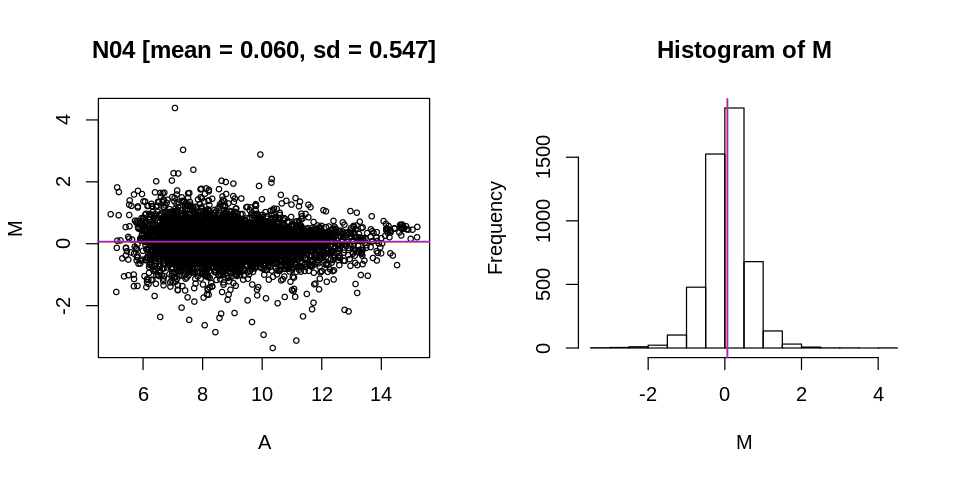

In [368]:
# for (pid in colnames(hypall_norm)[1:76]) {  
#   wpath <- sprintf("~/Dropbox/temp/ma_plot/%s_N01.pdf", pid)
#   pdf(wpath, width = 10, height = 5)
#   plot_ma(hypall_norm[,pid],
#           hypall_norm[,"N01"],
#           title = sprintf("%s", pid))
#   dev.off()
# }

pid <- "N04"
wpath <- sprintf("~/Dropbox/temp/ma_plot/%s_N01.pdf", pid)
# pdf(wpath, width = 10, height = 5)
plot_ma(hypall_norm[,pid], hypall_norm$N01, title = pid)
# dev.off()

In [372]:
# # Batch effects
# plot_ma(hypall_norm$P100_D0, hypall_norm$N01)
# # Technical variation
# plot_ma(hypall_norm$N02, hypall_norm$N01)
# # Hyperdiploid
# plot_ma(hypall_norm$P047_D0, hypall_norm$N01)

chr <- "chr4"
dir.create(sprintf("~/Dropbox/temp/%s", chr))
for (pid in colnames(hypall_norm)) {  
  wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)
  pdf(wpath, width = 10, height = 5)
  plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
          list_chr_all_hyp_norm[[chr]][,"N01"],
          title = sprintf("%s (%s)", pid, chr))
  dev.off()
}

Warning message in dir.create(sprintf("~/Dropbox/temp/%s", chr)):
“'/home/dblux/Dropbox/temp/chr4' already exists”

In [329]:
## Collate MA plot mean values

# dir.create(sprintf("~/Dropbox/temp/%s", chr))
# wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)

all_chr <- paste0("chr", 1:22)

raw_mm_tmm_sd <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[1:76],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)
raw_mm_tmm_sd1 <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[77:79],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)

In [343]:
## Collate MA plot mean values

# dir.create(sprintf("~/Dropbox/temp/%s", chr))
# wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)

all_chr <- paste0("chr", 1:22)

raw_medm_tmm_sd <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[1:76],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)
raw_medm_tmm_sd1 <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[77:79],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)

In [350]:
# plot_chr_hyp(t(raw_mm_tmm_sd[39:76,]), t(raw_mm_tmm_sd1),
#              "~/Dropbox/temp/MM-N01_3.pdf",
#              "~/Dropbox/temp/MM-N01_4.pdf")

plot_chr_hyp(t(raw_medm_tmm_sd[39:76,]), t(raw_medm_tmm_sd1),
             "~/Dropbox/temp/MedM-N01_3.pdf",
             "~/Dropbox/temp/MedM-N01_4.pdf")

### Plot: PCA

#### Local GSS

In [5]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, pid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  pid_idx <- intersect(pid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[,pid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission)/2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  
  # Median paired log-FC
  paired_logfc <- X_subtype_remission[,-(1:n_pairs)] -
    X_subtype_remission[,1:n_pairs] # D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(X_subtype_remission[,1:n_pairs])
  d8_mu <- rowMeans(X_subtype_remission[,-(1:n_pairs)])
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  feat <- intersect(feat_p, feat_log2fc)
  
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  print(sprintf("No. of features (intersect) = %d", length(feat)))
  
  return(feat)
}

In [6]:
#' Plots D33 vectors as well
# Plots batches in different colours and classes in different symbols
plot_vectors2 <- function(X, metadata_df, wpath = NULL, pc_labels = NULL) {
  class <- factor(metadata_df[colnames(X), "class_info"],
                  levels = c("D0", "D8", "D33", "N"))
  # Sort X according to class
  X_ord <- X[,order(class)]
  class <- class[order(class)]
  label <- as.factor(metadata_df[colnames(X_ord), "label"])
  
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(X_ord))
    X_pca <- data.frame(pca_obj$x[,1:2])
    
    ## Dataframe for arrows
    n <- nrow(X_pca)
    freq <- table(class)
    n_d0 <- freq["D0"]
    n_d33 <- freq["D33"]
    n_norm <- freq["N"]
    
    d0_pca <- X_pca[1:n_d0,]
    d8_pca <- X_pca[(n_d0+1):(n_d0*2),]
    d33_pca <- X_pca[(n_d0*2+1):(n_d0*2+n_d33),]
    norm_pca <- X_pca[(n-n_norm+1):n,]
    
    stopifnot(nrow(d0_pca) + nrow(d8_pca) + nrow(d33_pca) + nrow(norm_pca) == ncol(X))

    vector1 <- cbind(d0_pca, d8_pca)
    colnames(vector1) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    rownames(d8_pca) <- substring(rownames(d8_pca), 1 , 4)
    rownames(d33_pca) <- substring(rownames(d33_pca), 1 , 4)
    pid_d8d33 <- intersect(rownames(d8_pca), rownames(d33_pca))
    vector2 <- cbind(d8_pca[pid_d8d33,], d33_pca[pid_d8d33,])
    colnames(vector2) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    
    ## Variance
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
    
  } else {
    print("No PCA performed!")
    X_pca <- data.frame(X)
  }
  
  scatter_pca1 <- ggplot() +
    geom_point(data = X_pca, aes(x = PC1, y = PC2, bg = label, pch = class),
               size = 3, show.legend = T) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5) +
    scale_fill_manual(values = c("darkolivegreen3", "tomato3")) +
    scale_shape_manual(values = 21:24) +
    geom_segment(data = vector1, aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")), alpha = 0.5) +
    geom_segment(data = vector2, aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")), alpha = 0.5)
    
  # theme(plot.title = element_text(hjust = 0.5))
  
  if(!is.null(wpath))
    ggsave(wpath, scatter_pca1, width = 8, height = 4)

  return(list(scatter_pca1, X_pca))
}

#### Plot: Vectors

In [12]:
#' Plot vectors 2D
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors <- function(X, metadata_df, cex = 3, pc_labels = NULL, main = NULL) {
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(X))
    pca_df <- data.frame(pca_obj$x[,1:2])
    n <- nrow(pca_df)
    d0_pca <- pca_df[1:((n-3)/2),]
    d8_pca <- pca_df[((n-1)/2):(n-3),]
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    subtype_pca <- cbind(d0_pca, d8_pca)
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    norm_pca <- pca_df[(n-2):n,]
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    print(label)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(X)
  }
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
    geom_text(aes(x = PC1_A, y = PC2_A,
                  label = rownames(subtype_pca)),
              position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [8]:
#' Plot vectors 2D (Colour by subtype)
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors2 <- function(X, metadata_df, cex = 3, pc_labels = NULL, main = NULL) {
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(X))
    pca_df <- data.frame(pca_obj$x[,1:2])
    n <- nrow(pca_df)
    d0_pca <- pca_df[1:((n-3)/2),]
    d8_pca <- pca_df[((n-1)/2):(n-3),]
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    subtype_pca <- cbind(d0_pca, d8_pca)
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    norm_pca <- pca_df[(n-2):n,]
    
    # Obtaining subtype and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    subtype <- as.factor(metadata_df[rownames(d0_pca), "subtype"])
    print(label)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(X)
  }
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = subtype), shape = 15,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = subtype), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [9]:
#' Plot vectors and MILE data
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors3 <- function(X, metadata_df, X_mile, metadata_mile,
                          cex = 3, pc_labels = NULL, main = NULL) {
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(cbind(X, X_mile)))
    pca_df <- data.frame(pca_obj$x[,1:2])
    n_yeoh <- ncol(X)
    n_mile <- ncol(X_mile)
    
    d0_pca <- pca_df[1:((n_yeoh-3)/2),]
    d8_pca <- pca_df[((n_yeoh-1)/2):(n_yeoh-3),]
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    subtype_pca <- cbind(d0_pca, d8_pca)
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    norm_pca <- pca_df[(n_yeoh-2):n_yeoh,]
    
    # MILE data
    mile_pca <- pca_df[(n_yeoh+1):nrow(pca_df),]
    mile_subtype <- metadata_mile[colnames(X_mile), "subtype"]
    mile_pca_subtype <- cbind(mile_pca, subtype = mile_subtype)
        
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    print(head(rownames(mile_pca)))
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(X)
  }
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = T) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [342]:
a <- as.factor(c(1:5, NA))
a <- addNA(a)
is.na(levels(a))
# a[is.na(a)] <- "hyp"

# levels(a)


[1] FALSE FALSE FALSE FALSE FALSE  TRUE

In [349]:
#' Plot vectors and MILE data
#' PCA space is defined using MILE data and Yeoh datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors4 <- function(X, metadata_df, X_mile, metadata_mile, cex = 3) {
  # PCA
  pca_obj <- prcomp(t(X_mile))
  mile_pca <- data.frame(pca_obj$x[,1:2])

  X_pca <- data.frame(predict(pca_obj, t(X))[,1:2])
  n_yeoh <- ncol(X)

  # Yeoh data (D0, D8, N)
  d0_pca <- X_pca[1:((n_yeoh-3)/2),]
  d8_pca <- X_pca[((n_yeoh-1)/2):(n_yeoh-3),]
  subtype_pca <- cbind(d0_pca, d8_pca)

  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))

  colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
  norm_pca <- X_pca[(n_yeoh-2):n_yeoh,]

  # MILE data
  mile_subtype <- metadata_mile[colnames(X_mile), "subtype"]
  
  # Label simulated data if present
  if (any(is.na(mile_subtype))) {
    mile_subtype <- addNA(mile_subtype)
    levels(mile_subtype)[is.na(levels(mile_subtype))] <- "Simulated"
  }
  
  mile_pca_subtype <- cbind(mile_pca, subtype = mile_subtype)

  # Obtaining batch and class annotations
  label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
  batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])

  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:4]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(data = mile_pca_subtype,
               aes(x = PC1, y = PC2, shape = subtype, col = subtype),
               size = cex, alpha = 0.3, show.legend = T) +
    geom_point(aes(x = PC1_A, y = PC2_A, fill = batch),
               shape = 21, size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, fill = batch), shape = 22,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 22, fill = "red") +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  return(scatter_pca)
}

In [11]:
#' Plot vectors and MILE data (single scatter)
#' PCA space is defined using Yeoh data and MILE datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors5 <- function(X, metadata_df, X_mile, metadata_mile,
                          cex = 3, pc_labels = NULL, main = NULL) {
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(X))
    X_pca <- data.frame(pca_obj$x[,1:2])
    
    mile_pca <- data.frame(predict(pca_obj, t(X_mile))[,1:2])
    n_yeoh <- ncol(X)
    
    # Yeoh data (D0, D8, N)
    d0_pca <- X_pca[1:((n_yeoh-3)/2),]
    d8_pca <- X_pca[((n_yeoh-1)/2):(n_yeoh-3),]
    subtype_pca <- cbind(d0_pca, d8_pca)
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    norm_pca <- X_pca[(n_yeoh-2):n_yeoh,]
    
    # MILE data
    mile_subtype <- metadata_mile[colnames(X_mile), "subtype"]
    mile_pca_subtype <- cbind(mile_pca, subtype = mile_subtype)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    print(head(rownames(mile_pca)))
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    stop("No PCA performed!")
  }
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = T) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [12]:
#' Plot vectors and MILE data (two scatter plots)
#' PCA space is defined using Yeoh data and MILE datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors6 <- function(X, metadata_df, X_mile, metadata_mile,
                          cex = 3, pc_labels = NULL, main = NULL) {
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(X))
    X_pca <- data.frame(pca_obj$x[,1:3])
    
    mile_pca <- data.frame(predict(pca_obj, t(X_mile))[,1:3])
    n_yeoh <- ncol(X)
    
    # Yeoh data (D0, D8, N)
    d0_pca <- X_pca[1:((n_yeoh-3)/2),]
    d8_pca <- X_pca[((n_yeoh-1)/2):(n_yeoh-3),]
    subtype_pca <- cbind(d0_pca, d8_pca)
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC3_A", "PC1_B", "PC2_B", "PC3_B")
    norm_pca <- X_pca[(n_yeoh-2):n_yeoh,]
    
    # MILE data
    mile_subtype <- metadata_mile[colnames(X_mile), "subtype"]
    mile_pca_subtype <- cbind(mile_pca, subtype = mile_subtype)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    print(head(rownames(mile_pca)))
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    stop("No PCA performed!")
  }
  
  scatter_pca1 <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  scatter_pca2 <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC3_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC3_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC3_A, xend = PC1_B, yend = PC3_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC3),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC3, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[3])
  
  fig <- plot_grid(scatter_pca1, scatter_pca2, ncol = 2)
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(fig)
}

In [13]:
#' Plot vectors and MILE data
#' PCA space is defined using Yeoh (D8) data and rest of the datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
#' @param metadata_df metadata (need not be aligned with X)
plot_vectors7 <- function(X, metadata_df, X_mile, metadata_mile,
                          cex = 3, pc_labels = NULL, main = NULL) {
  if (is.null(pc_labels)) {
    # Yeoh data (D0, D8, N)
    n_yeoh <- ncol(X)
    d0 <- X[,1:((n_yeoh-3)/2)]
    d8 <- X[,((n_yeoh-1)/2):(n_yeoh-3)]
    norm <- X[,(n_yeoh-2):n_yeoh]
    
    # PCA
    pca_obj <- prcomp(t(d8))
    d8_pca <- data.frame(pca_obj$x[,1:3])
    
    d0_pca <- data.frame(predict(pca_obj, t(d0))[,1:3])
    norm_pca <- data.frame(predict(pca_obj, t(norm))[,1:3])
    mile_pca <- data.frame(predict(pca_obj, t(X_mile))[,1:3])
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    subtype_pca <- cbind(d0_pca, d8_pca)
    
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC3_A", "PC1_B", "PC2_B", "PC3_B")
    
    # MILE data
    mile_subtype <- metadata_mile[colnames(X_mile), "subtype"]
    mile_pca_subtype <- cbind(mile_pca, subtype = mile_subtype)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    print(head(rownames(mile_pca)))
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    stop("No PCA performed!")
  }
  
  scatter_pca1 <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  scatter_pca2 <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC3_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC3_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC3_A, xend = PC1_B, yend = PC3_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC3),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC3, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[3])
  
  fig <- plot_grid(scatter_pca1, scatter_pca2, ncol = 2)
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca1)
}

In [14]:
#' Plot vectors and MILE data
#' PCA space is defined using Yeoh (D0-D8) data and rest of the datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
#' @param metadata_df metadata (need not be aligned with X)
plot_vectors8 <- function(X, metadata_df, X_mile, metadata_mile,
                          cex = 3, pc_labels = NULL, main = NULL) {
  if (is.null(pc_labels)) {
    # Yeoh data (D0, D8, N)
    n_yeoh <- ncol(X)
    d0d8 <- X[,1:(n_yeoh-3)]
    norm <- X[,(n_yeoh-2):n_yeoh]
    
    # PCA
    pca_obj <- prcomp(t(d0d8))
    d0d8_pca <- data.frame(pca_obj$x[,1:3])
    
    norm_pca <- data.frame(predict(pca_obj, t(norm))[,1:3])
    mile_pca <- data.frame(predict(pca_obj, t(X_mile))[,1:3])
    
    n_d0d8 <- nrow(d0d8_pca)
    d0_pca <- d0d8_pca[1:(n_d0d8/2),]
    d8_pca <- d0d8_pca[(n_d0d8/2 + 1):n_d0d8,]
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    subtype_pca <- cbind(d0_pca, d8_pca)
    
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC3_A", "PC1_B", "PC2_B", "PC3_B")
    
    # MILE data
    mile_subtype <- metadata_mile[colnames(X_mile), "subtype"]
    mile_pca_subtype <- cbind(mile_pca, subtype = mile_subtype)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    print(head(rownames(mile_pca)))
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    stop("No PCA performed!")
  }
  
  scatter_pca1 <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  scatter_pca2 <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC3_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC3_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC3_A, xend = PC1_B, yend = PC3_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC3),
               size = cex, shape = 17, col = "red") +
    geom_point(data = mile_pca_subtype, aes(x = PC1, y = PC3, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[3])
  
  fig <- plot_grid(scatter_pca1, scatter_pca2, ncol = 2)
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  fig <- plot_grid()
  
  return(scatter_pca1)
}

In [252]:
#' Plot jitter plot of PCs
#' @param X dataframe with features x samples
plot_pc <- function(X, Y, cex = 2, n_pc = 5, main = NULL) {
  # PCA
  pca_obj <- prcomp(t(X))
  pca_df <- data.frame(pca_obj$x[,1:n_pc])
  n <- nrow(pca_df)
  
  Y$label <- as.factor(Y$label)
  Y$batch_info <- as.factor(Y$batch_info)
  X_pca_annot <- cbind(Y[rownames(pca_df),
                         c("batch_info", "class_info", "label")], pca_df)
  long_pca_annot <- melt(X_pca_annot,
                         id.vars = c("batch_info", "class_info", "label"),
                         variable.name = "PC")
  print(head(long_pca_annot))
  
  ax_batch <- ggplot(long_pca_annot,
                aes(x = PC, y = value,
                    shape = class_info,
                    fill = batch_info,
                    group = batch_info)) +
    geom_point(cex = cex, show.legend = F,
               position = position_jitterdodge(jitter.height=0)) +
    scale_shape_manual(values = 21:23)

  ax_timepoint <- ggplot(long_pca_annot,
                aes(x = PC, y = value,
                    shape = class_info,
                    fill = label)) +
    geom_point(cex = cex, show.legend = F,
               position = position_jitterdodge(jitter.height=0)) +
    scale_shape_manual(values = 21:23) +
    scale_fill_manual(values = c("darkolivegreen3", "tomato3"))
  
  fig <- plot_grid(ax_batch, ax_timepoint, ncol = 2)
  
  return(fig)
}

 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8" "N01"    
[22] "N02"     "N04"    
  batch_info class_info label  PC      value
1          2         D0     0 PC1  -56.06913
2          3         D0     0 PC1  -28.37774
3          4         D0     0 PC1   34.75740
4          4         D0     1 PC1  -12.35978
5          1         D0     1 PC1 -131.03704
6          6         D0     1 PC1  -56.73535


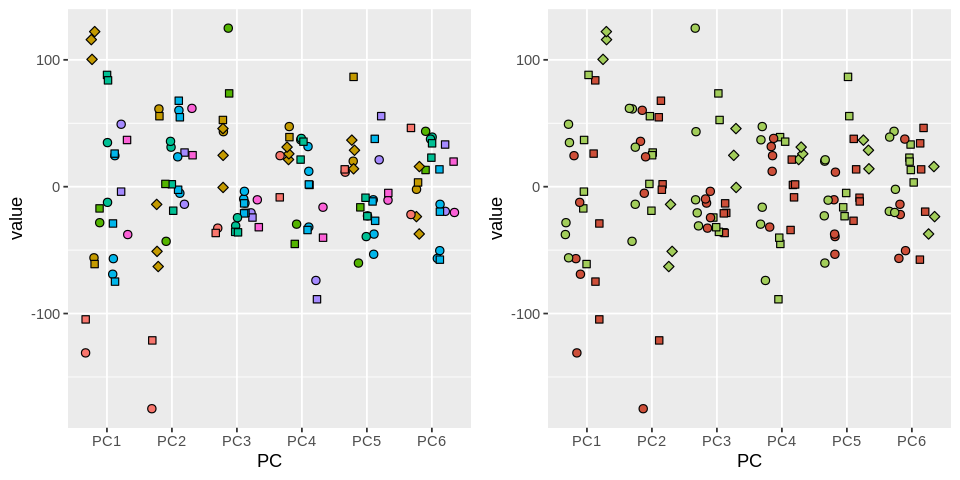

In [250]:
## Yeoh (2018)
pid_normal <- rownames(Y)[Y$subtype == "Normal"]
normal <- data[, pid_normal]

pid_subtype <- rownames(Y)[Y$subtype == subtype]
subtype_d0d8 <- data[, pid_subtype]

subtype_norm <- cbind(subtype_d0d8, normal)
print(colnames(subtype_norm))
plot_pc(subtype_norm, metadata_df)

#### Global GSS

#### Drug response genes

  [1] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1
 [75] 1 2 1 2 1 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 1 1 2 1 2 2 1 1 1 1 1 2 2 2 1 1 1
[112] 1 2 1 2 2 1 2 1 2 2 1 1 1 2 1 1 1 1 2 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2
[149] 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 1
[186] 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1
[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"


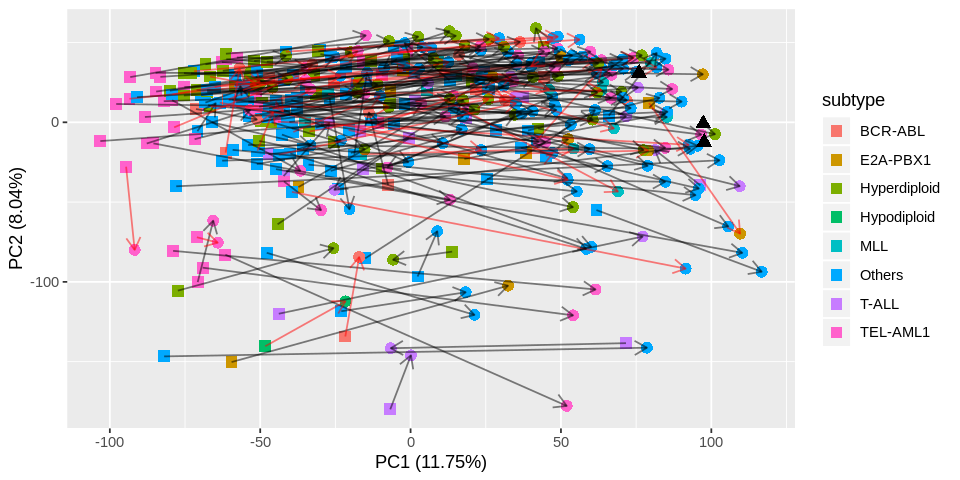

In [32]:
plot_vectors2(data, metadata_df)

[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"
[1] "A001" "A002" "A003" "A004" "A005" "A006"


Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”Warning message:
“Removed 306 rows containing missing values (geom_point).”Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”Warning message:
“Removed 306 rows containing missing values (geom_point).”Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”Warning message:
“Removed 306 rows containing missing values (geom_point).”

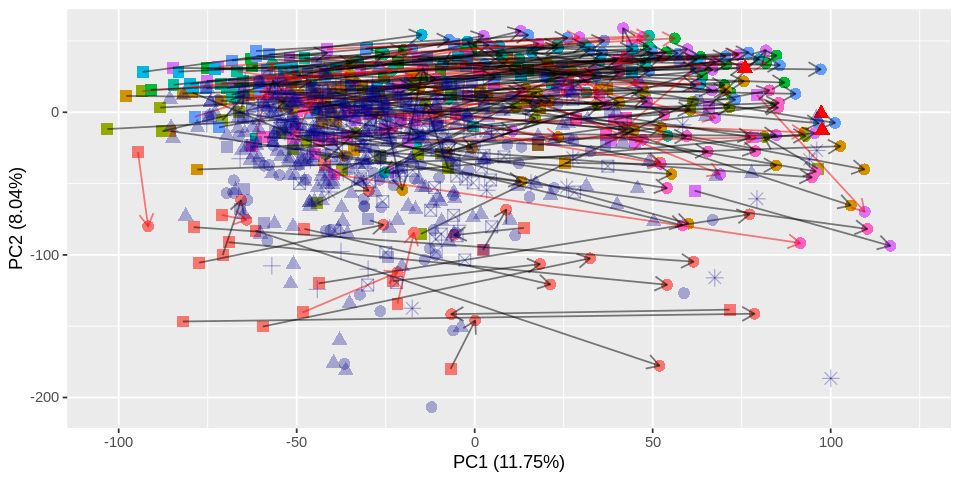

In [345]:
plot_vectors6(data, Y, data_mile, Y_mile)

In [690]:
for (subtype in subtypes) {
  ## Select drug response genes
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  data_subtype <- data[,pid_subtype]
  drug_genes <- getLocalGenes(data_subtype, pid_remission)
  data_subtype_norm <- data_all[drug_genes, Y_all$subtype %in% c(subtype, "Normal")]
  
  wpath <- sprintf("~/Dropbox/temp/pca_d33-%s.pdf", subtype)
  plot_vectors2(data_subtype_norm, Y_all, wpath = wpath)
}


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of fe

In [29]:
for (subtype in subtypes) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  wpath <- sprintf("~/Dropbox/temp/prediction_db-%s.pdf", subtype)
  wpath1 <- sprintf("~/Dropbox/temp/vectors_db1-%s.pdf", subtype)
  X_subtype <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                               batch_genes = batch_genes,
                               wpath = wpath, wpath_vector = wpath1)
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16] "angle_d0_normal"     "angle_d8_normal"     "l2norm_d0_normal"   
[19] "l2norm_d8_normal"    "l2norm_ratio1" 

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

 [1] 1 1 1 2 2 2 2 1 1 2
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] 1 1 1 2 2 1 1
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
[1] "Hyperdiploid"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
[1] "MLL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of selected genes = " "262"                     
[1] "No. of final genes = " "170"                  
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"    

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] 1 2 2 2 2 1 2 1
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0"
[1] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[1] "N01" "N02" "N04"
[1] "Others"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1 1 2 1
[1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0"
[1] "P059_D8" "P060_D8" "P061_D8" "P062_D8" "P063_D8" "P064_D8"
[1] "N01" "N02" "N04"
[1] "T-ALL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of selected genes = " "80"                      
[1] "No. of final genes = " "66"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 1 1 2 1 1 1 1 1 1 1 2 1
[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"
[1] "TEL-AML1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

 [1] 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1
[39] 1
[1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0"
[1] "P013_D8" "P014_D8" "P015_D8" "P016_D8" "P017_D8" "P018_D8"
[1] "N01" "N02" "N04"


#### Highly variable genes
Do genes aside from drug response genes reveal any other special responses of relapse samples?

 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8" "P176_D8" "P178_D8" "P182_D8"
[71] "P183_D8" "P189_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8" "N01"    
[78] "N02"     "N04"    
 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "

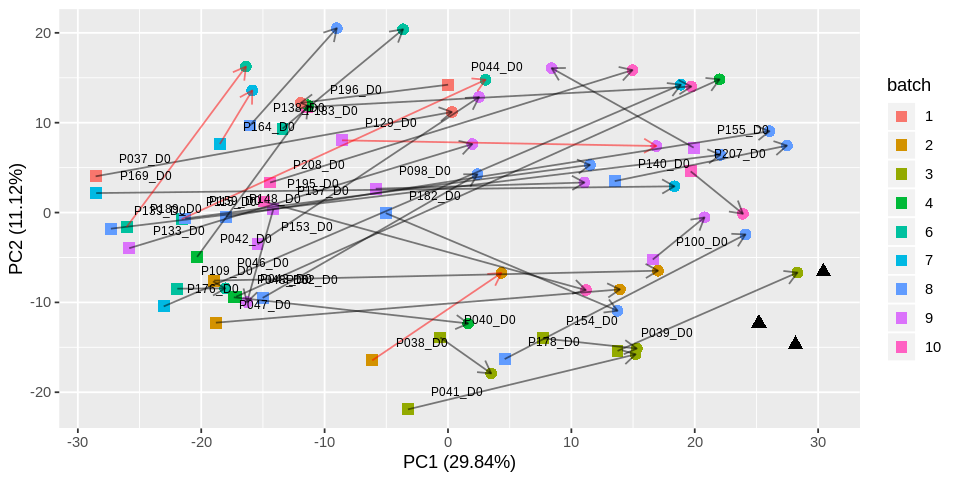

In [33]:
subtype <- "Hyperdiploid"
# wpath1 <- "~/Dropbox/temp/vectors_HVG-Hyperdiploid.pdf"

pid_normal <- rownames(Y)[Y$subtype == "Normal"]
normal <- data[,pid_normal]
pid_subtype <- rownames(Y)[Y$subtype == subtype]
subtype_d0d8 <- data[, pid_subtype] # no batch genes
subtype_norm <- cbind(subtype_d0d8, normal)
print(colnames(subtype_norm))

gene_var <- apply(subtype_norm, 1, var)
hvg <- names(head(sort(-gene_var), 50))
fltr_subtype_norm <- subtype_norm[hvg,]
plot_vectors(fltr_subtype_norm, metadata_df)

#### Import  MILE dataset

In [317]:
## Import data
MILE_METADATA_RPATH <- "data/GSE13204/processed/metadata1.tsv"
metadata_mile <- read.table(MILE_METADATA_RPATH, sep = "\t")

MILE_RPATH <- "data/GSE13204/processed/mas5_ordered.rds"
raw_mile <- readRDS(MILE_RPATH)

# SCALE->REMOVE->FILTER->LOG
scaled_mile <- normaliseMeanScaling(raw_mile)
data_mile <- log2_transform(scaled_mile[rownames(data),])

    A001     A002     A003     A004     A005     A006 
3.658293 2.541700 1.868566 3.670245 2.542585 2.924808 


#### Remove outliers

In [318]:
outliers <- c("N002", "N072")
X_mile <- data_mile[,!(colnames(data_mile) %in% outliers)]
Y_mile <- metadata_mile[colnames(X_mile),]

#### Plot: PCA (MILE - Normal (Outliers))

In [237]:
# pca_obj <- prcomp(t(normal_mile))
# pdf("~/Dropbox/temp/pca-mile_normal.pdf")
# plot(pca_obj$x[,1], pca_obj$x[,2],
#      xlab = "PC1", ylab = "PC2",
#      col = "steelblue", main = "Normal (MILE)")
# dev.off()
# text(pca_obj$x[,1], pca_obj$x[,2], rownames(pca_obj$x), cex = 0.7)

png 
  2

#### Globals (MILE)

In [35]:
pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
normal_mile <- X_mile[, pid_normal_mile]

subtype <- "Hyperdiploid"
pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
hyp_mile <- X_mile[, pid_subtype_mile]

hyp_normal_mile <- cbind(hyp_mile, normal_mile)
print(colnames(hyp_normal_mile))

  [1] "A001" "A002" "A003" "A004" "A005" "A006" "A007" "A008" "A009" "A010"
 [11] "A011" "A012" "A013" "A014" "A015" "A016" "A017" "A018" "A019" "A020"
 [21] "A021" "A022" "A023" "A024" "A025" "A026" "A027" "A028" "A029" "A030"
 [31] "A031" "A032" "A033" "A034" "A035" "A036" "A037" "A038" "A039" "A040"
 [41] "N001" "N002" "N003" "N004" "N005" "N006" "N007" "N008" "N009" "N010"
 [51] "N011" "N012" "N013" "N014" "N015" "N016" "N017" "N018" "N019" "N020"
 [61] "N021" "N022" "N023" "N024" "N025" "N026" "N027" "N028" "N029" "N030"
 [71] "N031" "N032" "N033" "N034" "N035" "N036" "N037" "N038" "N039" "N040"
 [81] "N041" "N042" "N043" "N044" "N045" "N046" "N047" "N048" "N049" "N050"
 [91] "N051" "N052" "N053" "N054" "N055" "N056" "N057" "N058" "N059" "N060"
[101] "N061" "N062" "N063" "N064" "N065" "N066" "N067" "N068" "N069" "N070"
[111] "N071" "N072" "N073" "N074"


#### Globals (Yeoh)

In [36]:
pid_normal <- rownames(Y)[Y$subtype == "Normal"]
normal <- data[,pid_normal]

subtype <- "Hyperdiploid"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
subtype_d0d8 <- data[, pid_subtype] # no batch genes

subtype_norm <- cbind(subtype_d0d8, normal)
print(colnames(subtype_norm))

 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8" "P176_D8" "P178_D8" "P182_D8"
[71] "P183_D8" "P189_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8" "N01"    
[78] "N02"     "N04"    


#### Plot: Vectors (relapse genes)

In [271]:
ALPHA <- 0.05
d8relapse_p <- top_ttest_d8_stats[[subtype]][,"pvalue"]
ps_d8relapse <- lapply(top_ttest_d8_stats,
                function(X) names(X[,"pvalue"])[X[,"pvalue"] < ALPHA & !(is.na(X[,"pvalue"]))])
str(ps_d8relapse)

List of 7
 $ BCR-ABL     : chr [1:81] "200069_at" "201247_at" "201385_at" "201388_at" ...
 $ E2A-PBX1    : chr [1:873] "200044_at" "200049_at" "200050_at" "200066_at" ...
 $ Hyperdiploid: chr [1:522] "177_at" "1861_at" "200053_at" "200642_at" ...
 $ MLL         : chr [1:378] "1053_at" "200005_at" "200044_at" "200054_at" ...
 $ Others      : chr [1:655] "200004_at" "200617_at" "200620_at" "200685_at" ...
 $ T-ALL       : chr [1:684] "177_at" "1861_at" "200010_at" "200027_at" ...
 $ TEL-AML1    : chr [1:857] "200040_at" "200644_at" "200654_at" "200661_at" ...


#### Plot: Vectors (D8 basis)

#### Global GSS

In [61]:
n <- ncol(data)
ps_drug <- getLocalGenes(data[,1:(n-3)], pid_remission)
print(length(ps_drug))

vector_fig <- plot_vectors(data[ps_drug,], Y)
wpath <- sprintf("~/Dropbox/temp/global_vectors_all_yeoh-%s.pdf", subtype)
ggsave(wpath, vector_fig, width = 10, height = 5)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 804"
[1] "No. of features (p-value) = 3611"
[1] "No. of features (log2-fc) = 356"
[1] 356
  [1] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1
 [75] 1 2 1 2 1 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 1 1 2 1 2 2 1 1 1 1 1 2 2 2 1 1 1
[112] 1 2 1 2 2 1 2 1 2 2 1 1 1 2 1 1 1 1 2 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2
[149] 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 1
[186] 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1
[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"


#### NEA (KEGG)

In [71]:
ENTREZ_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_entrez-GPL570.tsv"
entrez_yeoh <- affy2id(data, ENTREZ_GPL570)

## SYMBOL_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
## symbol_yeoh <- affy2id(data_yeoh, SYMBOL_GPL570)
## head(symbol_yeoh)

# Import NEA
NEA_RPATH <- paste0("../diff_expr/data/subnetwork/nea-hsa/",
                    "ovarian_cancer/geneset-nea_kegg_ovarian.tsv")
nea_df <- read.table(NEA_RPATH, sep = "\t", header = T, stringsAsFactors = F)
subnetwork_nea <- split(as.character(nea_df$gene_id), nea_df$subnetwork_id)

No. of probesets mapping to multiple IDs removed: 223
No. of probesets with no ID removed: 160
Total no. of probesets removed (incl. probesets mapping to same gene): 1128


In [189]:
gfs_yeoh <- normaliseGFS(data, upper = 0.05, lower = 0.8, num_intervals = 9)
entrez_gfs_yeoh <- affy2id(gfs_yeoh, ENTREZ_GPL570)

Top 0.05 of expressed genes are assigned GFS scores of 1
Genes below the top 0.80 of expressed genes are assigned GFS scores of 0
No. of probesets mapping to multiple IDs removed: 223
No. of probesets with no ID removed: 160
Total no. of probesets removed (incl. probesets mapping to same gene): 1128


In [191]:
#' Calculates QPSP profiles of samples
#' Rownames of df1 has to be the same annotation type as list of network vectors
#' @param df1 dataframe of discrete GFS-transformed expression data with
#' features in rows and samples in columns
#' @param list_complex list of vectors that contain components of networks
#' @return dataframe of QPSP profiles
calcQPSP <- function(df1, list_complex) {
  # All components in complex have to be measured in df1
  df1_proteins <- rownames(df1)
  # Logvec of whether entire complex is present
  complex_logvec <- sapply(list_complex,
                           function(vec) all(vec %in% df1_proteins))
  print(sum(complex_logvec))
                           
  # Error if any NA in complex_logvec
  if (anyNA(complex_logvec)) stop("NA present in logvec")
  
  sublist_complex <- list_complex[complex_logvec]
  
  # Driver function that calculates QPSP profile for single sample
  # @param col_vec Column vector representing single sample
  calcSingleQPSP <- function(col_vec) {
    sapply(sublist_complex, function(vec) mean(col_vec[vec]))
  }

  return(data.frame(apply(df1, 2, calcSingleQPSP)))
}

In [253]:
for (subtype in subtypes) {
  print(subtype)  
  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- entrez_gfs_yeoh[, pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- entrez_gfs_yeoh[, pid_subtype]
  
  subtype_norm <- cbind(subtype_d0d8, normal)
  qpsp_yeoh <- calcQPSP(subtype_norm, subnetwork_nea)
  
  # Jitter plot
  fig <- plot_pc(qpsp_yeoh, metadata_df)
  wpath <- sprintf("~/Dropbox/temp/jitter-qpsp1_%s.pdf", subtype)
  ggsave(wpath, fig, width = 10, height = 5)
  
#   # Prediction
#   n <- ncol(qpsp_yeoh)
#   response <- t(qpsp_yeoh[,1:(n-3)])
#   norm <- t(qpsp_yeoh[,(n-2):n])
#   results <- calcERM(response, norm)
#   #   print("Results!")
#   #   print(head(results))

#   label <- as.factor(metadata_df[rownames(results), "label"])
#   prediction_plot <- plotPrediction(results, metadata_df, yeoh_label)
#   wpath <- sprintf("~/Dropbox/temp/prediction-qpsp_gfs1_yeoh-%s.pdf", subtype)
#   ggsave(wpath, prediction_plot, width = 10, height = 5)
    
    # Vector plots
#   vector_fig <- plot_vectors(qpsp_yeoh, Y)
#   wpath <- sprintf("~/Dropbox/temp/vectors_qpsp_gfs1_yeoh-%s.pdf", subtype)
#   ggsave(wpath, vector_fig, width = 10, height = 5)
}

[1] "BCR-ABL"
[1] 184
  batch_info class_info label  PC        value
1          2         D0     0 PC1 -0.554270894
2          3         D0     0 PC1 -0.077256669
3          4         D0     0 PC1 -0.002402472
4          4         D0     1 PC1  0.270175907
5          1         D0     1 PC1 -0.017341984
6          6         D0     1 PC1 -0.716448060
[1] "E2A-PBX1"
[1] 184
  batch_info class_info label  PC      value
1          2         D0     0 PC1 -0.1781403
2          3         D0     0 PC1 -1.1374048
3          1         D0     0 PC1 -1.0516028
4          9         D0     1 PC1  0.4913810
5          9         D0     1 PC1 -0.2750573
6          8         D0     0 PC1 -0.2582096
[1] "Hyperdiploid"
[1] 184
  batch_info class_info label  PC      value
1          1         D0     0 PC1 -0.0123697
2          2         D0     1 PC1  0.4111111
3          3         D0     0 PC1  0.2805351
4          3         D0     0 PC1  0.4029498
5          3         D0     0 PC1  0.6046149
6          4  

In [ ]:
for (subtype in subtypes) {
  print(subtype)
  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- gfs_yeoh[,pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- gfs_yeoh[, pid_subtype]

  subtype_norm <- cbind(subtype_d0d8, normal)
  #   print(colnames(subtype_norm))

  ### SIGNAL GENES ###
  ps_drug <- getLocalGenes(subtype_d0d8, pid_remission)
  ps_idx <- setdiff(ps_drug, batch_genes)
  
  ## FILTER GENES
  fltr_yeoh <- subtype_norm[ps_idx,]
  fltr_mile <- subtype_norm_mile[ps_idx,]        

  print(sprintf("No. of ps_drug = %s", length(ps_drug)))
  print(sprintf("No. of batch_genes = %s", length(batch_genes)))
  print(sprintf("No. of ps_idx = %s", length(ps_idx)))
                  
  vector_fig <- plot_vectors8(fltr_yeoh, Y, fltr_mile, Y_mile)
  wpath <- sprintf("~/Dropbox/temp/vectors_db_d0d8yeoh-%s.pdf", subtype)
  ggsave(wpath, vector_fig, width = 10, height = 5)
}

#### No feature selection

In [64]:
## No feature selection
## Removal of batch genes

for (subtype in subtypes) {
  print(subtype)
    ## MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  normal_mile <- X_mile[, pid_normal_mile]

  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  subtype_mile <- X_mile[, pid_subtype_mile]
  
  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- data[, pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- data[, pid_subtype]
  
  ## FILTER GENES
  ps_idx <- setdiff(rownames(data), batch_genes)
  subtype_norm <- cbind(subtype_d0d8, normal)
  subtype_norm_mile <- cbind(subtype_mile, normal_mile)
  fltr_yeoh <- subtype_norm[ps_idx,]
  fltr_mile <- subtype_norm_mile[ps_idx,]
                  
  vector_fig <- plot_vectors(subtype_norm, Y)
  wpath <- sprintf("~/Dropbox/temp/vectors_wobatch_yeoh-%s.pdf", subtype)
  ggsave(wpath, vector_fig, width = 10, height = 5)
}
                  
## INVESTIGATE D33! Why are some shifts so weird?

[1] "BCR-ABL"
 [1] 1 1 1 2 2 2 2 1 1 2
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
[1] "E2A-PBX1"
[1] 1 1 1 2 2 1 1
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
[1] "Hyperdiploid"
 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
[1] "MLL"
[1] 1 2 2 2 2 1 2 1
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0"
[1] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[1] "N01" "N02" "N04"
[1] "Others"
 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1 1 2 1


#### Original (D-B)

In [105]:
for (subtype in subtypes) {
  print(subtype)
  ## MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  normal_mile <- X_mile[, pid_normal_mile]

  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  subtype_mile <- X_mile[, pid_subtype_mile]

  subtype_norm_mile <- cbind(subtype_mile, normal_mile)
  #   print(colnames(subtype_norm_mile))

  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- data[,pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- data[, pid_subtype]

  subtype_norm <- cbind(subtype_d0d8, normal)
  #   print(colnames(subtype_norm))

  ### SIGNAL GENES ###
  ps_drug <- getLocalGenes(subtype_d0d8, pid_remission)
  ps_idx <- setdiff(ps_drug, batch_genes)
  
  ## FILTER GENES
  fltr_yeoh <- subtype_norm[ps_idx,]
  fltr_mile <- subtype_norm_mile[ps_idx,]        

  print(sprintf("No. of ps_drug = %s", length(ps_drug)))
  print(sprintf("No. of batch_genes = %s", length(batch_genes)))
  print(sprintf("No. of ps_idx = %s", length(ps_idx)))
                  
  vector_fig <- plot_vectors8(fltr_yeoh, Y, fltr_mile, Y_mile)
  wpath <- sprintf("~/Dropbox/temp/vectors_db_d0d8yeoh-%s.pdf", subtype)
  ggsave(wpath, vector_fig, width = 10, height = 5)
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of ps_drug = 21"
[1] "No. of batch_genes = 2565"
[1] "No. of ps_idx = 14"
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
[1] "D001" "D002" "D003" "D004" "D005" "D006"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of ps_drug = 239"
[1] "No. of batch_genes = 2565"
[1] "No. of ps_idx = 164"
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
[1] "B001" "B002" "B003" "B004" "B005" "B006"
[1] "Hyperdiploid"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of pr

In [86]:
# ps_idx <- setdiff(rownames(data), batch_genes)

for (subtype in subtypes) {
  print(subtype)
    ## MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  normal_mile <- X_mile[, pid_normal_mile]

  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  subtype_mile <- X_mile[, pid_subtype_mile]
  
  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- data[, pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- data[, pid_subtype]
  
  ## Calculate logfc of each patient
  n <- ncol(subtype_d0d8)/2
  subtype_d0 <- subtype_d0d8[,1:n]
  subtype_d8 <- subtype_d0d8[,(n+1):(n*2)]
  logfc <- subtype_d8 - subtype_d0
  print(head(logfc))
  
#   ## SIGNAL GENES
#   M <- 200
#   top100_x <- apply(logfc, 2,
#                     function(x) head(sort(abs(x), decreasing = T), M))
#   top100 <- apply(logfc, 2,
#                   function(x) names(head(sort(abs(x), decreasing = T), M)))
#   top100 <- as.list(data.frame(top100))
#   common_top <- Reduce(union, top100)
  
#   top100_char <- lapply(top100, as.character)
#   all_ps <- unname(do.call(c, top100_char))
#   freq_ps <- table(all_ps)
#   nonuniq_ps <- names(freq_ps)[table(all_ps) > 1]
  
# #   ## NOISE GENES
# #   VAR <- 15
# #   d0_var <- apply(subtype_d0, 1, var)
# #   d0_hvg <- names(d0_var[d0_var > VAR])
                  
#   ## SPECIFY PS
# #   ps_idx <- setdiff(common_top, batch_genes)
# #   ps_drug <- getLocalGenes(subtype_d0d8, pid_remission)
# #   ps_idx <- union(nonuniq_ps, ps_drug)
# #   ps_idx <- setdiff(nonuniq_ps, d0_hvg)
#   ps_idx <- nonuniq_ps
  
#   ## FILTER GENES
#   subtype_norm <- cbind(subtype_d0d8, normal)
#   subtype_norm_mile <- cbind(subtype_mile, normal_mile)
#   fltr_yeoh <- subtype_norm[ps_idx,]
#   fltr_mile <- subtype_norm_mile[ps_idx,]
#   #   print(colnames(subtype_norm_mile))
#   #   print(colnames(subtype_norm))            

#   print(sprintf("No. of nonuniq_ps = %s", length(nonuniq_ps)))
# #   print(sprintf("No. of d0_hvg = %s", length(d0_hvg)))
# #   print(sprintf("No. of ps_idx = %s", length(ps_idx)))
                  
#   vector_fig <- plot_vectors7(fltr_yeoh, Y, fltr_mile, Y_mile)
#   wpath <- sprintf("~/Dropbox/temp/vectors_top200_nonuniq_d8yeoh-%s.pdf", subtype)
#   ggsave(wpath, vector_fig, width = 10, height = 5)
}

[1] "BCR-ABL"
              P053_D8    P054_D8     P055_D8     P056_D8     P057_D8    P134_D8
1053_at   -0.22391864  0.7796749 -0.83115763 -1.60370368 -0.60309660 -0.1933997
117_at     0.00000000  6.0837724  0.79906626  7.60541961  0.00000000  0.4940569
121_at    -0.06838085  0.2234627 -0.40121271 -0.09736247  0.09158028  0.1640346
1294_at    0.01101425 -1.4042958 -0.20125955 -1.07952979 -0.27698963  1.0571455
1316_at    1.03894032  0.6920307  0.08099245  0.56046385  0.53026188 -1.1139408
160020_at  0.00000000  7.0931788  5.60570720 -0.52671599  0.00000000  0.3649286
              P152_D8    P170_D8     P175_D8    P184_D8
1053_at    0.13526836 -0.6395884 -0.88688704 -1.0649385
117_at     0.04955653 -0.7371568  0.41767551  6.0320331
121_at    -0.03080487  0.1157879 -0.09272466 -1.2329491
1294_at   -0.53697915  0.3243850 -0.90571084  1.1471198
1316_at    1.01608781  0.6735331 -0.62029965  2.3313805
160020_at -0.46240708  0.4885838  0.01086614 -0.4497536
[1] "E2A-PBX1"
                P04

In [374]:
fig <- plot_vectors7(subtype_norm, Y, subtype_norm_mile, Y_mile)
ggsave("~/Dropbox/temp/test.pdf", fig)

[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
[1] "D001" "D002" "D003" "D004" "D005" "D006"


Saving 6.67 x 6.67 in image


#### No. of drug response genes for each subtype

In [306]:
for (subtype in subtypes) {
  print(subtype)
  ## MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  normal_mile <- X_mile[, pid_normal_mile]

  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  subtype_mile <- X_mile[, pid_subtype_mile]

  subtype_norm_mile <- cbind(subtype_mile, normal_mile)
  #   print(colnames(subtype_norm_mile))

  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- data[,pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- data[, pid_subtype]
  
  Y_temp <- Y[colnames(subtype_d0d8),]
  subtype_rem <- subtype_d0d8[,rownames(Y_temp)[Y_temp$label == 0]]
  subtype_rel <- subtype_d0d8[,rownames(Y_temp)[Y_temp$label == 1]] # relapse
  print(colnames(subtype_rem)) # ASSUMPTION: PIDS ARE PAIRED

  n_pid_yeoh <- ncol(subtype_d0d8)/2

  subtype_norm <- cbind(subtype_d0d8, normal)
  #   print(colnames(subtype_norm))

  ### SIGNAL GENES ###
  ps_drug <- getLocalGenes(subtype_d0d8, pid_remission)
  print(length(ps_drug))
  print("")
}

[1] "BCR-ABL"
 [1] "P053_D0" "P054_D0" "P055_D0" "P170_D0" "P175_D0" "P053_D8" "P054_D8"
 [8] "P055_D8" "P170_D8" "P175_D8"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] 21
[1] ""
[1] "E2A-PBX1"
 [1] "P049_D0" "P050_D0" "P051_D0" "P145_D0" "P161_D0" "P049_D8" "P050_D8"
 [8] "P051_D8" "P145_D8" "P161_D8"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] 239
[1] ""
[1] "Hyperdiploid"
 [1] "P037_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0" "P044_D0"
 [8] "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0" "P133_D0"
[15] "P138_D0" "P139_D0" "P140_D0" "P148_D0" "P153_D0" "P154_D0" "P155_D0"
[22] "P157_D0" "P159_D0" "P162_D0" "P169_D0" "P176_D0" "P178_D0" "P182_D0"
[29] "P183_D0" "P195_D0" "P196_D0" "P207_D0" "P208_D0" "P037_D8

In [332]:
for (subtype in subtypes) {
  print(subtype)
  d8_pvalue <- top_ttest_d8_stats[[subtype]][,"pvalue"]
  print(sum(d8_pvalue < 0.05, na.rm = T))
}

[1] "BCR-ABL"
[1] 81
[1] "E2A-PBX1"
[1] 873
[1] "Hyperdiploid"
[1] 522
[1] "MLL"
[1] 378
[1] "Others"
[1] 655
[1] "T-ALL"
[1] 684
[1] "TEL-AML1"
[1] 857


In [336]:
ALPHA <- 0.05
TOP_N <- 100
LOGFC <- 1
list_ps_relapse <- lapply(top_ttest_d8_ps, function(x, y) x[1:y], TOP_N)

for (subtype in subtypes) {
  print(subtype)
  ## MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  normal_mile <- X_mile[, pid_normal_mile]

  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  subtype_mile <- X_mile[, pid_subtype_mile]

  subtype_norm_mile <- cbind(subtype_mile, normal_mile)
  #   print(colnames(subtype_norm_mile))

  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- data[,pid_normal]
  
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- data[, pid_subtype]
  n_pid_yeoh <- ncol(subtype_d0d8)/2
  subtype_d0 <- subtype_d0d8[,1:n_pid_yeoh]
  
  Y_temp <- Y[colnames(subtype_d0d8),]
  subtype_rem <- subtype_d0d8[,rownames(Y_temp)[Y_temp$label == 0]]
  subtype_rel <- subtype_d0d8[,rownames(Y_temp)[Y_temp$label == 1]] # relapse
  print(colnames(subtype_rem)) # ASSUMPTION: PIDS ARE PAIRED

  n_pid_yeoh <- ncol(subtype_d0d8)/2

  subtype_norm <- cbind(subtype_d0d8, normal)
  #   print(colnames(subtype_norm))

  ### SIGNAL GENES ###
  # gene_var <- apply(subtype_norm_mile, 1, var) # HVG of MILE
  # hvg <- names(head(sort(-gene_var), 1000))
  # ps <- setdiff(hvg, batch_genes)
  
  ## Drug response genes (Yeoh)
  ps_drug_rem <- getLocalGenes(subtype_d0d8, pid_remission) # OPTION
  pvalue_drug_rem <- calc_ttest(subtype_rem, ncol(subtype_rem)/2, is_paired = T) # remission
#   ps_drug_rem <- names(head(sort(pvalue_drug_rem), TOP_N)) # OPTION
#   ps_drug_rem <- names(pvalue_drug_rem)[pvalue_drug_rem < ALPHA & !is.na(pvalue_drug_rem)] # OPTION
  print(sprintf("No. of ps_drug_rem = %s", length(ps_drug_rem)))
  
  pvalue_drug_rel <- calc_ttest(subtype_rel, ncol(subtype_rel)/2, is_paired = T) # relapse
#   ps_drug_rel <- names(head(sort(pvalue_drug_rel), TOP_N)) # OPTION
  ps_drug_rel_p <- names(pvalue_drug_rel)[pvalue_drug_rel < ALPHA & !is.na(pvalue_drug_rel)] # OPTION
  n_rel <- ncol(subtype_rel)/2
  subtype_rel_d0 <- subtype_rel[,1:n_rel]
  subtype_rel_d8 <- subtype_rel[,(n_rel+1):(n_rel*2)]
  logfc_df <- subtype_rel_d8 - subtype_rel_d0
  logfc <- rowMeans(logfc_df)
  ps_drug_rel_logfc <- names(logfc)[abs(logfc) > LOGFC]
  ps_drug_rel <- intersect(ps_drug_rel_p, ps_drug_rel_logfc)
  print(sprintf("No. of ps_drug_rel_p = %s", length(ps_drug_rel_p)))
  print(sprintf("No. of ps_drug_rel_logfc = %s", length(ps_drug_rel_logfc)))
  print(sprintf("No. of ps_drug_rel = %s", length(ps_drug_rel)))
  
  ## Relapse genes (D0)
#   ps_relapse <- top_ttest_d8_ps[[subtype]][1:length(ps_drug_rel)] # OPTION
  d8_pvalue <- top_ttest_d8_stats[[subtype]][,"pvalue"]
  d8_logfc <- top_ttest_d8_stats[[subtype]][,"logfc"]
  ps_relapse_p <- names(d8_pvalue)[d8_pvalue < ALPHA & !is.na(d8_pvalue)]
  ps_relapse_logfc <- names(d8_logfc)[abs(d8_logfc) > LOGFC]
  ps_relapse <- intersect(ps_relapse_p, ps_relapse_logfc)
  
  print(sprintf("No. of ps_relapse_p = %s", length(ps_relapse_p)))
  print(sprintf("No. of ps_relapse_logfc = %s", length(ps_relapse_logfc)))
  print(sprintf("No. of ps_relapse = %s", length(ps_relapse)))
  
  ## Subtype signature (Yeoh)
  stopifnot(endsWith(colnames(subtype_d0)[1], "D0"))
  pvalue_subtype <- calc_ttest(cbind(subtype_d0, normal), ncol(subtype_d0))
  
  ps_subtype <- names(head(sort(pvalue_subtype), TOP_N)) # OPTION
  ## Threshold for subtype results in too many probesets!
#   ps_subtype_p <- names(pvalue_subtype)[pvalue_subtype < ALPHA & !is.na(pvalue_subtype)] # OPTION
#   logfc1 <- calc_logfc(subtype_d0, normal)
#   ps_subtype_logfc <- names(logfc1)[abs(logfc1) > LOGFC]
#   ps_subtype <- intersect(ps_subtype_p, ps_subtype_logfc)
  
  print(sprintf("No. of ps_subtype_p = %s", length(ps_subtype_p)))
  print(sprintf("No. of ps_subtype_logfc = %s", length(ps_subtype_logfc)))
  print(sprintf("No. of ps_subtype = %s", length(ps_subtype)))
  
  ## Combination
  ps_idx <- Reduce(union, list(ps_drug_rem, ps_drug_rel, ps_relapse, ps_subtype))
  
  print(sprintf("No. of ps_drug_rem = %s", length(ps_drug_rem)))
  print(sprintf("No. of ps_drug_rel = %s", length(ps_drug_rel)))
  print(sprintf("No. of ps_relapse = %s", length(ps_relapse)))
  print(sprintf("No. of ps_idx = %s", length(ps_idx)))
  
  vectors <- plot_vectors6(subtype_norm[ps_idx,], metadata_df,
                           subtype_norm_mile[ps_idx,], Y_mile)

  wpath <- sprintf("~/Dropbox/temp/vectors_drugrel_drug_relapse_threshold_subtypetop100_yeoh-%s.pdf", subtype)
  ggsave(wpath, vectors, width = 10, height = 5)
}


[1] "BCR-ABL"
 [1] "P053_D0" "P054_D0" "P055_D0" "P170_D0" "P175_D0" "P053_D8" "P054_D8"
 [8] "P055_D8" "P170_D8" "P175_D8"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of ps_drug_rem = 21"
[1] "No. of ps_drug_rel_p = 207"
[1] "No. of ps_drug_rel_logfc = 1320"
[1] "No. of ps_drug_rel = 22"
[1] "No. of ps_relapse_p = 81"
[1] "No. of ps_relapse_logfc = 1357"
[1] "No. of ps_relapse = 28"
[1] "No. of ps_subtype_p = 2603"
[1] "No. of ps_subtype_logfc = 2324"
[1] "No. of ps_subtype = 100"
[1] "No. of ps_drug_rem = 21"
[1] "No. of ps_drug_rel = 22"
[1] "No. of ps_relapse = 28"
[1] "No. of ps_idx = 166"
[1] 10  6
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
[1] "D001" "D002" "D003" "D004" "D005" "D006"
[1] "E2A-PBX1"
 [1] "P049_D0" "P050_D0" "P051_D0" "P145_D

### Feature selection (Signal - Noise)

In [68]:
subtypes1 <- setdiff(subtypes, "Others")

In [101]:
for (subtype in subtypes1) {
  print(subtype)
  
  ## MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  normal_mile <- X_mile[, pid_normal_mile]

  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  subtype_mile <- X_mile[, pid_subtype_mile]

  subtype_norm_mile <- cbind(subtype_mile, normal_mile)
#   print(colnames(subtype_norm_mile))
  
  ## Yeoh (2018)
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  normal <- data[,pid_normal]

  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  subtype_d0d8 <- data[, pid_subtype] # no batch genes
  n_pid_yeoh <- ncol(subtype_d0d8)/2
  subtype_d0 <- subtype_d0d8[,1:n_pid_yeoh]

  subtype_norm <- cbind(subtype_d0d8, normal)
#   print(colnames(subtype_norm))
  
  ### SIGNAL GENES ###
  ALPHA <- 0.001
  EXPR <- 6
  LOGFC <- 2
  TOP_N <- 200
  
  ## Subtype signature genes (MILE)
  pvalue <- calc_ttest(subtype_norm_mile, ncol(subtype_mile))
  logfc <- calc_logfc(subtype_mile, normal_mile)
  
#   ## Individual mean expr level
#   hyp_mu <- rowMeans(subtype_mile)
#   normal_mu <- rowMeans(normal_mile)
  
#   ## Thresholding
#   ps1 <- names(pvalue)[pvalue < ALPHA]
#   ps2 <- rownames(subtype_mile)[hyp_mu > EXPR | normal_mu > EXPR]
#   ps3 <- names(logfc)[abs(logfc) > LOGFC]
#   ps_signature <- Reduce(intersect, list(ps1, ps2, ps3)) # OPTION
#   ps_signature <- ps2 # OPTION

#   ## Top ranked features
#   top_pvalue <- head(sort(pvalue), TOP_N)
#   ps_subtype_mile <- names(top_pvalue)

#   ## Drug response genes (Yeoh)
#   ps_drug <- getLocalGenes(subtype_d0d8, pid_remission)
#   pvalue3 <- calc_ttest(subtype_d0d8, n_pid_yeoh, is_paired = T)
#   top_pvalue1 <- head(sort(pvalue3), TOP_N)
# #   ps_drug <- names(top_pvalue1) # OPTION
#   ps_drug <- names(pvalue3)[pvalue3 < ALPHA & !is.na(pvalue3)] # OPTION
  
  ## Subtype signature (Yeoh)
  stopifnot(endsWith(colnames(subtype_d0)[1], "D0"))
  
  subtype_d0_mu <- rowMeans(subtype_d0)
  normal_mu <- rowMeans(normal)
  
  pvalue4 <- calc_ttest(cbind(subtype_d0, normal), ncol(subtype_d0))
  logfc4 <- calc_logfc(subtype_d0, normal)
  ps4 <- names(pvalue4)[pvalue4 < ALPHA]
  ps5 <- rownames(subtype_d0)[subtype_d0_mu > EXPR | normal_mu > EXPR]
  ps6 <- names(logfc4)[abs(logfc4) > LOGFC]
  ps_signature <- Reduce(intersect, list(ps4, ps5, ps6)) # OPTION
  
#   ps_subtype <- names(top_pvalue2) # OPTION
#   ps_subtype <- names(pvalue4)[pvalue4 < ALPHA & !is.na(pvalue4)] # OPTION
  
#   ## Relapse genes (Yeoh: D8)
#   list_ps_relapse <- lapply(top_ttest_d8_ps, function(x, y) x[1:y], TOP_N)
# #   ps_relapse <- list_ps_relapse[[subtype]] # OPTION
#   relapse_pvalue <- top_ttest_d8_stats[[subtype]][, "pvalue"]
#   ps_relapse <- names(relapse_pvalue)[relapse_pvalue < ALPHA  & !is.na(relapse_pvalue)] # OPTION
                            
#   ## Consolidatae signal genes
#   ps_signal <- Reduce(union, list(ps_drug, ps_subtype, ps_relapse))
  
#   print(sprintf("No. of ps_signature_mile = %s", length(ps_signature_mile)))
#   print(sprintf("No. of ps_subtype = %s", length(ps_subtype)))
#   print(sprintf("No. of ps_drug = %s", length(ps_drug)))
#   print(sprintf("No. of ps_relapse = %s", length(ps_relapse)))
#   print(sprintf("No. of ps_signal = %s", length(ps_signal)))
#   print(sprintf("Sample size = %s", ncol(subtype_norm)))
  
#   ### BATCH EFFECT GENES ###
#   ALPHA <- 0.001
#   LOGFC <- 1
#   ## Batch effects between Yeoh (2018) and MILE
  
#   ## Difference in means between normal samples in Yeoh and MILE dataset
#   pvalue_batch_norm <- calc_ttest(cbind(normal, normal_mile), ncol(normal))
# #   logfc1 <- calc_logfc(normal, normal_mile)
  
#   ## Difference in means between subtype samples in Yeoh and MILE dataset
#   pvalue_batch_subtype <- calc_ttest(cbind(subtype_d0, subtype_mile), ncol(subtype_d0))
# #   logfc2 <- calc_logfc(subtype_d0d8, subtype_mile)

#   ps_batch_norm <- names(pvalue_batch_norm)[pvalue_batch_norm < ALPHA]
# #   ps2 <- names(logfc1)[abs(logfc1) > LOGFC]
# #   ps_batch1 <- intersect(ps1, ps2)
  
#   ps_batch_subtype <- names(pvalue_batch_subtype)[pvalue_batch_subtype < ALPHA]
# #   ps4 <- names(logfc2)[abs(logfc2) > LOGFC]
# #   ps_batch2 <- intersect(ps3, ps4)
  
#   print(sprintf("No. of ps_batch_norm = %s", length(ps_batch_norm)))
#   print(sprintf("No. of ps_batch_subtype = %s", length(ps_batch_subtype)))
                            
#   ### HVG (MILE) GENES ###
#   VAR <- 8
#   subtype_mile_var <- apply(subtype_mile, 1, var)
#   normal_mile_var <- apply(normal_mile, 1, var)
#   ps_hvg_subtype_mile <- names(subtype_mile_var)[subtype_mile_var > VAR]
#   ps_hvg_normal_mile <- names(normal_mile_var)[normal_mile_var > VAR]
                            
#   print(sprintf("No. of ps_hvg_subtype_mile = %s", length(ps_hvg_subtype_mile)))
#   print(sprintf("No. of ps_hvg_normal_mile = %s", length(ps_hvg_normal_mile)))
  
#   ## Combining batch genes
#   ps_batch <- Reduce(union, list(ps_hvg_subtype_mile, ps_hvg_normal_mile))
#   print(sprintf("No. of ps_batch = %s", length(ps_batch)))

  ## S-B
  ps_sb <- setdiff(ps_signature, batch_genes)
#   ps_sb <- ps_signature
  
  print(sprintf("Final dim = %s", length(ps_sb)))
  print("")
                            
  ## Plot vectors
  ps_idx <- ps_sb
  vectors <- plot_vectors6(subtype_norm[ps_idx,], metadata_df,
                           subtype_norm_mile[ps_idx,], Y_mile)
#   batch0 = batch_genes
#   batch1 = ps_batch_norm + ps_batch_subtype
#   batch 2 = HVG (MILE)
#   batch 3 = HVG (MILE) + ps_batch_norm + ps_batch_subtype                            
  
  wpath <- sprintf("~/Dropbox/temp/vectors_yeohsubtype_wobatch_yeoh-%s.pdf", subtype)
  ggsave(wpath, vectors,
         width = 10, height = 5)
  
#   ## Relapse prediction
#   X <- subtype_norm[ps_idx,]
#   X_mile <- subtype_norm_mile[ps_idx,]
  
#   pca_obj <- prcomp(t(cbind(X, X_mile)))
#   pca_df <- data.frame(pca_obj$x[,1:2])
#   n_yeoh <- ncol(X)
#   X_pca <- pca_df[1:n_yeoh,]

#   wpath1 <- sprintf("~/Dropbox/temp/prediction_mileyeoh-%s.pdf", subtype)
#   predict_relapse1(t(X_pca), metadata_df, wpath = wpath1)
}

[1] "BCR-ABL"
[1] "Final dim = 193"
[1] ""
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
[1] "D001" "D002" "D003" "D004" "D005" "D006"
[1] "E2A-PBX1"
[1] "Final dim = 50"
[1] ""
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
[1] "B001" "B002" "B003" "B004" "B005" "B006"
[1] "Hyperdiploid"
[1] "Final dim = 526"
[1] ""
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
[1] "A001" "A002" "A003" "A004" "A005" "A006"
[1] "MLL"
[1] "Final dim = 161"
[1] ""
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0"
[1] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[1] "N01" "N02" "N04"
[1] "G001" "G002" "G003" "G004" "G005" "G006"
[1] "T-ALL"
[1] "Final dim = 304"
[1] ""
[1

In [118]:
pca_obj <- prcomp(t(subtype_norm[ps_idx,]))
X_pca <- pca_obj$x

In [1258]:
predict_relapse1 <- function(X, metadata_df, wpath, pid_remission = pid_remission) {
  idx <- 1:(ncol(X)-3)
  response <- t(X)[idx,]
  normal <- t(X)[-idx,]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
  label <- as.factor(metadata_df[rownames(results), "label"])
  list_prediction <- plotPrediction(results, metadata_df, yeoh_label)
  
  if (!is.null(wpath))
    ggsave(wpath, list_prediction[[1]], width = 14, height = 7)
  
  return(scatter_plot)  
}

#### Subtype signature genes (MILE)

In [1109]:
## Subtype signature genes (MILE)
ALPHA <- 0.05
EXPR <- 6
LOGFC <- 1

pvalue <- calc_ttest(hyp_normal_mile, ncol(hyp_mile))
logfc <- calc_logfc(hyp_mile, normal_mile)

hyp_mu <- rowMeans(hyp_mile)
normal_mu <- rowMeans(normal_mile)

ps1 <- rownames(hyp_mile)[hyp_mu > EXPR | normal_mu > EXPR] 
ps2 <- names(pvalue)[pvalue < ALPHA]
ps3 <- names(logfc)[abs(logfc) > LOGFC]

ps_signature <- Reduce(intersect, list(ps1, ps2, ps3))
print(length(ps_signature))

# TOP P-VALUE IS BETTER!
top_pvalue <- head(sort(pvalue), 100)
ps_pvalue <- names(top_pvalue)
print(top_pvalue)

[1] 1874
   219686_at    212488_at    212489_at    203373_at    212386_at    201540_at 
5.145597e-96 4.233135e-84 1.204180e-80 1.982541e-71 2.046249e-60 2.215630e-59 
   214761_at    218005_at    214539_at    206493_at    219998_at    206277_at 
2.567905e-57 4.416254e-52 1.502107e-51 6.989186e-51 2.464497e-48 3.429815e-47 
   201005_at    203753_at    201462_at    206001_at    212727_at    205190_at 
1.414663e-45 4.248339e-44 9.444040e-44 3.728264e-43 6.091377e-43 7.244023e-43 
   209101_at    208302_at    216667_at    202039_at    214033_at    200670_at 
3.604835e-42 4.535290e-42 1.450024e-41 3.010965e-41 8.466311e-41 9.014977e-41 
   202908_at    208791_at    206440_at    201416_at    221773_at    218613_at 
1.010203e-40 1.228485e-39 2.285454e-39 2.294034e-39 2.642032e-39 2.743806e-39 
   220528_at    220384_at     59697_at    220000_at    218694_at    221485_at 
8.452348e-39 2.104650e-38 2.495854e-38 1.196287e-37 1.308839e-37 1.592069e-37 
   212013_at    217728_at    202242_at    2

#### Batch genes

In [1172]:
## Batch effects between Yeoh (2018) and MILE
ALPHA <- 0.05
LOGFC <- 1

## Difference in means between normal samples in Yeoh and MILE dataset
pvalue1 <- calc_ttest(cbind(normal, normal_mile), 3)
logfc1 <- calc_logfc(normal, normal_mile)

ps1 <- names(pvalue1)[pvalue1 < ALPHA]
ps2 <- names(logfc1)[abs(logfc1) > LOGFC]
ps_batch <- intersect(ps1, ps2)
print(length(ps_batch))

[1] 1160


In [1173]:
ps_sb <- setdiff(ps_pvalue, ps_var)
print(length(ps_pvalue))
print(length(ps_var))
print(length(ps_sb))

[1] 100
[1] 1000
[1] 87


In [1174]:
ps_idx <- ps_pvalue
print(length(ps_idx))

vectors <- plot_vectors3(subtype_norm[ps_idx,], metadata_df,
                         hyp_normal_mile[ps_idx,], metadata_mile)
ggsave("~/Dropbox/temp/vectors_mileyeoh-Hyperdiploid.pdf", vectors,
       width = 10, height = 5)

[1] 100
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
[1] "A001" "A002" "A003" "A004" "A005" "A006"


#### Quantile normalisation (naive)

In [1028]:
# Quantile normalise both Yeoh and MILE datasets)
qnorm_data <- normaliseQuantile(cbind(hyp_norm_mile, hypd0d8_norm))
qnorm_mile <- qnorm_data[,1:ncol(hyp_norm_mile)]
qnorm_yeoh <- qnorm_data[,(ncol(hyp_norm_mile)+1):ncol(qnorm_data)]

In [1058]:
colnames(hypd0d8_norm)

[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8" "P176_D8" "P178_D8" "P182_D8"
[71] "P183_D8" "P189_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8"

In [1044]:
## Subtype signature genes (MILE)
ALPHA <- 0.05
EXPR <- 6
LOGFC <- 2

qnorm_hyp_mile <- qnorm_mile[,1:40]
qnorm_norm_mile <- qnorm_mile[,41:114]

pvalue <- calc_ttest(qnorm_mile, 40)
logfc <- calc_logfc(qnorm_hyp_mile, qnorm_norm_mile)

qnorm_hyp_mu <- rowMeans(qnorm_hyp_mile)
qnorm_normal_mu <- rowMeans(qnorm_norm_mile)

ps1 <- rownames(hyp_mile)[qnorm_hyp_mu > EXPR | qnorm_normal_mu > EXPR] # Either mean has to be > 6
ps2 <- names(pvalue)[pvalue < ALPHA]
ps3 <- names(logfc)[abs(logfc) > LOGFC]

ps_signature <- Reduce(intersect, list(ps1, ps2, ps3))
print(length(ps_signature))


top_pvalue <- head(sort(pvalue), 50)
ps_pvalue <- names(top_pvalue)
print(top_pvalue)

[1] 1018
   219686_at    212488_at    214761_at    212489_at    203373_at    206440_at 
4.031862e-96 1.339595e-82 1.429333e-81 9.759936e-79 8.024606e-76 3.289818e-64 
   212386_at    201540_at    202908_at    218005_at    208302_at    214539_at 
2.277864e-63 9.324258e-62 4.179524e-56 3.948169e-55 5.000672e-54 4.311494e-53 
   206493_at    212013_at     59697_at    203753_at    209101_at    219998_at 
1.499310e-51 2.905266e-48 2.204351e-47 4.493781e-46 6.552304e-46 5.301754e-45 
   201005_at    206277_at    205769_at    206001_at    216667_at    201462_at 
8.677293e-45 1.014554e-44 1.817229e-44 1.385326e-43 1.152297e-42 1.526075e-42 
   212727_at    204099_at    200670_at    210145_at    202039_at    209576_at 
1.581957e-42 1.021531e-41 2.061349e-41 2.164391e-41 9.338298e-41 9.582835e-41 
    41220_at    201416_at    208791_at    202242_at    204581_at    205190_at 
1.866897e-40 1.607647e-39 2.562163e-39 2.617612e-39 5.349944e-39 9.708463e-39 
   220000_at    218613_at    220384_at    2

#### Variance between normal (MILE) samples in subtype signature genes

In [981]:
hyp_norm_mile <- cbind(hyp_mile, normal_mile)
class_mile <- as.factor(substring(colnames(hyp_norm_mile), 1, 1))

mile1 <- data.frame(subtype = class_mile, t(hyp_norm_mile),
                    check.names = F)

In [990]:
print(length(ps_signature))

[1] 625


[1] "200872_at"


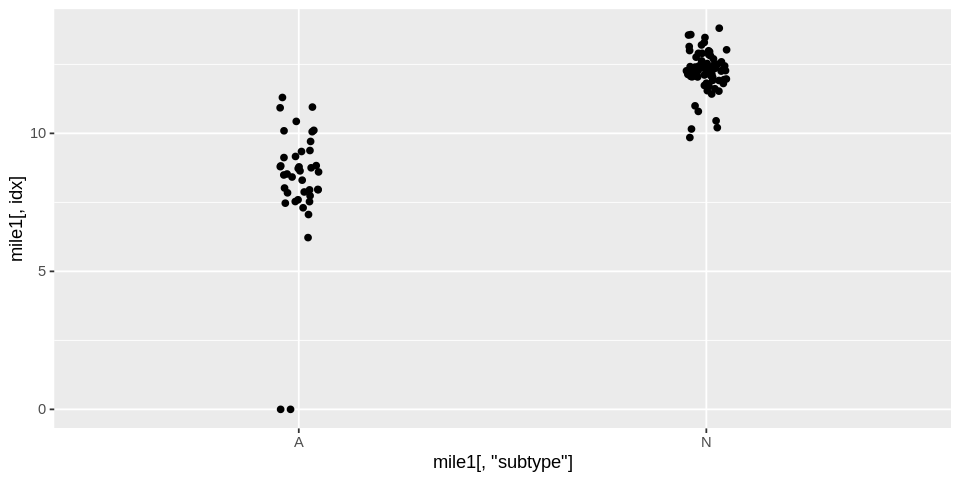

In [991]:
# Visualise variance in subtype signature genes
idx <- ps_signature[5]
print(idx)
ggplot() +
  geom_point(aes(x = mile1[,"subtype"], y = mile1[,idx]),
             position = position_jitter(width=.05, height=0))

In [877]:
normal_mile_var <- apply(normal_mile, 1, var)
ps_topvar <- names(head(sort(normal_mile_var[ps_sb], decreasing = T)))
print(pvalue[ps_topvar])
print(logfc[ps_topvar])

   213089_at    219083_at    202996_at    202159_at    215147_at    218481_at 
2.866609e-05 6.361968e-03 1.443824e-07 6.847154e-03 7.561542e-05 4.619699e-03 
213089_at 219083_at 202996_at 202159_at 215147_at 218481_at 
 2.878617  2.254703  2.987097  2.273632  2.444346  2.243292 


#### Plot: Probeset intensities

In [452]:
list_pca <- plot_pca_2d(hypall_norm_median, metadata_df)
pc1 <- list_pca[[2]][,"PC1"]

pdf("~/Dropbox/temp/pc1_sum.pdf")
plot(colSums(hypall_norm_median), pc1,
     xlab = "Sum of median chr intensities", ylab = "PC1")
text(colSums(hypall_norm_median)+.8, pc1+.05,
     colnames(hypall_norm_median), cex = .75)
dev.off()

png 
  2

In [450]:
pdf("~/Dropbox/temp/ps_sum.pdf")
plot(colSums(hyperdiploid), ylab = "Sum of probeset intensities")
text(colSums(hyperdiploid) + 500, colnames(hyperdiploid), cex = .75)
dev.off()

png 
  2

In [ ]:
## Plot: Sum of intensities
# D <- data.frame(subtype = metadata_df[names(sum_d0), "subtype"],
#                 value = sum_d0)
# features_plot <- ggplot(D, aes(as.factor(subtype), value, colour = subtype)) +
#   geom_point(position = position_jitter(width=.1, height=0), cex = 2, show.legend = F) + # position = position_jitterdodge()
#   theme(axis.title.x=element_blank(),
#         axis.text.x=element_text(angle = 20, vjust = 0.5))
# ggsave("~/Dropbox/temp/colsum-scaled.pdf", features_plot,
#        width = 6, height = 5)

# # Raw: D0 data
# selected_raw <- removeProbesets(raw_yeoh)
# unnorm_raw <- log2_transform(filterProbesets(selected_raw, 0.7, metadata_df))
# sum_raw_d0 <- colSums(unnorm_raw)[idx_d0]
# 
# D1 <- data.frame(subtype = metadata_df[names(sum_raw_d0), "subtype"],
#                  value = sum_raw_d0)
# features_plot1 <- ggplot(D1, aes(as.factor(subtype), value, colour = subtype)) +
#   geom_point(position = position_jitter(width=.1, height=0), cex = 2, show.legend = F) + # position = position_jitterdodge()
#   theme(axis.title.x=element_blank(),
#         axis.text.x=element_text(angle = 20, vjust = 0.5))
# ggsave("~/Dropbox/temp/colsum-unnorm.pdf", features_plot1,
#        width = 6, height = 5)

#### Batch info

In [11]:
hyp_batch <- metadata_df[paste(colnames(hyperdiploid), "D0", sep = "_"), "batch_info"]
names(hyp_batch) <- colnames(hyperdiploid)
print(hyp_batch)

P037 P038 P039 P040 P041 P042 P043 P044 P046 P047 P048 P098 P100 P109 P115 P129 
   1    2    3    3    3    4    4    1    2    2    4    9    9    6    6    9 
P133 P138 P139 P140 P148 P153 P154 P155 P157 P159 P162 P164 P169 P176 P178 P182 
   9    8    8    8    8    9    3    9    9    8    8    7    7    7    8    8 
P183 P189 P195 P196 P207 P208 
   6    6   10   10   10   10 


#### Clustering

In [174]:
## Clustering (T-SNE)
# hyp_tsne <- Rtsne(t(hyperdiploid), perplexity = 1)$Y
# plot(hyp_tsne[,1], hyp_tsne[,2], pch = 19, col = hyp_batch)
# text(hyp_tsne[,1], hyp_tsne[,2], colnames(hyperdiploid))

## Clustering (PCA)
# hyp_pca <- prcomp(t(hyperdiploid))$x
# plot(hyp_pca[,1], hyp_pca[,2], pch = 19, col = hyp_batch)
# text(hyp_pca[,1], hyp_pca[,2], colnames(hyperdiploid))

# # Filtering drug responsive genes
# fltr_hyp1 <- hyperdiploid[hyp_genes,]
# fltr_hyp2 <- hyperdiploid[hyp_wobatch_genes,]
# fltr_hyp_norm1 <- X_hyp[hyp_wobatch_genes,]
# colnames(fltr_hyp2) <- paste(colnames(fltr_hyp2), "D0", sep = "_")

## Clustering with T-SNE does not reveal any pattern

# Clustering (Hierachical)
heatmap_metadata <- metadata_df[, c("batch_info", "label"), drop = F]
pheatmap(fltr_hyp2, col = brewer.pal(9, "Blues"),
       display_numbers = F, fontsize = 5.5,
       legend = T, border_color = "black", scale = "none",
       cluster_method = "ward.D2", cluster_rows = F, cluster_cols = T,
       show_colnames = T, show_rownames = F,
       annotation_col = heatmap_metadata,
       cellwidth = 10, cellheight = 1,
       filename = "~/Dropbox/temp/heatmap-hyp_drug_wobatch.pdf")

# c1_pid <- sprintf("P%03d", c(44, 155, 140, 207, 154, 40, 39, 100, 178))
# c2_pid <- sprintf("P%03d", c(37, 42, 48, 139, 133, 176, 43, 109, 115, 148, 169, 189))
# c3_pid <- sprintf("P%03d", c(41, 46, 47, 38, 153, 162, 164, 159, 183, 129, 138, 208, 195, 196, 157, 98, 182))

# list_clusters <- list(c1_pid, c2_pid, c3_pid)
# list_clusters_all <- convert_list_pid(list_clusters)

## Relapse (gene markers)

In [186]:
# Filtering drug responsive genes
fltr_hypd8 <- hyperdiploid_d8[hyp_wobatch_genes,]
colnames(fltr_hypd8) <- paste(colnames(fltr_hypd8), "D8", sep = "_")

# Clustering (Hierachical)
heatmap_metadata <- metadata_df[, c("batch_info", "label"), drop = F]
pheatmap(fltr_hypd8, col = brewer.pal(9, "Blues"),
       display_numbers = F, fontsize = 5.5,
       legend = T, border_color = "black", scale = "none",
       cluster_method = "ward.D2", cluster_rows = F, cluster_cols = T,
       show_colnames = T, show_rownames = F,
       annotation_col = heatmap_metadata,
       cellwidth = 10, cellheight = 1,
       filename = "~/Dropbox/temp/heatmap-hypd8_drug_wobatch.pdf")

c1_pid1 <- sprintf("P%03d", c(44, 189, 164, 42, 138, 115, 183, 37, 109, 157))
c2_pid1 <- setdiff(colnames(hyperdiploid), c1_pid1)
print(length(c1_pid1))
print(length(c2_pid1))

list_clusters1 <- list(c1_pid1, c2_pid1)
list_clusters_all1 <- convert_list_pid(list_clusters1)

[1] 10
[1] 28


### Plot: Heatmap

#### Relapse marker genes

In [135]:
Y_ord <- Y[order(Y$label),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot

## Hyperdiploid D0
hypd0 <- hyperdiploid
colnames(hypd0) <- paste0(colnames(hyperdiploid), "_D0") # rename pid

pid_hypd0 <- rownames(Y_ord)
ord_hypd0 <- hypd0[,pid_hypd0] # rearrange columns
pvalue1 <- calc_ttest(ord_hypd0, size_a = 33, is_paired = F)
ps_relapse <- names(head(sort(pvalue1), 50))

# Plot
filename <- "~/Dropbox/temp/heatmap-hyp_d0.pdf"
pheatmap(ord_hypd0[ps_relapse,],
         annotation_col = Y_annot,
         col = brewer.pal(9, "Blues"),
         display_numbers = F, fontsize = 5.5,
         legend = T, border_color = "black", scale = "none",
         cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
         show_colnames = T, show_rownames = T,
         cellwidth = 8, cellheight = 10,
         filename = filename)

### Plot: MRD

Warning message:
“Removed 15 rows containing missing values (geom_point).”

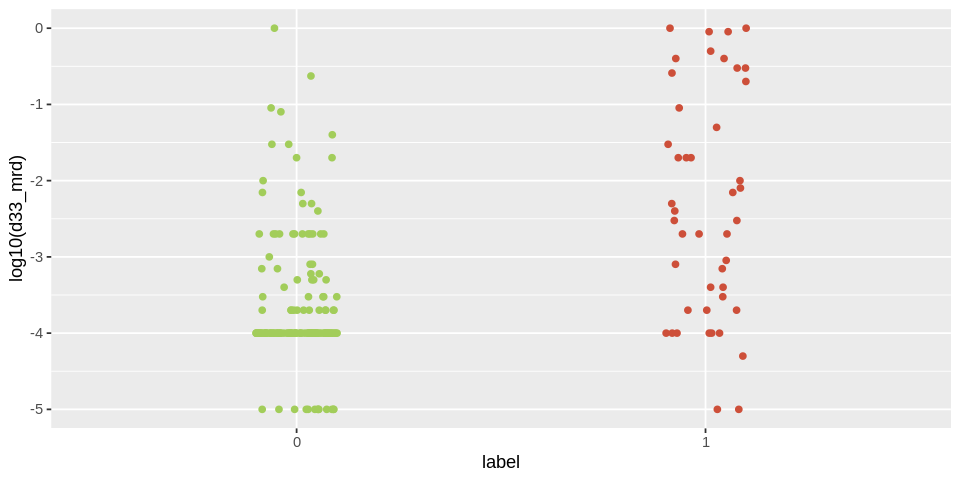

In [240]:
yeoh_label$label <- as.factor(yeoh_label$label)

ggplot(yeoh_label,
       aes(label, log10(d33_mrd), color = label)) +
  geom_point(position = position_jitter(width=.1, height=0),
             show.legend = F) +
  scale_color_manual(values = c("darkolivegreen3", "tomato3"))

### Feature selection

#### All subtypes (D0)
- Constant: Timepoint, subtype

In [80]:
#' @param filename partial filename without file extension
select_features <- function(X, Y, class,
                            m = 50, alpha = .01, fc = 1, filename = NULL) {  
  Y_ord <- Y[order(Y$label),] # order by labels!
  Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
  
  all_subtypes <- levels(metadata_df$subtype)
  subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))

  list_ps <- list()
  list_stats <- list()
  for (subtype in subtypes) {
    print(subtype)
    pid <- rownames(Y_ord)[Y_ord$class_info == class & Y_ord$subtype == subtype]
    n_remission <- sum(Y_ord[pid, "label"] == 0)
    X_subtype <- X[,pid]

    # T-test
    ttest_arr <- calc_ttest(X_subtype, size_a = n_remission,
                            flag = "both", is_paired = F)
    pvalue <- ttest_arr["pvalue",]

    top_pvalue <- head(sort(pvalue), m) # top M pvalue
    top_ps_ttest <- names(top_pvalue)

    fltr_ttest <- ttest_arr[, pvalue < alpha & !is.na(pvalue)] # threshold
    ps_ttest <- colnames(fltr_ttest)

    ## Log-fc
    logfc <- calc_logfc(X_subtype[,1:n_remission],
                        X_subtype[,(n_remission+1):ncol(X_subtype)])
    fltr_logfc <- logfc[abs(logfc) > fc] # threshold
    ps_logfc <- names(fltr_logfc)

#     # Intersection
#     ps_selected <- intersect(ps_logfc, ps_ttest)
#     ps_final <- setdiff(ps_selected, batch_genes)

#     # Limma
#     design <- model.matrix(~label ,data = Y[colnames(X_subtype),])
#     fit <- lmFit(X_subtype, design)
#     fit <- eBayes(fit)
#     limma_t <- fit$t[,2]
#     limma_df <- fit$df.residual[1] + fit$df.prior
#     limma_pvalue <- pt(abs(limma_t)*-1, limma_df)

#     fltr_limma <- limma_pvalue[limma_pvalue < alpha & !is.na(limma_pvalue)]
#     ps_limma <- names(fltr_limma)
    
    # Consolidate pvalue and logfc
    statistics <- cbind(t(ttest_arr), logfc)
    list_stats <- append(list_stats, list(statistics)) # save list
    
    # Save list
    ps <- top_ps_ttest # option!
    list_ps <- append(list_ps, list(ps)) # save list
    
    print(length(ps))
    
    if (!is.null(filename)) {
      # Plot
      n <- length(pid)
      m <- length(ps)
      X_plot <- t(X[ps, pid])

      wpath <- sprintf("%s-%s_%s.pdf", filename, subtype, class)
      pheatmap(X_plot,
               annotation_row = Y_annot,
               col = brewer.pal(9, "Blues"),
               display_numbers = F, fontsize = 5.5,
               legend = T, border_color = "black", scale = "none",
               cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
               show_colnames = T, show_rownames = T,
               cellwidth = 400/m, cellheight = 240/n,
               filename = wpath)  
    }
  }

  names(list_ps) <- subtypes
  names(list_stats) <- subtypes
  
  return(list(list_ps, list_stats))
}

In [148]:
# top_ttest_d0 <- select_features(data, Y, class = "D0", m = 50)
# top_ttest_d0_ps <- top_ttest_d0[[1]]
# top_ttest_d0_stats <- top_ttest_d0[[2]]

top_ttest_d8 <- select_features(data, Y, class = "D8", m = 2000)
top_ttest_d8_ps <- top_ttest_d8[[1]]
top_ttest_d8_stats <- top_ttest_d8[[2]]

[1] "BCR-ABL"
[1] 2000
[1] "E2A-PBX1"
[1] 2000
[1] "Hyperdiploid"
[1] 2000
[1] "MLL"
[1] 2000
[1] "Others"
[1] 2000
[1] "T-ALL"
[1] 2000
[1] "TEL-AML1"
[1] 2000


#### Plot: UpSet

In [329]:
hyperdiploid

,P037,P038,P039,P040,P041,P042,P043,P044,P046,P047,⋯,P169,P176,P178,P182,P183,P189,P195,P196,P207,P208
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1053_at,9.673490,8.423645,8.296763,8.743939,9.085534,8.864744,8.786708,8.897991,8.117929,8.765268,⋯,9.326420,9.040411,8.655769,8.399875,8.810275,9.560071,8.645671,8.335803,8.520797,8.831891
117_at,0.000000,0.000000,0.000000,0.000000,0.000000,5.417335,5.867670,0.000000,6.830392,0.000000,⋯,0.000000,0.000000,7.234948,5.883479,4.821740,5.657435,0.000000,0.000000,6.251930,0.000000
121_at,9.233889,0.000000,8.239617,8.388115,8.414085,8.202342,7.720398,8.913832,8.109431,7.649167,⋯,7.795799,8.019991,8.192492,8.079298,7.736489,7.902482,8.546890,8.087026,8.407084,8.256416
1294_at,9.734687,9.886040,9.702531,9.125748,8.285402,9.950791,10.357386,9.652862,10.120834,10.040306,⋯,9.766852,9.253744,9.769712,9.452683,10.143823,10.528271,9.131448,8.950735,8.994552,8.745933
1316_at,7.162259,8.578890,8.467939,7.382976,9.004389,6.242392,6.547581,0.000000,7.506224,8.937852,⋯,8.167941,7.380957,7.157435,8.232511,7.556917,6.751439,7.629901,7.804504,7.584110,7.866468
160020_at,8.465023,6.975849,7.331590,7.426855,7.490068,6.978237,7.590264,8.148533,6.360947,6.729761,⋯,7.440132,7.344052,7.996594,7.304786,6.690291,6.528667,6.598626,7.532127,5.796173,6.329650
1729_at,8.016546,8.311086,8.422766,8.024863,8.727145,7.717318,8.613621,9.116495,9.196200,9.416942,⋯,8.393327,8.539572,8.978594,9.038023,9.140372,8.757480,8.018006,8.843933,7.930537,8.855001
177_at,0.000000,0.000000,5.968240,0.000000,0.000000,0.000000,0.000000,6.144660,0.000000,0.000000,⋯,0.000000,0.000000,5.945145,0.000000,5.392294,0.000000,0.000000,0.000000,6.055741,0.000000
1861_at,8.016457,7.192192,0.000000,0.000000,0.000000,7.442834,7.293192,7.492494,0.000000,7.966065,⋯,7.486035,7.490320,7.275854,7.098277,7.394367,8.189392,7.313068,7.469136,6.912249,7.528991


png 
  2

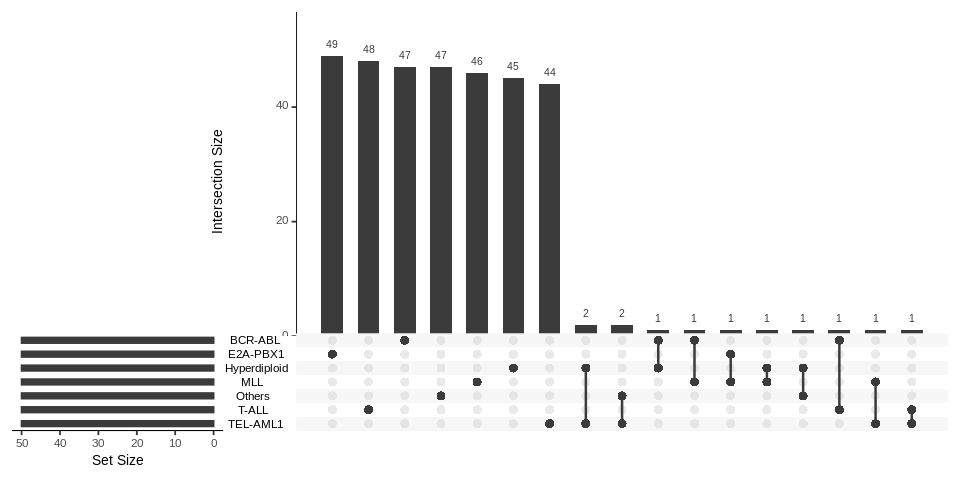

In [70]:
upset(fromList(top_ttest_d8_ps),
      nsets = length(top_ttest_d8_ps),
      nintersects = NA,
      order.by = "freq")

upset_plot <- recordPlot()
save_fig(upset_plot, "~/Dropbox/temp/upset-top_ttest_d8_genes.pdf",
         width = 8, height = 4)

- Union of subtype specific relapse genes does not result in global relapse prediction model
- No clustering of relapse samples (both D0 and D8 samples)

In [ ]:
union_top_ttest_d8 <- Reduce(union, top_ttest_d0_ps)

# Plot
idx <- union_top_ttest_d8
pid <- rownames(Y)[Y$class_info == "D0"]

n <- length(pid)
m <- length(idx)
X_plot <- t(X[idx, pid])

# filename <- sprintf("~/Dropbox/temp/heatmap_union_top_ttest_d0.pdf")
# pheatmap(X_plot,
#          annotation_row = Y_annot,
#          col = brewer.pal(9, "Blues"),
#          display_numbers = F, fontsize = 5.5,
#          legend = T, border_color = "black", scale = "none",
#          cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
#          show_colnames = T, show_rownames = T,
#          cellwidth = 400/m, cellheight = 240/n,
#          filename = filename)

In [375]:
## Hyperdiploid (PRIORITY)

# Only D0/D8
names(list_ps_d0) <- subtypes
names(list_ps_d8) <- subtypes
n_ps_d0 <- sapply(list_ps_d0, length)
n_ps_d8 <- sapply(list_ps_d8, length)

# D0 and D8 genes
list_intersect <- mapply(intersect, list_ps_d0, list_ps_d8, SIMPLIFY = T) 
names(list_intersect) <- subtypes
list_union <- mapply(union, list_ps_d0, list_ps_d8, SIMPLIFY = T) 
names(list_union) <- subtypes

### Feature engineering

#### Plot: PCA (check for linear separation)

In [ ]:
SUBTYPE <- "Hyperdiploid"
idx_d0 <- top_ttest_d0[[SUBTYPE]]
pid_hyp_d0 <- rownames(Y)[Y$subtype == SUBTYPE & Y$class_info == "D0"]

pca_obj <- plot_pca_2d(X[idx_d0, pid_hyp_d0], Y)
pca_obj[[1]]

idx_d8 <- top_ttest_d8[[SUBTYPE]]
pid_hyp_d8 <- rownames(Y)[Y$subtype == SUBTYPE & Y$class_info == "D8"]

pca_obj <- plot_pca_2d(X[idx_d8, pid_hyp_d8], Y)
pca_obj[[1]]

In [65]:
## Features
# For each class info, obtain two clusters (group of up and down regulated probesets - t-stat)
# Group and calculate the sum of the groups for d8 and d8 - 4 features to classify relapse
# Features are conditionally independent - Naive bayes

Y_ord <- Y[order(Y$label),]
list_feat_d8 <- list()
threshold <- 1
class <- "D8"

for (subtype in subtypes) {
  print(subtype)
  ps <- top_ttest_d8_ps[[subtype]]
  print(length(ps))
  pid <- rownames(Y_ord)[Y_ord$subtype == subtype & Y_ord$class_info == class]

  logfc <- top_ttest_d8_stats[[subtype]][,"logfc"][ps]
  fltr_logfc <- logfc[abs(logfc) > threshold]
  ps_downreg <- names(fltr_logfc)[fltr_logfc > 0]
  ps_upreg <- names(fltr_logfc)[fltr_logfc < 0]
  print(length(ps_downreg))
  print(length(ps_upreg))
  
  X_down <- X[ps_downreg, pid]
  X_up <- X[ps_upreg, pid]
  
  # Plot
  n <- length(pid)
  m1 <- length(ps_downreg)
  m2 <- length(ps_upreg)
  
  filename1 <- sprintf("~/Dropbox/temp/heatmap_ps_downreg_%s-%s.pdf", class, subtype)
  filename2 <- sprintf("~/Dropbox/temp/heatmap_ps_upreg_%s-%s.pdf", class, subtype)
  
  if (length(ps_downreg) > 1) {
    pheatmap(X_down,
             annotation_col = Y_annot,
             col = brewer.pal(9, "Blues"),
             display_numbers = F, fontsize = 5.5,
             legend = T, border_color = "black", scale = "none",
             cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
             show_colnames = T, show_rownames = T,
             cellwidth = 300/n, cellheight = 200/m1,
             filename = filename1)  
  }
  
  if (length(ps_upreg) > 1) {
    pheatmap(X_up,
             annotation_col = Y_annot,
             col = brewer.pal(9, "Blues"),
             display_numbers = F, fontsize = 5.5,
             legend = T, border_color = "black", scale = "none",
             cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
             show_colnames = T, show_rownames = T,
             cellwidth = 8, cellheight = 15,
             filename = filename2)
  }
  
  feat_downreg <- apply(X[ps_downreg, pid, drop = F], 2, mean)
  feat_upreg <- apply(X[ps_upreg, pid, drop = F], 2, mean)
  
  list_feat_d8 <- append(list_feat_d8, list(cbind(down_d8 = feat_downreg,
                                                  up_d8 = feat_upreg)))
}

names(list_feat_d8) <- subtypes

[1] "BCR-ABL"
[1] 50
[1] 10
[1] 7
[1] "E2A-PBX1"
[1] 50
[1] 50
[1] 0
[1] "Hyperdiploid"
[1] 50
[1] 31
[1] 13
[1] "MLL"
[1] 50
[1] 16
[1] 17
[1] "Others"
[1] 50
[1] 1
[1] 46
[1] "T-ALL"
[1] 50
[1] 5
[1] 27
[1] "TEL-AML1"
[1] 50
[1] 23
[1] 24


In [66]:
list_feat <- mapply(cbind, list_feat_d0, list_feat_d8)
print(list_feat)

$`BCR-ABL`
         down_d0     up_d0  down_d8    up_d8
P053_D0 8.526758  8.817686 7.013069 5.223824
P054_D0 7.389656  8.980461 7.607455 5.984990
P055_D0 7.957171  9.464412 6.706861 6.460708
P170_D0 8.203110  9.372481 7.622661 5.200510
P175_D0 7.925409  9.171091 7.317655 6.504678
P056_D0 4.862456 10.387365 6.456133 8.892391
P057_D0 4.460317 11.177671 2.522385 9.599188
P134_D0 5.223590  9.853224 4.646124 8.804848
P152_D0 4.985627 10.438327 2.855458 8.611786
P184_D0 4.994740 10.598962 2.428519 9.147217

$`E2A-PBX1`
         down_d0    up_d0   down_d8 up_d8
P049_D0 9.183383 0.000000 8.2757588   NaN
P050_D0 9.169483 0.000000 8.5188388   NaN
P051_D0 9.279634 0.000000 8.6019580   NaN
P145_D0 8.923482 0.000000 8.1956453   NaN
P161_D0 8.653333 5.170405 8.1425517   NaN
P102_D0 6.290254 6.757250 0.6021478   NaN
P124_D0 6.309883 5.885636 0.6013668   NaN

$Hyperdiploid
          down_d0    up_d0   down_d8     up_d8
P037_D0 0.5282460 3.018128 0.9903692 3.6398256
P039_D0 5.3290911 3.275166 5.6285775

In [67]:
list_feat <- mapply(cbind, list_feat_d0, list_feat_d8)

plot_downup <- function(subtype, l) {
  X <- l[[subtype]]
  label <- as.factor(Y[rownames(X), "label"])
  X_plot <- cbind(data.frame(X), label)
  X_long <- melt(X_plot, id.var = "label")

  # PLOT: FEATURES
  jitter <- ggplot(X_long) +
    geom_point(aes(x = label, y = value, colour = label),
               position = position_jitter(width=.1, height=0), cex = 3,
               show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_grid(~variable, scales = "free", space = "free") +
    theme(axis.title.x=element_blank())
  
  filename <- sprintf("~/Dropbox/temp/feat_downup-%s.pdf", subtype)
  ggsave(filename, jitter, width = 12, height = 6)
}

lapply(names(list_feat), plot_downup, list_feat)

Warning message:
“Removed 7 rows containing missing values (geom_point).”

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

#### Plot density plot (chr)

In [ ]:
### DENSITY PLOT ###
## Appending relevant info and converting to long format
t_hyp_normal <- t(hyp_normal1[
  !is.na(ps_chr) & !(ps_chr %in% c("chrX", "chrY")),]) # Filter out unassigned ps
batch_idx <- metadata_df[paste(rownames(t_hyp_normal), "D0", sep = "_"), "batch_info"]
batch_idx[is.na(batch_idx)] <- "Normal"
batch_hyp_normal <- data.frame(pid = rownames(t_hyp_normal),
                               batch = as.factor(batch_idx),
                               t_hyp_normal,
                               check.names = F)
long_hyp_normal <- melt(batch_hyp_normal,
                        id.vars = c("pid", "batch"),
                        variable.name = "probeset")
long_hyp_normal$chr <- ps_chr[as.character(long_hyp_normal$probeset)]
ps_density <- ggplot(long_hyp_normal) +
  geom_density(aes(x = value, group = pid, colour = batch)) +
  facet_wrap(~chr, nrow = 4, ncol = 6)
ggsave("~/Dropbox/temp/ps_density-fltr70.pdf", ps_density,
       width = 12, height = 8)

## Ideas

#### Investigate individual top probesets

In [371]:
pid_hypd0d8 <- rownames(Y)[Y$subtype == "Hyperdiploid"]

# Calculate pairwise logfc
logfc <- hyperdiploid - hyperdiploid_d8
top50_down <- apply(logfc, 2, function(x) names(head(sort(x), 50)))
top50_up <- apply(logfc, 2, function(x) names(head(sort(-x), 50)))
top50_down <- as.list(data.frame(top50_down, stringsAsFactors = F))
top50_up <- as.list(data.frame(top50_up, stringsAsFactors = F))

In [376]:
all_top50_down <- do.call(c, top50_down)
all_top50_up <- do.call(c, top50_up)

In [615]:
## logfc -> clustering
## Filter probesets that occur frequently in up and down regulated genes
FREQ_PS <- 10
freq_down <- table(all_top50_down)
ps_down <- names(freq_down[freq_down > FREQ_PS])

FREQ_PS <- 10
freq_up <- table(all_top50_up)
ps_up <- names(freq_up[freq_up > FREQ_PS])

In [677]:
## Up and down regulated probesets
X <- hyperdiploid[c(ps_down, ps_up),]
pca_obj <- prcomp(t(X))
X_pca <- pca_obj$x

relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
col <- ifelse(colnames(X) %in% relapse_pid, "red", "black")

pdf("~/Dropbox/temp/pca-top50updown.pdf", width = 10, height = 6)
plot(X_pca[,1:2])
text(X_pca[,1:2], colnames(X), col = col)
dev.off()

# ## Log-fc
# X <- logfc
# pca_obj <- prcomp(t(X))
# X_pca <- pca_obj$x

# relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
# col <- ifelse(colnames(X) %in% relapse_pid, "red", "black")

# pdf("~/Dropbox/temp/pca-logfc.pdf", width = 10, height = 6)
# plot(X_pca[,1:2], col = "white")
# text(X_pca[,1:2], colnames(X), cex = .7, col = col)
# dev.off()

png 
  2

In [ ]:
# # Heatmap
# pheatmap(hypall_norm[c(ps_down, ps_up),],
#          col = brewer.pal(9, "Blues"),
#          display_numbers = F, fontsize = 5.5,
#          legend = T, border_color = "black", scale = "none",
#          cluster_method = "ward.D2", cluster_rows = F, cluster_cols = T,
#          show_colnames = T, show_rownames = F,
#          annotation_col = metadata_df,
#          cellwidth = 5, cellheight = 5)

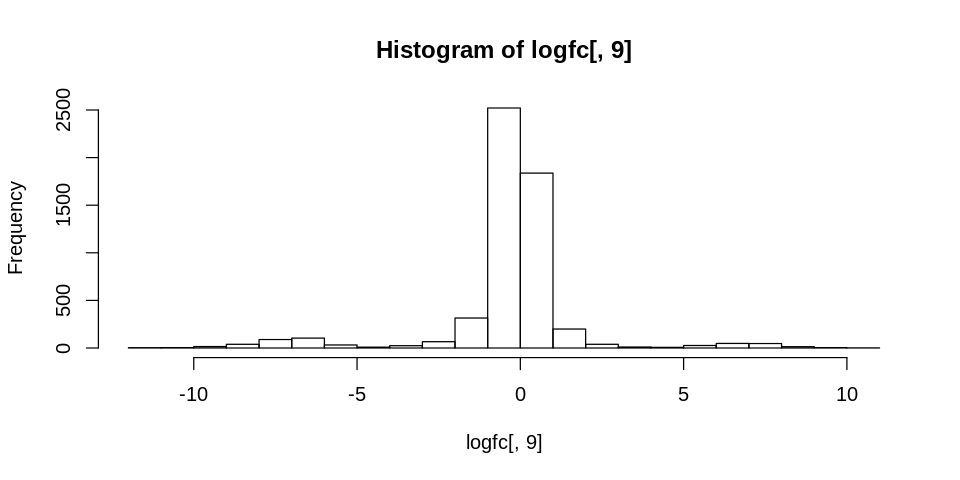

In [406]:
hist(logfc[,9], breaks = 20)

#### Plot graph with (V: Patients, E: Probesests)

In [598]:
## Create adjacency matrix (weight is number of shared ps)
adj_down <- sapply(top50_down,
                   function(x) sapply(top50_down,
                                      function(y) length(intersect(x, y))))
adj_up <- sapply(top50_up,
                 function(x) sapply(top50_up,
                                    function(y) length(intersect(x, y))))

In [698]:
## Spectral clustering
A_down <- adj_down
# A_up <- adj_up
A <- A_down/50 # Normalised similarity matrix

# epsilon-distance graph
THRESHOLD <- 0.2
A[A < THRESHOLD] <- 0
print(A)

     P037 P038 P039 P040 P041 P042 P043 P044 P046 P047 P048 P098 P100 P109 P115
P037 1.00 0.00    0    0    0 0.26 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P038 0.00 1.00    0    0    0 0.20 0.20    0 0.22 0.00 0.00 0.00    0    0 0.00
P039 0.00 0.00    1    0    0 0.00 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P040 0.00 0.00    0    1    0 0.00 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P041 0.00 0.00    0    0    1 0.00 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P042 0.26 0.20    0    0    0 1.00 0.26    0 0.30 0.00 0.20 0.00    0    0 0.30
P043 0.00 0.20    0    0    0 0.26 1.00    0 0.20 0.00 0.00 0.00    0    0 0.26
P044 0.00 0.00    0    0    0 0.00 0.00    1 0.00 0.00 0.00 0.00    0    0 0.00
P046 0.00 0.22    0    0    0 0.30 0.20    0 1.00 0.26 0.28 0.20    0    0 0.30
P047 0.00 0.00    0    0    0 0.00 0.00    0 0.26 1.00 0.20 0.00    0    0 0.00
P048 0.00 0.00    0    0    0 0.20 0.00    0 0.28 0.20 1.00 0.00    0    0 0.00
P098 0.00 0.00    0    0    0 0.00 0.00 

In [699]:
G <- graph_from_adjacency_matrix(A, mode = "undirected",
                                 weighted = TRUE, diag = FALSE)
# edge_attr_names(G)
relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
col <- ifelse(rownames(A) %in% relapse_pid, "lightsalmon", "olivedrab2")
V(G)$color <- col

pdf("~/Dropbox/temp/graph-top50_down1.pdf",
    width = 12, height = 12)
plot(G, vertex.size = 10, vertex.label.cex = 1, edge.width = E(G)$weight*10)
dev.off()

png 
  2

#### Spectral clustering

In [538]:
## Spectral clustering
adj <- raw_adj
A <- adj/50 # Normalised similarity matrix

# epsilon-distance graph
THRESHOLD <- 0.2
A[A < THRESHOLD] <- 0

In [549]:
D <- diag(apply(A, 1, sum)) # degree matrix

# Un-normalised laplacian
U <- D - A 

# Normalized Laplacian
"%^%" <- function(M, power)
  with(eigen(M), vectors %*% (values^power * solve(vectors)))
L <- (D %^% (-1/2)) %*% A %*% (D %^% (-1/2))

# Eigendecomposition
evL <- eigen(U, symmetric=TRUE)
Z <- evL$vectors
k <- 2
Z_small <- evL$vectors[,(ncol(evL$vectors)-k+1):ncol(evL$vectors)]

In [469]:
g <- graph_from_adjacency_matrix(adj, mode = "undirected", weighted = TRUE)
pdf("~/Dropbox/temp/graph.pdf")
plot(g, layout = layout_in_circle, vertex.size = 7, vertex.label.cex = .5)
dev.off()

png 
  2

### Investigate: Hyperdiploid

In [312]:
#' @param x vector
#' @param y vector
#' @param return matrix of n+2 interpolations (features x samples)
interpolate <- function(x, y, n) {
  stopifnot(length(x) == length(y))
  
  m <- n + 1
  sapply(0:m,
         function(i, x, y) (m-i)/m * x + i/m * y,
         x, y)
}

#' Calculates outer product of columns in two dataframes
#' For each pair of columns returns a set of interpolated points
#' If subsampling, unsampled original points will also be returned
#' along with simulated data
#' @param X dataframe with features x samples
#' @param Y dataframe with features x samples
#' @param f function to perform on the 2-tuple
#' @param n number of interpolations
#' @return dataframe
outer_prod <- function(X, Y, n = 3, n_subsample = 0) {
  if (n_subsample == 0) {
      mat <- do.call(
        cbind,
        lapply(
          X,
          function(x) do.call(cbind, lapply(Y, function(y) interpolate(x, y, n)))
        )
      )

    siml_names <- as.vector(t(outer(colnames(X), colnames(Y), paste, sep = "_")))
    siml_names1 <- paste(rep(siml_names, each = n + 2), 1:(n+2), sep = "_")

    V <- data.frame(mat)
    colnames(V) <- siml_names1
    rownames(V) <- rownames(X)
    return(V)
  
  } else {
    n_x <- ncol(X)
    n_y <- ncol(Y)
    idx_x <- sample(1:n_x, n_subsample)
    idx_y <- sample(1:n_y, n_subsample)
    X_unsampled <- X[, -idx_x, drop = F]
    Y_unsampled <- Y[, -idx_y, drop = F]
    
    mat <- do.call(
      cbind,
      lapply(
        X[, idx_x, drop = F],
        function(x) do.call(cbind, lapply(
          Y[, idx_y, drop = F],
          function(y) interpolate(x, y, n)
        ))
      )
    )
    
    siml_names <- as.vector(t(outer(
      colnames(X[, idx_x, drop = F]),
      colnames(Y[, idx_y, drop = F]),
      paste,
      sep = "_"
    )))
    siml_names1 <- paste(rep(siml_names, each = n + 2),
                         1:(n + 2),
                         sep = "_")

    V <- data.frame(mat, X_unsampled, Y_unsampled)
    colnames(V) <- c(siml_names1,
                     colnames(X_unsampled),
                     colnames(Y_unsampled))
    rownames(V) <- rownames(X)
    return(V)
    
  }
}

In [293]:
#' PCA space is defined using Yeoh (D0) data and rest of the datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
#' @param metadata_df metadata (need not be aligned with X)
plot_vectors_d0 <- function(X_d0, X_d8, X_siml, metadata_df,
                            cex = 3, n_pc = 3, main = NULL) {
  pca_obj <- prcomp(t(X_d0))
  d0_pca <- data.frame(pca_obj$x[,1:n_pc])
  
  d8_pca <- data.frame(predict(pca_obj, t(X_d8))[,1:n_pc])
  siml_pca <- data.frame(predict(pca_obj, t(X_siml))[,1:n_pc])

  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))

  subtype_pca <- cbind(d0_pca, d8_pca)
  colnames(subtype_pca) <- c(
    paste(colnames(subtype_pca)[1:n_pc], "A", sep = "_"),
    paste(colnames(subtype_pca)[(n_pc+1):(n_pc*2)], "B", sep = "_")
  )

  # Obtaining batch and class annotations
  label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
  batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])

  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:n_pc]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:n_pc, var_pc * 100)
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
#     geom_point(data = norm_pca, aes(x = PC1, y = PC2),
#                size = cex, shape = 17, col = "red") +
    geom_point(data = siml_pca, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  return(scatter_pca)
}

In [294]:
SUBTYPE <- "Hyperdiploid"
pid_subtype <- rownames(Y)[Y$subtype == SUBTYPE]
pid_normal <- rownames(Y)[Y$subtype == "Normal"]
drug_genes <- getLocalGenes(data[,pid_subtype], pid_remission)
db_genes <- setdiff(drug_genes, batch_genes)

normal <- data[db_genes, Y$subtype == "Normal"]
idx_d0 <- Y$class_info == "D0" & Y$subtype == SUBTYPE
idx_d8 <- Y$class_info == "D8" & Y$subtype == SUBTYPE
X_d0 <- data[db_genes, idx_d0, drop = F]
X_d8 <- data[db_genes, idx_d8, drop = F]
X_siml <- outer_prod(X_d0, normal, n = 3)

ax_vectors <- plot_vectors_d0(X_d0, X_d8, X_siml, Y)
wpath <- sprintf("~/Dropbox/temp/vectors_pca_d0_siml-%s.pdf", SUBTYPE)
ggsave(wpath, ax_vectors, width = 10, height = 5)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"


### Investigate: TEL-AML1

In [272]:
#' Plot vectors 2D
#' @param X dataframe with features x samples and containing
#' @param wrong_labels relapse remission and rem (bad prediction) labels
#' D0, D8 and 3 Normal patients (ordered correctly)
eval_vectors <- function(X, metadata_df, cex = 3, wrong_labels,
                         pc_labels = NULL, main = NULL) {
  # PCA
  pca_obj <- prcomp(t(X))
  pca_df <- data.frame(pca_obj$x[,1:2])
  n <- nrow(pca_df)
  d0_pca <- pca_df[1:((n-3)/2),]
  d8_pca <- pca_df[((n-1)/2):(n-3),]

  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))

  subtype_pca <- cbind(d0_pca, d8_pca)
  colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
  norm_pca <- pca_df[(n-2):n,]

  # Obtaining batch and class annotations
  batch <- as.factor(metadata_df[rownames(d8_pca), "batch_info"])
  pred_label <- wrong_labels[rownames(d8_pca), "label"]
  print(pred_label)

  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:4]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, fill = batch), shape = 21,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, fill = batch), shape = 22,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B, colour = pred_label),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.6) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 23, fill = "black") +
    xlab(pc_labels[1]) + ylab(pc_labels[2]) +
    scale_color_manual(values = c("tomato3", "darkolivegreen3", "purple"))
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [274]:
#' @param risk df from predict_relapse function that contains
#' label and risk of relapse prediction
#' @returns dataframe with one factor column containing levels of
#' relapse, remission, wrong prediction
classify_bad_prediction <- function(risk) {
  relapse_min_risk <- min(risk[risk$label == 1, "risk_relapse"])
  wrong_pred <- risk[, "label", drop = F]
  wrong_pred$label <- ifelse(wrong_pred$label == 0, "remission", "relapse")
  idx_remission_wrong <- risk$label == 0 & risk$risk_relapse > relapse_min_risk
  wrong_pred[idx_remission_wrong, "label"] <- "wrong prediction"
  return(wrong_pred)
}

subtype <- "TEL-AML1"
print(subtype)
pid_subtype <- rownames(Y)[Y$subtype == subtype]
pred_obj <- predict_relapse(pid_subtype, data, pid_remission, Y,
                        batch_genes = batch_genes)
pred_labels <- classify_bad_prediction(pred_obj[[1]])
eval_plot <- eval_vectors(pred_obj[[2]], Y, wrong_labels = pred_labels)
wpath <- "~/Dropbox/temp/eval_vectors-TEL-AML1.pdf"
ggsave(wpath, eval_plot, width = 12, height = 6)

[1] "TEL-AML1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P11

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

 [1] "remission"        "remission"        "wrong prediction" "wrong prediction"
 [5] "remission"        "wrong prediction" "relapse"          "remission"       
 [9] "wrong prediction" "wrong prediction" "remission"        "remission"       
[13] "wrong prediction" "remission"        "wrong prediction" "relapse"         
[17] "remission"        "wrong prediction" "remission"        "relapse"         
[21] "remission"        "wrong prediction" "relapse"          "relapse"         
[25] "remission"        "remission"        "remission"        "remission"       
[29] "remission"        "remission"        "remission"        "relapse"         
[33] "remission"        "remission"        "remission"        "remission"       
[37] "remission"        "remission"        "remission"       


#### Simulated data: MILE data
- Feature selection: Yeoh
- Simulate: MILE
- PCA: MILE
- Projection: Yeoh

In [395]:
subtypes1 <- setdiff(subtypes, "Others")
for (subtype in subtypes1) {
  print(subtype)
  # Feature selection
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  drug_genes <- getLocalGenes(data[,pid_subtype], pid_remission)
  db_genes <- setdiff(drug_genes, batch_genes)

  # Subset: MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  normal_mile <- X_mile[, pid_normal_mile]
  subtype_mile <- X_mile[, pid_subtype_mile]

  # Simulated data
  siml_mile <- outer_prod(subtype_mile[db_genes,],
                          normal_mile[db_genes,],
                          n_subsample = 30)

  # Subset: Yeoh
  subtype_norm <- data[db_genes, c(pid_subtype, pid_normal), drop = F]
  
  ax_vectors <- plot_vectors4(subtype_norm, Y, siml_mile, Y_mile)
  wpath <- sprintf("~/Dropbox/temp/vectors_yeoh_db_simlmile-%s.pdf", subtype)
  ggsave(wpath, ax_vectors, width = 10, height = 5)
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "Hyperdiploid"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "MLL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "T-ALL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "TEL-AML1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets ex

- Feature selection: MILE

In [379]:
#' @return vector of features corresponding to rownames of X
select_feat <- function(X, Y, alpha = 0.01, logfc = 2, expr = 6) {
  pvalues <- calc_ttest(cbind(X, Y), ncol(X))
  logfcs <- calc_logfc(X, Y)
  idx1 <- rowMeans(X) > expr | rowMeans(Y) > expr
  idx2 <- pvalues <= alpha
  idx3 <- logfcs > logfc
  idx <- idx1 & idx2 & idx3
  
  print(sprintf("No. of features (threshold) = %d", sum(idx1)))
  print(sprintf("No. of features (pvalue) = %d", sum(idx2)))
  print(sprintf("No. of features (logfc) = %d", sum(idx3)))
  print(sprintf("No. of features (all) = %d", sum(idx)))
  return(rownames(X)[idx])
}

In [397]:
VAR <- 3

subtypes1 <- setdiff(subtypes, "Others")
for (subtype in subtypes1) {
  print(subtype)
  # Subset: MILE
  pid_normal_mile <- rownames(Y_mile)[Y_mile$subtype == "Normal"]
  pid_subtype_mile <- rownames(Y_mile)[Y_mile$subtype == subtype]
  normal_mile <- X_mile[, pid_normal_mile]
  subtype_mile <- X_mile[, pid_subtype_mile]
  
  # Feature selection
  idx_drug <- select_feat(subtype_mile, normal_mile)
  idx_batch <- rownames(subtype_mile)[
    rowVars(subtype_mile) > VAR | rowVars(normal_mile) > VAR
  ]
  idx <- setdiff(idx_drug, idx_batch)
  print(sprintf("No. of features (wo noise) = %d", length(idx)))
  
  # Simulated data
  siml_mile <- outer_prod(subtype_mile[idx,],
                          normal_mile[idx,],
                          n_subsample = 20)

  # Subset: Yeoh
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  subtype_norm <- data[idx, c(pid_subtype, pid_normal), drop = F]
  
  ax_vectors <- plot_vectors4(subtype_norm, Y, siml_mile, Y_mile)
  wpath <- sprintf("~/Dropbox/temp/vectors_mile_db1_simlmile-%s.pdf", subtype)
  ggsave(wpath, ax_vectors, width = 10, height = 5)
}

[1] "BCR-ABL"
[1] "No. of features (threshold) = 4613"
[1] "No. of features (pvalue) = 3520"
[1] "No. of features (logfc) = 429"
[1] "No. of features (all) = 325"
[1] "No. of features (wo noise) = 38"
[1] "E2A-PBX1"
[1] "No. of features (threshold) = 4736"
[1] "No. of features (pvalue) = 3206"
[1] "No. of features (logfc) = 574"
[1] "No. of features (all) = 452"
[1] "No. of features (wo noise) = 43"
[1] "Hyperdiploid"
[1] "No. of features (threshold) = 4761"
[1] "No. of features (pvalue) = 3222"
[1] "No. of features (logfc) = 593"
[1] "No. of features (all) = 481"
[1] "No. of features (wo noise) = 56"
[1] "MLL"
[1] "No. of features (threshold) = 4629"
[1] "No. of features (pvalue) = 3486"
[1] "No. of features (logfc) = 425"
[1] "No. of features (all) = 325"
[1] "No. of features (wo noise) = 26"
[1] "T-ALL"
[1] "No. of features (threshold) = 4610"
[1] "No. of features (pvalue) = 3705"
[1] "No. of features (logfc) = 408"
[1] "No. of features (all) = 291"
[1] "No. of features (wo noise) =

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [12]:
# Prediction (Batch genes) -------------------------------------------------------
## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- data[,pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)

#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")
# welch_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "welch")
# kruskal_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "kruskal")

# Selecting by pvalue threshold
batch_genes <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
# welch_genes <- names(welch_pvalue)[welch_pvalue < 0.05 & !is.na(welch_pvalue)]
# kruskal_genes <- names(kruskal_pvalue)[kruskal_pvalue < 0.05 & !is.na(kruskal_pvalue)]
length(batch_genes)

[1] "No. of NaNs =" "16"           


[1] 2565

#### Plot: UpSet

In [ ]:
# list_batch_genes <- list(anova = batch_genes, welch = welch_genes,
#                          kruskal = kruskal_genes)

# upset(fromList(list_batch_genes),
#       nsets = length(list_selected),
#       nintersects = NA,
#       order.by = "freq")
# upset_plot <- recordPlot()
# upset_plot
# save_fig(upset_plot, "dump/upset-batch_genes.pdf",
#          width = 8, height = 8)

### Drug genes

Constant: Subtype, remission

In [6]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, pid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  pid_idx <- intersect(pid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[,pid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission)/2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  
  # Median paired log-FC
  paired_logfc <- X_subtype_remission[,-(1:n_pairs)] -
    X_subtype_remission[,1:n_pairs] # D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(X_subtype_remission[,1:n_pairs])
  d8_mu <- rowMeans(X_subtype_remission[,-(1:n_pairs)])
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  feat <- intersect(feat_p, feat_log2fc)
  return(feat)
}

#### Drug responsive genes: Hyperdiploid

In [160]:
pid_subtype <- rownames(Y)[Y$subtype == "Hyperdiploid"]
X_hyp <- X[,pid_subtype]
hyp_genes <- getLocalGenes(X_hyp, pid_remission)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"


### Marker genes

In [160]:
marker_genes <- c("EBF1", "IKZF1", "MSH6", "BTG1", "NR3C1",
                   "CDKN2A", "CDKN2B", "PAX5", "ETV6")
subset_marker_genes <- marker_genes[marker_genes %in% rownames(ahypall_norm)]
# fltrmg_ahypall_norm <- ahypall_norm[subset_marker_genes,] # marker genes
fltrmg_aall_hyp_norm <- aall_hyp_norm[subset_marker_genes,] # marker genes

In [8]:
#' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
calcERM <- function(response_df, normal_df) {
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n,]
  d8_df <- response_df[-(1:n),]
  stopifnot(substring(rownames(d8_df),1,4) == substring(rownames(d0_df),1,4))
  
  # Calculate centroids
  leuk_centroid <- apply(d0_df, 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  return(features_df)
}

Setting levels: control = Good, case = Poor
Setting levels: control = Good, case = Poor


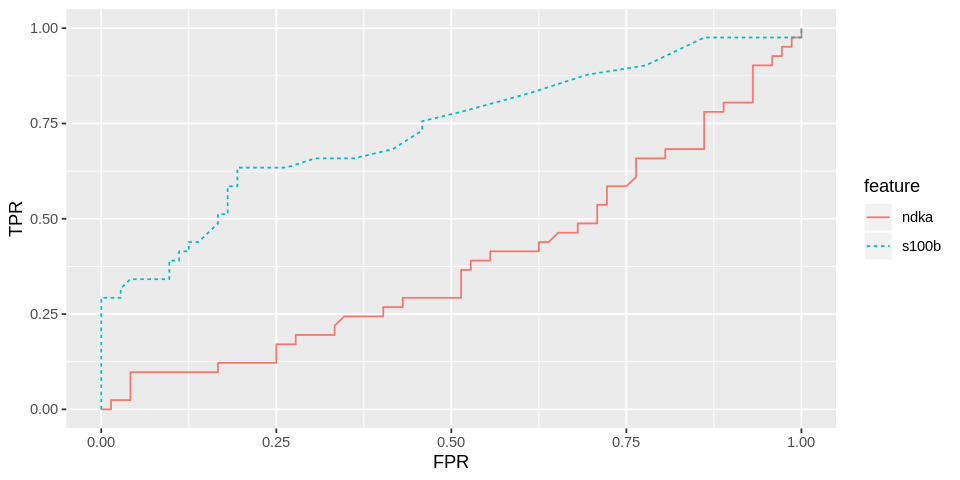

In [9]:
#' @param y vector of labels
#' @param list_x list of vectors containing prediction scores
#' @param bigger.positive logical vector indicating if bigger
#' values have positive labels (e.g. relapse)
plot_proc <- function(y, list_x, x_names, bigger.positive) {
  n <- length(list_x)
  colours <- ggplot_palette(n)
  names(colours) <- x_names
  directions <- ifelse(bigger.positive, "<", ">") # TRUE: controls "<" cases
  
  roc_obj <- roc(y, list_x[[1]],
                 direction = directions[1],
                 ret = "coords")
  roc_df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  
  nrow1 <- nrow(roc_df)
  roc_ord <- roc_df[nrow1:1,] # reverse order of df
  
  gen_addon <- function(i) {
    roc_obj <- roc(y, list_x[[i]], 
                   direction = directions[i],
                   ret = "coords")
    roc_df <- data.frame(
      FPR = 1 - roc_obj$specificities,
      TPR = roc_obj$sensitivities
    )
    
    return(roc_df[nrow(roc_df):1,])
  }
  
  roc_dfs <- lapply(seq(2, n), gen_addon)
  nrows <- sapply(roc_dfs, nrow)
  all_df <- rbind(roc_ord, do.call(rbind, roc_dfs))
  nrows_all <- c(nrow1, nrows)
  feature <- rep(x_names, nrows_all)
  plot_df <- cbind(feature, all_df)
  
  ax_roc <- ggplot(plot_df,
                   aes(FPR, TPR, col = feature, lty = feature),
                   lwd = 3) +
    geom_line()

  return(ax_roc)
}

x_names <- c("s100b", "ndka")
ax_roc <- plot_proc(aSAH$outcome, aSAH[,x_names], x_names, c(T,F))
ax_roc

In [10]:
#' @param Y metadata_df that has rownames corresponding to the
#'colnames of the data
plotPrediction <- function(results, metadata_df, yeoh_label) {
  # Feature selection and rank
  y <- as.factor(metadata_df[rownames(results), "label"])
  features1 <- results[, c("erm1_ratio2", "l2norm_ratio2"), drop = F] # relapse: smaller
  features2 <- results[, "angle_d0d8_normal", drop = F] # relapse: bigger
  
  # MRD
  pid_idx <- substr(rownames(results), 1, 4)
  mrd <- yeoh_label[pid_idx, "d33_mrd"]
  names(mrd) <- pid_idx
  
  #' NB: Changed from previous calculation! Previous calculations used
  #' pct of samples strictly below value. Calculated  pct locally
  #' Calculates risk of relapse using pct of samples via ranks
  #' @param X1 df of features where smaller values indicate relapse
  #' @param X2 df of features where bigger values indicate relapse
  #' @param mrd vector of  with order matching rownames of X1 and X2
  #' @return df containing pid, label, risk of relapse, and p of indv features
  calc_pct_samples <- function(X1 = NULL, X2 = NULL, mrd) {
    # TODO: Global  will be better!
    # Calculating pct samples for mrd
    n_le_mrd <- rank(mrd, na.last = T, ties.method = "max")
    pct_le_mrd <- n_le_mrd / sum(!is.na(mrd))
    pct_le_mrd[is.na(mrd)] <- NA # NAs are given ranks as well
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      n_le <- apply(X2, 2, rank, ties.method = "max") # ranks smallest as 1
      pct_le <- n_le / nrow(X2)
      pct_all <- cbind(pct_le, mrd = pct_le_mrd)
    } else if (is.null(X2)) {
      n_ge <- apply(-X1, 2, rank, ties.method = "max") # ranks biggest as 1
      pct_ge <- n_ge / nrow(X1)
      pct_all <- cbind(pct_ge, mrd = pct_le_mrd)
    } else {
      n_le <- apply(X2, 2, rank, ties.method = "max") # ranks smallest as 1
      pct_le <- n_le / nrow(X2)
      n_ge <- apply(-X1, 2, rank, ties.method = "max") # ranks biggest as 1
      pct_ge <- n_ge / nrow(X1)
      pct_all <- cbind(pct_ge, pct_le, mrd = pct_le_mrd)
    }
    
    p <- rowMeans(pct_all, na.rm = T) # final p: average all pct
    
    # Combine with idx,  and label
    pct_samples <- cbind(
      pid = rownames(pct_all),
      label = as.factor(metadata_df[rownames(pct_all), "label"]),
      p,
      pct_all
    )
    
    return(pct_samples)
  }
  
  #' Calculate risk of relapse as percentage of relapse cases with
  #' scores that are better than or equal to the current score
  #' @param X1 df of features where smaller values indicate relapse
  #' @param X2 df of features where bigger values indicate relapse
  #' @param  vector of  with order matching rownames of X1 and X2
  #' @return df containing pid, label, risk of relapse, and p of indv features
  calc_p_relapse <- function(X1 = NULL, X2 = NULL,
                               mrd, Y, yeoh_label) {
    #' Pct of relapse cases with worse than or equal to the current score
    #' Bigger values indicate relapse
    #' @param x vector of feature scores from diff samples
    #' @param x_relapse vector of feature scores from relapse samples
    calc_pct_relapse_x <- function(x, x_relapse) {
      sapply(x, function(x_i) sum(x_i >= x_relapse)/length(x_relapse))
    }
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      X <- X2
    } else if (is.null(X2)) {
      X <- -X1 # reverse order - bigger values now indicate relapse
    } else {
      X <- cbind(-X1, X2)
    }
    
    # Subset relapse cases
    Y1 <- Y[rownames(X),]
    X_relapse <- X[Y1$label == 1,]

    pct_relapse <- mapply(calc_pct_relapse_x,
                          data.frame(X),
                          data.frame(X_relapse))
    rownames(pct_relapse) <- rownames(X)
    
    # Risk of relapse of is calculated with reference to global set of values
    # Assumption: Y only has rownames that are present in cleaned data
    idx_relapse <- Y$class_info == "D0" & Y$label == 1
    pid_relapse <- substr(rownames(Y)[idx_relapse], 1, 4)
    mrd_relapse <- yeoh_label[pid_relapse, "d33_mrd"]
    global_mrd_relapse <- mrd_relapse[!is.na(mrd_relapse)]
             
    pct_relapse_mrd <- sapply(
      mrd,
      function(x_i) sum(x_i >= global_mrd_relapse) / length(global_mrd_relapse)
    )
    
    pct_relapse_all <- cbind(pct_relapse, pct_relapse_mrd)
    p <- apply(pct_relapse_all, 1, mean, na.rm = T)
    
    p_relapse <- data.frame(
      pid = rownames(pct_relapse_all),
      label = as.factor(metadata_df[rownames(pct_relapse_all), "label"]),
      p,
      pct_relapse_all
    )
    
    return(p_relapse)
  }
             
  #' Calculate probability of remission as percentage of remission cases with
  #' scores that are worse than or equal to the current score
  #' @param X1 df of samples x features where smaller values indicate relapse
  #' @param X2 df of samples x features where bigger values indicate relapse
  #' @param  vector of  with order matching rownames of X1 and X2
  #' @return if test.set = F returns df containing pid, label,
  #' risk of relapse, and p of indv features. if test.set = T returns list
  #' of p_remission_train and p_remission_test
  calc_p_remission <- function(X1 = NULL, X2 = NULL,
                               mrd, Y, yeoh_label,
                               test.set = F) {
    #' Pct of remission cases with worse than or equal to the current score
    #' Bigger values indicate it being worse
    #' @param x vector of feature scores from diff samples
    #' @param x_remission vector of feature scores from relapse samples
    calc_pct_remission_x <- function(x, x_remission) {
      sapply(x, function(x_i) sum(x_i <= x_remission)/length(x_remission))
    }
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      X <- X2
    } else if (is.null(X2)) {
      X <- -X1 # reverse order - bigger values now indicate relapse
    } else {
      X <- cbind(-X1, X2)
    }
             
    Y1 <- Y[rownames(X), , drop = F]
    
    if (test.set) {
      idx_train <- Y1$batch %in% 1:5
      X_train <- X[idx_train, , drop = F]
      X_test <- X[!idx_train, , drop = F]
      Y_train <- Y1[rownames(X_train), , drop = F]
      X_train_remission <- X_train[Y_train$label == 0, , drop = F]
      
      pct_rem_train <- mapply(calc_pct_remission_x,
                              data.frame(X_train),
                              data.frame(X_train_remission))
      
      # X_train has only one row -> pct_rem_train: vector
      if (!is.matrix(pct_rem_train))
        pct_rem_train <- matrix(pct_rem_train, 1,
                                dimnames =  list(NULL, names(pct_rem_train)))
      
      rownames(pct_rem_train) <- rownames(X_train)
      
      pct_rem_test <- mapply(calc_pct_remission_x,
                             data.frame(X_test),
                             data.frame(X_train_remission))
      rownames(pct_rem_test) <- rownames(X_test)
      
      # Prob of remission is calculated with reference to global set of values
      # Assumption: Y only has rownames that are present in cleaned data
      idx_rem_train <- Y$class_info == "D0" & Y$label == 0 & Y$batch %in% 1:5
      pid_rem_train <- substr(rownames(Y)[idx_rem_train], 1, 4)
      mrd_rem_train <- yeoh_label[pid_rem_train, "d33_mrd"]
      global_mrd_rem_train <- mrd_rem_train[!is.na(mrd_rem_train)]
      
      pct_rem_mrd <- sapply(
        mrd,
        function(x_i) sum(x_i <= global_mrd_rem_train) / length(global_mrd_rem_train)
      ) # pct of remission with a worse score
      
      pct_rem_mrd_train <- pct_rem_mrd[idx_train]
      pct_rem_mrd_test <- pct_rem_mrd[!idx_train]
      
      pct_rem_train_all <- cbind(pct_rem_train, pct_rem_mrd_train)
      pct_rem_test_all <- cbind(pct_rem_test, pct_rem_mrd_test)

      p_train <- apply(pct_rem_train_all, 1, mean, na.rm = T)
      p_test <- apply(pct_rem_test_all, 1, mean, na.rm = T)
      
      p_wo_train <- apply(pct_rem_train, 1, mean, na.rm = T)
      p_wo_test <- apply(pct_rem_test, 1, mean, na.rm = T)
      
      p_rem_train <- data.frame(
        pid = rownames(pct_rem_train_all),
        label = as.factor(Y[rownames(pct_rem_train_all), "label"]),
        p = p_train,
        p_wo = p_wo_train, # OPTION: DELETE WHEN PLOTTING
        pct_rem_train_all
      )
      
      p_rem_test <- data.frame(
        pid = rownames(pct_rem_test_all),
        label = as.factor(Y[rownames(pct_rem_test_all), "label"]),
        p = p_test,
        p_wo = p_wo_test, # OPTION: DELETE WHEN PLOTTING
        pct_rem_test_all
      )
    
      return(list(p_rem_train, p_rem_test))
    } else {
      X_remission <- X[Y1$label == 0,]
      pct_remission <- mapply(calc_pct_remission_x,
                              data.frame(X),
                              data.frame(X_remission))
      rownames(pct_remission) <- rownames(X)

      # Prob of remission is calculated with reference to global set of values
      # Assumption: Y only has rownames that are present in cleaned data
      idx_remission <- Y$class_info == "D0" & Y$label == 0
      pid_remission <- substr(rownames(Y)[idx_remission], 1, 4)
      mrd_remission <- yeoh_label[pid_remission, "d33_mrd"]
      global_mrd_remission <- mrd_remission[!is.na(mrd_remission)]
      pct_remission_mrd <- sapply(
        mrd,
        function(x_i) sum(x_i <= global_mrd_remission) / length(global_mrd_remission)
      ) # pct of remission with a worse score

      pct_remission_all <- cbind(pct_remission, pct_remission_mrd)
      p_wo <- apply(pct_remission, 1, mean, na.rm = T)
      p <- apply(pct_remission_all, 1, mean, na.rm = T)

      p_remission <- data.frame(
        pid = rownames(pct_remission_all),
        label = as.factor(metadata_df[rownames(pct_remission_all), "label"]),
        p = p,
        p_wo = p_wo, # OPTION: DELETE WHEN PLOTTING
        pct_remission_all
      )

      return(p_remission)
    }
  }
  
  pct_samples <- calc_pct_samples(features1, features2, mrd)
  pct_relapse <- calc_p_relapse(features1, features2, mrd,
                                Y = metadata_df, yeoh_label)
  p_remission <- calc_p_remission(
    features1, features2, mrd,
    Y = metadata_df, yeoh_label,
    test.set = F # OPTION!
  )

  # OPTION: Which method of calculating risk of relapse?
  pred <- p_remission
  
  # Return final predictions
  p <- pred[, c("p", "p_wo"), drop = F]
  return(p)
  
  # Plot: Jitter - Features and risk_relapse
  X_y <- cbind(
    features1[rownames(pred), , drop = F],
    features2[rownames(pred), , drop = F],
    p = pred$p,
    label = pred$label
  )
             
  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
             
  ax_jitter <- ggplot(long_X_y,
                      aes(feature, value, colour = label)) +
    geom_point(position = position_jitterdodge(), cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 1, scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
             
  # Plot: Parallel coordinates - Pct
  long_pred <- melt(pred, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_pred,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  # PLOT: CDF
  emp_cdf <- ggplot(pred,
                    aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  # PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- pred[order(pred$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
                                
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
                                
  # Plot: ROC
  erm1 <- results[rownames(pred), "erm1"] # depends on p_relapse
  pid1 <- substr(rownames(pred), 1, 4)
  mrd1 <- mrd[pid1]
  pred_x <- cbind(pred, erm = erm1, mrd = mrd1) # subset mrd
  pred_x_sub <- pred_x[!is.na(pred_x$mrd), , drop = F]
  
  x_names <- c("erm", "mrd", "p")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (length(table(pred_x_sub$label)) > 1) {
    ax_roc <- plot_proc(pred_x_sub$label, pred_x_sub[,x_names],
                        x_names, bigger.positive)
    
    ## T-test
    # Both group sizes must be > 1
    if (min(table(pred$label)) > 1) {
      list_rr <- split(pred$p, pred$label)
      ttest <- t.test(list_rr[[1]], list_rr[[2]])
      p_title <- sprintf("p-value = %.5f", ttest$p.value)      
    } else {
      p_title <- ""
    }
    
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                 ncol = 2, rel_widths = c(1.8, 1))
  } else{
    p_title <- "" # unable to perform t-test
    ax2 <- ax_parallel # unable to plot ROC
  }
                                
  # Plot: T-test           
  ax_ttest <- ggplot(pred,
                     aes(label, p, color = label)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 0.5))
                                
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(pred_x_sub,
                  aes(p, log10(mrd), colour = label)) +
    geom_point(cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))

#   ax1 <- plot_grid(ax_jitter, emp_cdf, ax_rr_or,
#                    ncol = 3, rel_widths = c(2.5, 1.2, 1.3))
#   ax2 <- plot_grid(ax_parallel, mrd_p,
#                    ncol = 2, rel_widths = c(2.5, 1))
  
  # p-value as title
  ax_jitter <- ax_jitter +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 1.0))  
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)

#   return(risk_relapse)
  
  # Return final predictions
  print(pred)
  p <- pred[, "p", drop = F]
  return(p)
}

In [11]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_relapse <- function(pid, X, pid_remission, metadata_df,
                            batch_genes = NULL, class_genes = NULL, wpath = NULL) {
  # Check that pid provided is paired
  n <- length(pid)
  pid_substr <- substring(pid, 1, 4)
  if (!all(pid_substr[1:(n/2)] == pid_substr[((n/2)+1):n]))
    stop("Patient IDs are not paired..")
  
  X_subtype <- X[, pid]
  
  # Get subset of genes
  if (is.null(class_genes)) {
    class_genes <- getLocalGenes(X_subtype, pid_remission)
  }
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  pid_norm <- paste0("N0", c(1,2,4))
  X_fltr_subtype_norm <- X[selected_genes, c(pid, pid_norm)]
  
  idx <- 1:(ncol(X_fltr_subtype_norm)-3)
  response <- t(X_fltr_subtype_norm)[idx,]
  normal <- t(X_fltr_subtype_norm)[-idx,]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
#   print("Results!")
#   print(head(results))
  
  label <- as.factor(metadata_df[rownames(results), "label"])
  
  ax_prediction <- plotPrediction(results, metadata_df, yeoh_label)
  
#   # Plot: Angle v.s. l2norm
#   scatter_plot <- ggplot(results) +
#     geom_point(aes(x = l2norm_d0_d8, y = angle_nl_nd8, col = label),
#                show.legend = F) +
#     scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  if (!is.null(wpath))
    ggsave(wpath, ax_prediction, width = 7, height = 7)
  
  return(ax_prediction)
}

#### Plotting: Features, ROC, T-test

In [985]:
for (subtype in subtypes1) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  wpath <- sprintf("~/Dropbox/temp/results_test-%s.pdf", subtype)
  p <- predict_relapse(pid_subtype, data, pid_remission, Y,
                       batch_genes = batch_genes)
  print(p)
  break
#   ggsave(wpath, ax_roc, width = 12, height = 7)
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
        erm1_ratio2 l2norm_ratio2 angle_d0d8_normal
P053_D8   0.6666667     0.6666667         0.6666667
P054_D8   1.0000000     1.0000000         1.0000000
P055_D8   0.3333333     0.3333333         0.3333333
P056_D8   0.0000000     0.3333333         0.0000000
P057_D8   0.0000000     0.0000000         0.0000000
[1] "matrix"


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


$`0`
[1] 0.4644608 0.5000000

$`1`
[1] 0.003676471 0.083333333 0.000000000

                  p
P134_D8 0.003676471
P152_D8 0.083333333
P170_D8 0.464460784
P175_D8 0.500000000
P184_D8 0.000000000


### Yeoh (2018): Global ERM
- Feature selection: Top 500 down-regulated probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)

In [5]:
### Yeoh (2018): Prediction

## Feature selection
D0 <- data[, 1:201]
D8 <- data[, 202:402]

if (!all(substr(colnames(D0), 1, 4) == substr(colnames(D8), 1, 4)))
  stop("pids do not match!")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

In [13]:
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(data[ps_wilcox, 1:402])
normal <- t(data[ps_wilcox, 403:405])
results <- calcERM(response, normal)
erm <- results[,"erm1", drop = F]

### Overall ROC

In [1111]:
# Collate final prediction from each subtype
calc_p <- function(subtype) {
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  # SPECIFY PREDICT FUNCTION
  predict_relapse(pid_subtype, data, pid_remission, Y,
                  batch_genes = batch_genes)
}

# NO TRAIN/TEST SPLIT
list_all <- lapply(subtypes1, calc_p)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-f

In [1113]:
## Remove subtype: Hypodiploid and Others from Yeoh (2018)
idx <- !(Y[rownames(erm), "subtype"] %in% c("Hypodiploid", "Others"))
erm_sub <- erm[idx, , drop = F]

## NO TRAIN/TEST SPLIT
all_p <- do.call(rbind, list_all)
p_ord <- all_p[order(rownames(all_p)), , drop = F] # sort rows
idx_pat <- substr(rownames(p_ord), 1, 4)
all_y <- yeoh_label[idx_pat, c("d33_mrd", "label")]

print(tail(rownames(p_ord))) # check that all rows are ordered the same!!!
print(tail(rownames(erm_sub)))
print(tail(rownames(all_y)))
p_y <- cbind(erm_sub,
             p_ord,
             all_y)
print(p_y)

# p_y_sub <- p_y[!is.na(p_y$d33_mrd),]
# ax_roc <- plot_proc(p_y_sub$label, p_y_sub[, 1:3],
#                     c("ERM", "p", "MRD"), c(F, F, T))
# ggsave("~/Dropbox/temp/roc-all.pdf", ax_roc,
#        height = 6, width = 6.5)

[1] "P190_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8" "P211_D8"
[1] "P190_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8" "P211_D8"
[1] "P190" "P195" "P196" "P207" "P208" "P211"
               erm1           p       p_wo d33_mrd label
P001_D8  72.4693088 0.583491162 0.69696970 0.00050     0
P004_D8  26.0110292 0.573390152 0.75757576 0.08000     0
P005_D8  56.1740685 0.818339646 0.78787879 0.00010     0
P007_D8  19.2138667 0.272569444 0.33333333 0.00400     1
P008_D8  80.4078328 0.931976010 0.93939394 0.00010     0
P009_D8 -50.6083148 0.090909091 0.09090909      NA     0
P010_D8   5.3284511 0.477430556 0.33333333 0.00010     0
P011_D8  87.1851519 0.878787879 0.87878788      NA     0
P012_D8  15.2062574 0.401672980 0.45454545 0.00050     0
P013_D8  70.3467926 0.613794192 0.51515152 0.00010     0
P014_D8  40.6700798 0.560763889 0.44444444 0.00010     0
P015_D8  30.2995227 0.239741162 0.25252525 0.00070     0
P016_D8  23.7576810 0.341066919 0.15151515 0.00010     0
P017_D8  62.0457473 0.780460

### Breakdown of train and test sets

In [960]:
## Breakdown of train and test sets
idx1 <- Y$batch_info %in% 1:5 & Y$class_info == "D0"
idx2 <- !(Y$batch_info %in% 1:5) & Y$class_info == "D0"
Y_train <- Y[idx1,]
Y_test <- Y[idx2,]

tab_train <- table(Y_train$subtype, Y_train$label)
tab_test <- table(Y_test$subtype, Y_test$label)
print(xtable(tab_test))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Thu Nov 12 01:34:19 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   2 &   3 \\ 
  E2A-PBX1 &   2 &   2 \\ 
  Hyperdiploid &  22 &   4 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   5 \\ 
  Normal &   0 &   0 \\ 
  Others &  37 &  16 \\ 
  T-ALL &   2 &   1 \\ 
  TEL-AML1 &  13 &   1 \\ 
   \hline
\end{tabular}
\end{table}


#### Prediction (D-B): All subtypes

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16] "angle_d0_normal"     "angle_d8_normal"     "l2norm_d0_normal"   
[19] "l2norm_d8_normal"    "l2norm_ratio1" 

Setting levels: control = 0, case = 1


[1] 2


Setting levels: control = 0, case = 1


[1] 3


Setting levels: control = 0, case = 1
Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16] "angle_d0_normal"     "angle_d8_normal"     "l2norm_d0_normal"   
[19] "l2norm_d8_normal"    "l2norm_ratio1"       "l2norm_ratio2"      
[22] "l2norm_diff"         "l2norm_d

ERROR: Error in roc.default(x, predictor, plot = TRUE, ...): 'response' must have two levels


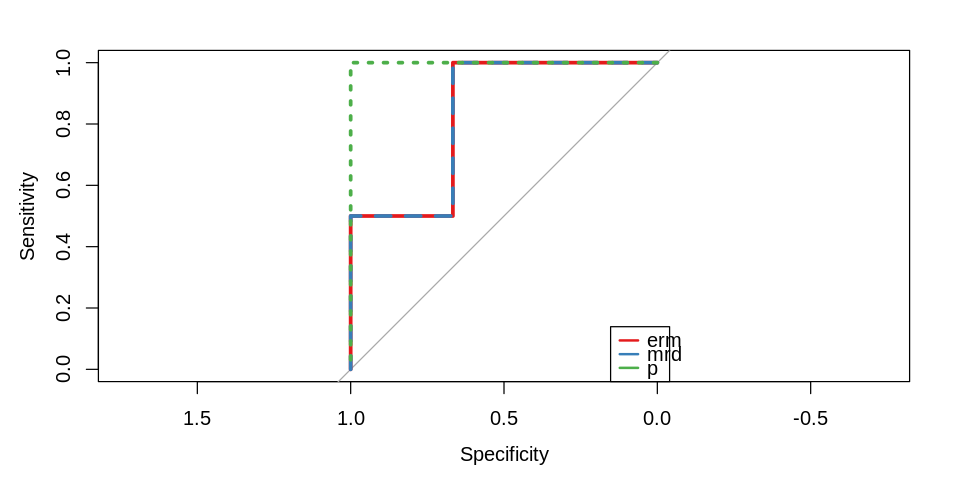

In [736]:
for (subtype in subtypes) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  wpath <- sprintf("~/Dropbox/temp/risk_relapse_long-%s.pdf", subtype)
  predict_relapse(pid_subtype, data, pid_remission, Y,
                  batch_genes = batch_genes, wpath = wpath)
}

#### Relapse prediction (Hyperdiploid)

In [738]:
subtype <- "Hyperdiploid"
wpath1 <- "~/Dropbox/temp/vectors_label-Hyperdiploid.pdf"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
avg_p <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                         batch_genes = batch_genes,
                         wpath1 = wpath1)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


#### Prediction (chr median): ERM3 (PC2)

In [569]:
## Prediction (all subtypes)
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))
subtype_factor <- metadata_df[colnames(all_median), "subtype", drop = F]
for (subtype in subtypes) {
  subtype_pid <- rownames(subtype_factor)[subtype_factor == subtype]
  pid_norm <- paste0("N0", c(1,2,4))
  pid <- c(subtype_pid, pid_norm)
  wpath <- sprintf("~/Dropbox/temp/prediction_chr_median_pc2-%s.pdf", subtype)
  predict_relapse_pca(all_median[,pid], wpath = wpath)
}

[1] "No. of PCs: 5"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "No. of PCs: 2"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of PCs: 7"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of PCs: 2"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of PCs: 4"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

[1] "No. of PCs: 5"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of PCs: 5"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

#### Prediction (chr median)

In [450]:
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]
pid_allhyp <- convert_list_pid(list(colnames(hyperdiploid)))[[1]]
print(pid_allhyp)

list_prediction <- predict_relapse(pid_allhyp, hypall_norm_median, pid_remission,
                                   class_genes = rownames(hypall_norm_median))

ERROR: Error in convert_list_pid(list(colnames(hyperdiploid))): could not find function "convert_list_pid"


#### Predict all subtypes (chr median)

In [494]:
# Factor to split data
subtypes_yeoh <- splitSubtype(all_median, metadata_df)

all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]
# list_drug_genes <- list()
for (subtype in subtypes) {
  pid_subtype <- colnames(subtypes_yeoh[[subtype]])
  wpath <- sprintf("~/Dropbox/temp/prediction_chr_median-%s.pdf", subtype)
  predict_relapse(pid_subtype, all_median, pid_remission, 
                  class_genes = rownames(all_median), wpath = wpath)
}

# # Save list of drug responsive genes
# names(list_drug_genes) <- subtypes
# saveRDS(list_drug_genes, "temp/list_drug_genes.rds")

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8" "P176_D8" "P178_D8" "P182_D8"
[71] "P183_D8" "P189_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8"
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0" "P199_D0" "P200_D0" "P201_D0" "P202_D0"
 [71] "P203_D0" "P204_D0" "P205_D0" "P206_D0" "P209_D0" "P210_D0" "P212_D0"
 [78] "P213_D0" "P214_D0" "P215_D0" "P216_D0" "P217_D0

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8" "P121_D8" "P127_D8" "P135_D8"
[71] "P136_D8" "P147_D8" "P156_D8" "P165_D8" "P166_D8" "P172_D8" "P185_D8"
[78] "P188_D8"
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

#### Prediction (marker genes)

In [404]:
# pid_remission <- rownames(metadata_df)[metadata_df$label == 0]
# n_hypall <- ncol(fltrmg_ahypall_norm)
# pid_hypall <- colnames(fltrmg_ahypall_norm)[-((n_hypall-2):n_hypall)]

predict_relapse(pid_hypall, fltrmg_ahypall_norm, pid_remission,
                class_genes = rownames(fltrmg_ahypall_norm),
                wpath = "~/Dropbox/temp/prediction.pdf")

[1] "No. of selected genes = " "4"                       
[1] "No. of final genes = " "4"                    
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

P037_D8    P038_D8    P039_D8    P040_D8    P041_D8    P042_D8    P043_D8 
0.87932331 0.46165414 0.44849624 0.49454887 0.35639098 0.80701754 0.06691729 
   P044_D8    P046_D8    P047_D8    P048_D8    P098_D8    P100_D8    P109_D8 
0.87819549 0.27086466 0.19849624 0.53402256 0.60639098 0.63928571 0.15902256 
   P115_D8    P129_D8    P133_D8    P138_D8    P139_D8    P140_D8    P148_D8 
0.40350877 0.68458647 0.60639098 0.21823308 0.35639098 0.23139098 0.12612782 
   P153_D8    P154_D8    P155_D8    P157_D8    P159_D8    P162_D8    P164_D8 
0.42218045 0.21165414 0.55375940 0.57349624 0.25695489 0.47086466 0.68364662 
   P169_D8    P176_D8    P178_D8    P182_D8    P183_D8    P189_D8    P195_D8 
0.23139098 0.23796992 0.33045113 0.61334586 0.29824561 0.88703008 0.36842105 
   P196_D8    P207_D8    P208_D8 
0.30263158 0.64962406 0.29755639

#### Plot: Upset (intersection of drug response genes)

In [ ]:
# ## List of selected genes from each subtype
# names(list_selected) <- subtypes
# upset(fromList(list_selected),
#       nsets = length(list_selected),
#       nintersects = NA,
#       order.by = "freq")
# upset_plot <- recordPlot()
# upset_plot
# save_fig(upset_plot, "dump/upset-selected_genes.pdf",
#          width = 10, height = 5)

# # Subset of intersected genes
# subset_selected <- list_selected[-c(1,4)]
# intersect_genes <- Reduce(intersect, subset_selected)

## Summary statistics

In [284]:
##### CHR SUMMARY STATISTICS #####
### NORMAL
list_chr_norm <- split.data.frame(normal, ps_chr)
## MEAN
norm_mean <- t(sapply(list_chr_norm, colMeans))[1:22,]
## MEDIAN
norm_median <- t(sapply(list_chr_norm, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
norm_nozero_median <- t(sapply(list_chr_norm, apply, 2,
                                  function(vec) median(vec[vec != 0])))[1:22,]
## PCT ZERO
norm_pct_zero <- t(sapply(list_chr_norm, apply, 2,
                     function(vec) sum(vec == 0)/length(vec)))[1:22,]

### HYPERDIPLOID
list_chr_hyp <- split.data.frame(hyperdiploid, ps_chr)
## MEAN
hyp_mean <- t(sapply(list_chr_hyp, colMeans))[1:22,]
## MEDIAN
hyp_median <- t(sapply(list_chr_hyp, apply, 2, median))[1:22,]
## ## MEDIAN (NO ZERO)
hyp_nozero_median <- t(sapply(list_chr_hyp, apply, 2,
                            function(vec) median(vec[vec != 0])))[1:22,]
## PCT ZERO
hyp_pct_zero <- t(sapply(list_chr_hyp, apply, 2,
                         function(vec) sum(vec == 0)/length(vec)))[1:22,]

In [374]:
## Hyperdiploid (D0 & D8) - Normal
list_chr_hypall_norm <- split.data.frame(hypall_norm, ps_chr)
## MEDIAN
hypall_norm_median <- t(sapply(list_chr_hypall_norm, apply, 2, median))[1:22,]

In [375]:
## Hyperdiploid (D0, D8, D33) - Normal
list_chr_all_hyp_norm <- split.data.frame(all_hyp_norm, ps_chr)

In [455]:
## Entire dataset
list_chr_all <- split.data.frame(data_yeoh, ps_chr)
## MEDIAN
all_median <- t(sapply(list_chr_all, apply, 2, median))[1:22,]

#### Hyperdiploid (D8)
Hypothesis: Clonal evolution

In [194]:
list_chr_hypd8 <- split.data.frame(hyperdiploid_d8, ps_chr)
## MEDIAN
hypd8_median <- t(sapply(list_chr_hypd8, apply, 2, median))[1:22,]

## Filter genes
fltrdb_norm <- normal[hyp_wobatch_genes,]
fltrdb_hypd8 <- hyperdiploid_d8[hyp_wobatch_genes,]
## Chr annotation
ps_chr2 <- get_chrloc(hyp_wobatch_genes, annot)

### NORMAL
list_chr_fltrdb_norm <- split.data.frame(fltrdb_norm, ps_chr2)
## MEDIAN
fltrdb_norm_median <- t(sapply(list_chr_fltrdb_norm, apply, 2, median))[1:22,]

### HYPERDIPLOID
list_chr_fltrdb_hypd8 <- split.data.frame(fltrdb_hypd8, ps_chr2)
## MEDIAN
fltrdb_hypd8_median <- t(sapply(list_chr_fltrdb_hypd8, apply, 2, median))[1:22,]

#### Hyperdiploid (D33)

In [112]:
list_chr_hypd33 <- split.data.frame(hyperdiploid_d33, ps_chr)
## MEDIAN
hypd33_median <- t(sapply(list_chr_hypd33, apply, 2, median))[1:22,]

#### Drug responsive genes (hyperdiploid)

In [151]:
## Filter genes
fltr_norm <- normal[hyp_wobatch_genes,]
fltr_hyp <- hyperdiploid[hyp_wobatch_genes,]
## Chr annotation
ps_chr2 <- get_chrloc(hyp_wobatch_genes, annot)

### NORMAL
list_chr_norm2 <- split.data.frame(fltr_norm, ps_chr2)
## MEDIAN
norm_median2 <- t(sapply(list_chr_norm, apply, 2, median))[1:22,]

### HYPERDIPLOID
list_chr_hyp2 <- split.data.frame(fltr_hyp, ps_chr2)
## MEDIAN
hyp_median2 <- t(sapply(list_chr_hyp, apply, 2, median))[1:22,]

#### ComBat

In [138]:
### ComBat
### NORMAL
list_chr_norm_combat <- split.data.frame(norm_combat, ps_chr)
## MEDIAN
norm_combat_median <- t(sapply(list_chr_norm_combat, apply, 2, median))[1:22,]
### HYPERDIPLOID
list_chr_hyp_combat <- split.data.frame(hyp_combat, ps_chr)
## MEDIAN
hyp_combat_median <- t(sapply(list_chr_hyp_combat, apply, 2, median))[1:22,]

#### Plotting

In [13]:
## FUNCTIONS
plot_chr_hyp <- function(X_subtype, X_norm, wpath1, wpath2) {
  X <- cbind(X_subtype, X_norm)
  long_chr <- melt(data.matrix(X), varnames = c("chr", "pid"))
  ## Rearrange levels
  long_chr$chr <- factor(long_chr$chr,
                         levels = levels(long_chr$chr)[
                           c(1,12,16:22,2:11,13:15,23)])
  y_lim <- c(floor(min(X)), ceiling(max(X)))

  ## Create color map for chr
  g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17",
              "chr18", "chr21", "chrX")
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  col_chr <- setdiff(g1_chr, "chrX")
  all_chr <- paste0("chr", 1:22)
  nocol_chr <- setdiff(all_chr, col_chr)
  nocol_chr <- setdiff(all_chr, c(col_chr, g4_chr))
  col_map <- c(rep("darkolivegreen3", length(col_chr)),
               rep("tomato3", length(g4_chr)),
               rep("black", 22-length(col_chr)-length(g4_chr)))
  names(col_map) <- c(col_chr, g4_chr, nocol_chr)

  jitter1 <- ggplot(long_chr[1:(20*22),],
                        aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 4, ncol = 5,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])

  jitter2 <- ggplot(long_chr[(20*22+1):902,], aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 4, ncol = 6,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])

  ggsave(wpath1, jitter1, width = 16, height = 10)
  ggsave(wpath2, jitter2, width = 16, height = 10)
}

plot_chr_hyp1 <- function(X_subtype, X_norm, wpath1) {
  X <- cbind(X_subtype, X_norm)
  long_chr <- melt(data.matrix(X), varnames = c("chr", "pid"))
  long_chr$chr <- factor(long_chr$chr,
                         levels = levels(long_chr$chr)[
                           c(1,12,16:22,2:11,13:15,23)])
  y_lim <- c(floor(min(X)), ceiling(max(X)))

  ## Create color map for chr
  g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17",
              "chr18", "chr21", "chrX")
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  col_chr <- setdiff(g1_chr, "chrX")
  all_chr <- paste0("chr", 1:22)
  nocol_chr <- setdiff(all_chr, col_chr)
  nocol_chr <- setdiff(all_chr, c(col_chr, g4_chr))
  col_map <- c(rep("darkolivegreen3", length(col_chr)),
               rep("tomato3", length(g4_chr)),
               rep("black", 22-length(col_chr)-length(g4_chr)))
  names(col_map) <- c(col_chr, g4_chr, nocol_chr)

  jitter1 <- ggplot(long_chr, aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 3, ncol = 4,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])
  
  ggsave(wpath1, jitter1, width = 16, height = 10)
}

#' @param X_subtype dataframe of chr statistics containing only subtype patients
#' @param X_norm dataframe of chr statistics containing only subtype patients
plot_heatmap_batch <- function(X_subtype, X_norm, metadata, filename) {
  if (endsWith(colnames(X_subtype)[1], "D0"))
      stop("Colnames already suffixed with D0!")

  subset_metadata <- metadata[,c("batch_info", "subtype", "label"), drop = F]

  colnames(X_subtype) <- paste(colnames(X_subtype), "D0", sep = "_")
  ord_idx <- order(metadata[colnames(X_subtype), "batch_info"])
  X_subtype_ord <- X_subtype[,ord_idx]
  gaps <- cumsum(table(metadata[colnames(X_subtype), "batch_info"]))
  X_ord <- cbind(X_subtype_ord, X_norm)

  pheatmap(X_ord, col = brewer.pal(9, "Blues"),
           display_numbers = F, fontsize = 5.5,
           legend = T, border_color = "black", scale = "none",
           cluster_method = "ward.D2", cluster_rows = F, cluster_cols = F,
           show_colnames = T, show_rownames = T,
           annotation_col = subset_metadata,
           gaps_col = gaps, cellwidth = 8, cellheight = 10,
           filename = filename)
  cat("Heatmap saved!\n")
}

In [118]:
## Plot heatmap (batch)
# plot_heatmap_batch(hyp_combat_median, norm_combat_median, metadata_df,
#                    "~/Dropbox/temp/combat_median.pdf")

## Plot chr summary statistics
plot_chr_hyp1(hypd33_median, norm_median,
             "~/Dropbox/temp/hypd33-median1.pdf")

# plot_chr_hyp(fltrdb_hypd8_median, fltrdb_norm_median,
#              "~/Dropbox/temp/hypd8-fltrdb_median1.pdf",
#              "~/Dropbox/temp/hypd8-fltrdb_median2.pdf")

### Batch effect correction (chr level)

In [ ]:
### ESTIMATE BATCH EFFECTS FROM TEL-AML1
## No TEL-AML1 patients in batch 10
## Filtering out relapse patients in a batch would not generalise to unseen test batch
## TEL-AML1 (Ref batch: 2)
## Hyperdiploid is heterogeneous

#' @param X_subtype dataframe consisting of only subtype patients
calc_correction <- function(X_subtype, metadata, modify = F) {
  list_batch <- split.default(
    data.frame(X_subtype),
    metadata[paste(colnames(X_subtype), "D0", sep = "_"), "batch_info"]
  )
  batch_chr <- sapply(list_batch, apply, 1, median)
  correction <- batch_chr - batch_chr[,"2"]

  if (!modify) {
    return(correction)
  } else {
    list_corr <- lapply(names(list_batch),
                        function(batch) list_batch[[batch]] - correction[,batch])
    X_corr <- do.call(cbind, list_corr)
    return(X_corr[,colnames(X_subtype)])
  }
}

corr_tel_nozero_median <- calc_correction(telaml1_nozero_median, metadata_df)
corr_hyp_nozero_median <- calc_correction(hyp_nozero_median, metadata_df)

## Correlation between BE estimated from TEL-AML1 and hyperdiploid
for (batch in colnames(corr_tel_nozero_median)) {
  pdf(sprintf("~/Dropbox/temp/corr_hyp_tel-%s.pdf", batch))
  plot(corr_hyp_nozero_median[,batch],
       corr_tel_nozero_median[,batch],
       xlab = "Correction value (Hyperdiploid)",
       ylab = "Correction value (TEL-AML1)",
       main = sprintf("Batch %s", batch))
  dev.off()
}

## Perform correction using hyp and evaluate
X_corr_hyp <- calc_correction(hyp_median, metadata_df, modify = T)
plot_heatmap_batch(X_corr_hyp, norm_median, metadata_df,
                   "~/Dropbox/temp/fltr30-corr_hyp_median.pdf")

#### Remove batch effect genes

In [ ]:
### REMOVE BATCH EFFECT GENES ###
fltr_tel <- telaml1[!(rownames(telaml1) %in% batch_genes),]
fltr_norm <- normal[!(rownames(normal) %in% batch_genes),]

## Annotation for fltr dataframe without batch genes
ps_chrloc1 <- annot[rownames(fltr_tel), "Chromosomal.Location"]
ps_chr1 <- sub("(chr.*?)(p|q|c).*", "\\1", ps_chrloc1)
ps_chr1[ps_chr1 == "---"] <- NA

list_fltr_tel <- split.data.frame(fltr_tel, ps_chr1)
list_fltr_norm <- split.data.frame(fltr_norm, ps_chr1)

## TEL-AML1 (FILTERED)
## MEAN
chr_mean <- t(sapply(list_chr_fltr_telaml1, colMeans))[1:22,]
## MEDIAN
chr_median <- t(sapply(list_chr_fltr_telaml1, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
nozero_median <- t(sapply(list_chr_fltr_telaml1, apply, 2,
                          function(vec) median(vec[vec != 0])))[1:22,]

## ## Heatmap for batch effects
## plot_heatmap_batch(fltr_mean, metadata_df,
##                    "~/Dropbox/temp/heatmap-fltr_telaml1_mean.pdf")
## plot_heatmap_batch(fltr_median, metadata_df,
##                    "~/Dropbox/temp/heatmap-fltr_telaml1_median.pdf")
## plot_heatmap_batch(fltr_nozero_median, metadata_df,
##                    "~/Dropbox/temp/heatmap-fltr_telaml1_nozero_median.pdf")

## PCT ZERO
tel_pct_zero <- t(sapply(list_fltr_tel, apply, 2,
                         function(vec) sum(vec == 0)/length(vec)))[1:22,]
norm_pct_zero <- t(sapply(list_fltr_norm, apply, 2,
                          function(vec) sum(vec == 0)/length(vec)))[1:22,]
plot_heatmap_batch(tel_pct_zero, norm_pct_zero, metadata_df,
                   "~/Dropbox/temp/heatmap-fltr_telaml1_pct_zero.pdf")

## Test statistic

### Z-score (N01)

#### Median (fltr zero)

In [295]:
# ## Saving table for prof wong
# hypd0norm_nozero_median <- cbind(hyp_nozero_median, norm_nozero_median)
# colnames(hypd0norm_nozero_median)[1:38] <- paste0(colnames(hypd0norm_nozero_median)[1:38], "_D0")
# write.table(hypd0norm_nozero_median, "~/Dropbox/temp/yeoh_2018-nozero_median.tsv", 
#             quote = F, sep = "\t")

In [19]:
## Determine mean and sd of chr medians of normal
ref_normal <- norm_nozero_median[,"N01"]
ref_mean <- mean(ref_normal)
ref_sd <- sd(ref_normal)
print(ref_sd)

hyp_nozero_median_std1 <- (hyp_nozero_median-ref_mean)/ref_sd

ERROR: Error in eval(expr, envir, enclos): object 'norm_nozero_median' not found


#### Median

In [324]:
# hypd0norm_median <- cbind(hyp_median, norm_median)
# colnames(hypd0norm_median)[1:38] <- paste0(colnames(hypd0norm_median)[1:38], "_D0")

# write.table(hypd0norm_median, "~/Dropbox/temp/yeoh_2018-median.tsv", 
#             quote = F, sep = "\t")

## Determine mean and sd of chr medians of normal
ref_normal <- norm_median[,"N01"]
ref_mean <- mean(ref_normal)
ref_sd <- sd(ref_normal)

hyp_median_std1 <- (hyp_median-ref_mean)/ref_sd

### Z-score (indv mean & sd)

In [205]:
## Every chr has its own normal mu and sd
normal_mu_chr <- rowMeans(norm_median)
normal_sigma_chr <- apply(norm_median, 1, sd)

## Hyperdiploid (D8)
hypd8_median1 <- sweep(hypd8_median, MARGIN = 1,
                        STATS = normal_mu_chr, FUN = `-`)
hypd8_median_stdindv1 <- sweep(hypd8_median1, MARGIN = 1,
                               STATS = normal_sigma_chr, FUN = `/`)
## Normal
norm_median1 <- sweep(norm_median, MARGIN = 1,
                      STATS = normal_mu_chr, FUN = `-`)
norm_median_stdindv1 <- sweep(norm_median1, MARGIN = 1,
                              STATS = normal_sigma_chr, FUN = `/`)

plot_chr_hyp(hypd8_median_stdindv1, norm_median_stdindv1,
             "~/Dropbox/temp/hypd8_median_std_indv1_1.pdf",
             "~/Dropbox/temp/hypd8_median_std_indv1_2.pdf")

In [376]:
## Every chr has its own normal mu and sd
normal_mu_chr <- rowMeans(norm_median)
normal_sigma_chr <- apply(norm_median, 1, sd)

## Hyperdiploid (D8)
hyp_median1 <- sweep(hyp_median, MARGIN = 1,
                        STATS = normal_mu_chr, FUN = `-`)
hyp_median_stdindv1 <- sweep(hyp_median1, MARGIN = 1,
                               STATS = normal_sigma_chr, FUN = `/`)
## Normal
norm_median1 <- sweep(norm_median, MARGIN = 1,
                      STATS = normal_mu_chr, FUN = `-`)
norm_median_stdindv1 <- sweep(norm_median1, MARGIN = 1,
                              STATS = normal_sigma_chr, FUN = `/`)

# plot_chr_hyp(hyp_median_stdindv1, norm_median_stdindv1,
#              "~/Dropbox/temp/hyp_median_std_indv1_1.pdf",
#              "~/Dropbox/temp/hyp_median_std_indv1_2.pdf")

### Z-score (indv mean)

In [ ]:
### Z-SCORE (INDV CHR)
## Every chr has its own normal mu
normal_mu_chr <- rowMeans(norm_median)
normal_sigma_chr <- apply(norm_median, 1, sd)
avg_sigma_chr <- mean(normal_sigma_chr)
stdindv_hyp_median <- sweep(hyp_median, MARGIN = 1,
                            STATS = normal_mu_chr, FUN = `-`)/avg_sigma_chr
stdindv_norm_median <- sweep(norm_median, MARGIN = 1,
                             STATS = normal_mu_chr, FUN = `-`)/avg_sigma_chr

plot_chr_hyp(stdindv_hyp_median, stdindv_norm_median,
             "~/Dropbox/temp/fltr70_median-std_indv1.pdf",
             "~/Dropbox/temp/fltr70_median-std_indv2.pdf")

## Test statistic engineering

In [378]:
##### FEATURE ENGINEERING #####
#' @param chr_rank dataframe containing ranked chr of hyp patients only
#' @param n_rank number of ranks to consider
#' @return number of G4 chr in top n chr of patient
calc_n_g4 <- function(chr_rank, n_rank) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  apply(chr_rank[1:n_rank,], 2, function(x) sum(x %in% g4_chr))
}

calc_n_g4_threshold <- function(X_chr, threshold, lower = T) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  if (lower == T) {
    idx_logi <- X_chr[rownames(X_chr) %in% g4_chr,] < threshold
  }
  apply(idx_logi, 2, sum)
}

# rank_hyp_nozero_median <- rank_chr(std_hyp_nozero_median)
# n_g4 <- calc_n_g4(rank_hyp_nozero_median, 4)
# n_g4_threshold <- calc_n_g4_threshold(std_hyp_nozero_median, -2)

#### Group-level chr statistics

In [139]:
calc_chr_grp <- function(x_chr) {
  g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17", "chr18", "chr21", "chrX")
  g2_chr <- c("chr5", "chr8", "chr11", "chr12")
  g3_chr <- c("chr2", "chr3", "chr9", "chr16", "chr22")
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  list_grp <- list(g1_chr, g2_chr, g3_chr, g4_chr)
  grp_mean <- sapply(list_grp, function(chr) mean(x_chr[names(x_chr) %in% chr]))
  names(grp_mean) <- c("g1_chr", "g2_chr", "g3_chr", "g4_chr")
  return(grp_mean)
}

norm_chr_mu <- apply(norm_median, 1, mean)
norm_chr_sigma <- apply(norm_median, 1, sd)

## pdf("~/Dropbox/temp/norm_median-mu_sigma.pdf")
## plot(norm_chr_mu, norm_chr_sigma)
## text(norm_chr_mu, norm_chr_sigma, names(norm_chr_mu))
## dev.off()

## Mean of grp1-4 for each patient
norm_grpchr_mean <- calc_chr_grp(norm_chr_mu)
hyp_grpchr_mean <- apply(hyp_median, 2, calc_chr_grp)
hyp_batch <- metadata_df[paste(colnames(hyperdiploid), "D0", sep = "_"), "batch_info"]
names(hyp_batch) <- colnames(hyperdiploid)

### ComBat
norm_chr_mu1 <- apply(norm_combat_median, 1, mean)
norm_chr_sigma1 <- apply(norm_combat_median, 1, sd)

## Mean of grp1-4 for each patient
norm_grpchr_mean1 <- calc_chr_grp(norm_chr_mu1)
hyp_grpchr_mean1 <- apply(hyp_combat_median, 2, calc_chr_grp)
hyp_batch <- metadata_df[paste(colnames(hyperdiploid), "D0", sep = "_"), "batch_info"]
names(hyp_batch) <- colnames(hyperdiploid)

## Risk classification

In [325]:
## Hyperdiploid - Risk classification --------------------------------------
normal_pid <- paste0("N0", c(1,2,4))

#' @param X_chr Chromosomal summary of hyp and normal patients
#' @return Ranked chr of hyp patients only (only ranks autosomal chr)
rank_chr <- function(X_chr) {
  chr_rank <- apply(-X_chr[1:22,], 2, function(x) names(sort(x)))
  return(chr_rank)
}

#' @param chr_rank Ranked chr (does not include normal patients)
#' Returns pid of patients with top 4 chr in G4
get_pid_toprank <- function(chr_rank, n_rank) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  top_chr <- chr_rank[1:n_rank,]
  list_topchr <- as.list(data.frame(top_chr))
  idx_topchr <- sapply(list_topchr, function(x) any(x %in% g4_chr))
  return(names(list_topchr[idx_topchr]))
}

#' @param X_subtype dataframe of chr summary containing only subtype patients
#' @param lower logical indicating if only lower threshold is to be used
#' @return patient IDs
get_pid_threshold <- function(X_subtype, threshold, lower) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  ## OPTION: Only group 4 chr
  ## g4_chr <- "chr13"
  ## X_fltr <- X_subtype[rownames(X_subtype) == g4_chr, , drop = F]
  X_fltr <- X_subtype[rownames(X_subtype) %in% g4_chr,]
  if (!lower) {
    idx_logi <- abs(X_fltr) > threshold
  } else {
    stopifnot(threshold < 0)
    idx_logi <- X_fltr < threshold
  }
  pid_idx_logi <- apply(idx_logi, 2, any)
  return(names(pid_idx_logi)[pid_idx_logi])
}

get_list_pid <- function(pid, pid_hyp) {
  if (length(pid) == 0) stop("Empty list...")
  ## Assumption: Colnames of hyperdiploid has no D0/D8
  pid_not <- setdiff(pid_hyp, pid)
  return(list(pid, pid_not))
}

#" Pastes D0 and D8 to pid
convert_list_pid <- function(list_pid) {
  lapply(list_pid, function(x) c(paste(x, "D0", sep = "_"),
                                 paste(x, "D8", sep = "_")))
}

#' Option to create 2 or 4 column table
#' 4 column table categorises into small and large l2norm
#' @param list_pid list with first element containing high risk
#' patient ids and second element containing low risk patient ids
create_table <- function(list_pid, columns = 2) {
  relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
  small_pid <- c("P100", "P138", "P140", "P155", "P164", "P207")
  
  if (columns == 2) {
    a <- sum(list_pid[[1]] %in% relapse_pid)
    b <- length(list_pid[[1]]) - a
    c <- sum(list_pid[[2]] %in% relapse_pid)
    d <- length(list_pid[[2]]) - c

    if (a < 4)
      warning("list_pid does not contain high risk patients in first element!")

    table_dimnames <- list(c("HR", "LR"),
                           c("Relapse", "Remission"))
    return(matrix(c(a, c, b, d), nrow = 2, dimnames = table_dimnames))
    
  } else {
    a <- sum(list_pid[[1]] %in% relapse_pid & !(list_pid[[1]] %in% small_pid))
    b <- sum(list_pid[[1]] %in% relapse_pid & list_pid[[1]] %in% small_pid)
    c <- sum(!(list_pid[[1]] %in% relapse_pid) & !(list_pid[[1]] %in% small_pid))
    d <- sum(!(list_pid[[1]] %in% relapse_pid) & list_pid[[1]] %in% small_pid)
    e <- sum(list_pid[[2]] %in% relapse_pid & !(list_pid[[2]] %in% small_pid))
    f <- sum(list_pid[[2]] %in% relapse_pid & list_pid[[2]] %in% small_pid)
    g <- sum(!(list_pid[[2]] %in% relapse_pid) & !(list_pid[[2]] %in% small_pid))
    h <- sum(!(list_pid[[2]] %in% relapse_pid) & list_pid[[2]] %in% small_pid)
    
    table_dimnames <- list(c("HR", "LR"),
                           c("Relapse (L)", "Relapse (S)", "Remission (L)", "Remission (S)"))
    return(matrix(c(a, e, b, f, c, g, d, h), nrow = 2, dimnames = table_dimnames))
  }
}

#' @return list of 2 with vector of high risk pids and
#' vector of low risk pids
stratify_risk <- function(p, threshold) {
  names(p) <- substring(names(p), 1, 4)
  idx <- p > threshold # high risk
  list(names(p)[idx], names(p)[!idx])
}

#### Rule-based classification

In [323]:
X <- hyp_nozero_median_std1 # only contains hyperdiploid patients
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.5, lower = T)
rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 2) 
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(pid_threshold)
print(pid_top_hyp)
print(tab)
print(chisq)
print(fisher)

Warning message in create_table(list_pid):
“list_pid does not contain high risk patients in first element!”Warning message in chisq.test(tab):
“Chi-squared approximation may be incorrect”

[1] "P098" "P100" "P129" "P196"
[1] "P043" "P046" "P154" "P159" "P169" "P182" "P189"
   Relapse Remission
HR       2         9
LR       3        24

	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 0.0031017, df = 1, p-value = 0.9556


	Fisher's Exact Test for Count Data

data:  tab
p-value = 0.6154
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.1265485 18.0898724
sample estimates:
odds ratio 
  1.748682 



In [326]:
X <- hyp_median_std1 # only contains hyperdiploid patients
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.5, lower = T)
rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 2) 
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(pid_threshold)
print(pid_top_hyp)
print(tab)
print(chisq)
print(fisher)

Warning message in chisq.test(tab):
“Chi-squared approximation may be incorrect”

 [1] "P037" "P039" "P044" "P098" "P100" "P109" "P115" "P129" "P138" "P148"
[11] "P153" "P154" "P155" "P157" "P164" "P169" "P176" "P183" "P195" "P196"
[21] "P207" "P208"
[1] "P040" "P043" "P046" "P169" "P189"
   Relapse Remission
HR       4        22
LR       1        11

	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 0.0066434, df = 1, p-value = 0.935


	Fisher's Exact Test for Count Data

data:  tab
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   0.16654 107.25540
sample estimates:
odds ratio 
  1.967603 



#### 4 column table

In [328]:
X <- hyp_nozero_median_std1 # only contains hyperdiploid patients
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.7, lower = T)
rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 4) 
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid, columns = 4)

## CHECK 4 column table

print(pid_threshold)
print(pid_top_hyp)
print(xtable(tab))

[1] "P129" "P196"
 [1] "P038" "P039" "P040" "P043" "P046" "P115" "P154" "P155" "P157" "P159"
[11] "P164" "P169" "P176" "P182" "P189"
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Sep  9 23:17:12 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & Relapse (L) & Relapse (S) & Remission (L) & Remission (S) \\ 
  \hline
HR &   4 &   1 &  11 &   1 \\ 
  LR &   0 &   0 &  17 &   4 \\ 
   \hline
\end{tabular}
\end{table}


#### Define 2 groups of response (large and small): Hyperdiploid

In [277]:
# ## Threshold: L2 norm
pid_subtype <- rownames(Y)[Y$subtype == "Hyperdiploid"]
results <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                           batch_genes = batch_genes) # variant func
l2norm <- results[,"l2norm_d0_d8", drop = F]

# hist(data.matrix(l2norm), breaks = 20)
THRESHOLD <- 40 # ~15th percentile

pid_small <- rownames(l2norm)[l2norm < THRESHOLD] # n = 6

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


In [ ]:
# Investigate top ratios: No pattern
sorted_ratio <- apply(ratio_within, 2, sort, decreasing=TRUE)
sorted_ratio[1:3, d0_top3_1]
sorted_ratio[1:3, not_d0_top3_1]

# Plot PCA
plotPCA3DYeoh(hyperdiploid, metadata_df)
plotPCA3DYeoh(hypdip_no_chrY, metadata_df)
sort(table(ps_chr))

i <- 2
hist(list_chr_hypdip[[i]][,2], breaks = 30)

# Investigate hyperdiploid relapse!
metadata_df[colnames(hyperdiploid), "label", drop=F]
hyp_relapse <- c("P038_D0", "P115_D0", "P129_D0", "P164_D0", "P189_D0")
top5_relapse <- top_5[,hyp_relapse]
top5_remission <- top_5[, !(colnames(top_5) %in% hyp_relapse)]
xtable(t(top5_relapse))

#### Average percentile (ERM1)

In [420]:
list_pid <- stratify_risk(avg_p, .5)
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(list_pid)
print(tab)
print(fisher)
print(chisq)

Warning message in chisq.test(tab):
“Chi-squared approximation may be incorrect”

[[1]]
 [1] "P037" "P038" "P040" "P041" "P042" "P044" "P048" "P098" "P100" "P109"
[11] "P115" "P129" "P155" "P162" "P164" "P189"

[[2]]
 [1] "P039" "P043" "P046" "P047" "P133" "P138" "P139" "P140" "P148" "P153"
[11] "P154" "P157" "P159" "P169" "P176" "P178" "P182" "P183" "P195" "P196"
[21] "P207" "P208"

   Relapse Remission
HR       5        11
LR       0        22

	Fisher's Exact Test for Count Data

data:  tab
p-value = 0.008702
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.482985      Inf
sample estimates:
odds ratio 
       Inf 


	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 5.418, df = 1, p-value = 0.01993



# CNV data

In [ ]:
# CNV data ----------------------------------------------------------------
# hyp_pid <- substring(colnames(hyperdiploid)[1:38], 1, 4)
# ID_RPATH <- "data/GSE67684/processed/metadata/lab_id.tsv"
# id_annot <- read.table(ID_RPATH, header = T, sep = "\t")
# hyp_annot <- id_annot[id_annot$pid %in% hyp_pid,]
# HYP_WPATH <- "~/Dropbox/temp/hyperdiploid_id.tsv"
# write.table(hyp_annot, HYP_WPATH, quote = F, sep = "\t", row.names = F)

CNV_RPATH <- "data/GSE67684/processed/hyperdiploid/hyperdiploid-cnv.txt"
raw_cnv <- read.table(CNV_RPATH, header = T, sep = "\t", row.names = 1,
                  strip.white = T)
raw_cnv[raw_cnv == "UPD"] <- 0 # Uniparental disomy
cnv <- trimws(as.matrix(raw_cnv))
class(cnv) <- "numeric"
colnames(cnv) <- substring(colnames(cnv), 4)

listCNV <- function(row) {
  two <- names(row)[row == 2]
  one <- names(row)[row == 1]
  zero <- names(row)[row == 0]
  neg_one <- names(row)[row == -1]
  list(two = two, one = one, zero = zero, neg_one = neg_one)
}

list_cnv <- apply(cnv, 1, listCNV)
paste_chr <- function(list) {
  lapply(list, function(vec) do.call(paste,
                                     c(as.list(vec), sep = ", ")))
}
list_concat <- lapply(list_cnv, paste_chr)
cnv_summary <- data.frame(sapply(list_concat, as.character))
pid_cnv <- paste(colnames(cnv_summary), "D0", sep = "_")
## Only show extra chr and hide P154
processed_cnv <- t(cnv_summary[1:2, colnames(cnv_summary) != "P154"])
print(processed_cnv)

## Cytogenetic data
raw_cyto_cnv <- merge(final_cyto, processed_cnv, by = "row.names")
rownames(raw_cyto_cnv) <- raw_cyto_cnv[,1]
cyto_cnv <- raw_cyto_cnv[,-1]
colnames(cyto_cnv) <- c("Cytogenetics", "CNV: Extra 2", "CNV: Extra 1")
print(xtable(cyto_cnv), type = "latex",
      file = "~/Dropbox/temp/cyto_cnv.txt")

## Mean
mean_top10 <- substring(ranked_mean[1:10, pid_cnv], 4) # remove char "chr"
colnames(mean_top10) <- substring(colnames(mean_top10), 1, 4)
cnv_mean_top10 <- rbind(cnv_summary, mean_top10)
cnv_mean_top10 <- t(cnv_mean_top10[
  c(1:2, 5:14), colnames(cnv_mean_top10) != "P154"])
colnames(cnv_mean_top10) <- c("Extra 2", "Extra 1", "1st", "2nd", "3rd",
                              paste0(4:10, "th"))
xtable(cnv_mean_top10)

## Median (no filtering)
subset_top_10_1 <- substring(ranked_chr_median[1:10, pid_cnv], 4) # remove char "chr"
colnames(subset_top_10_1) <- substring(colnames(subset_top_10_1), 1, 4)
cnv_top_1 <- rbind(cnv_summary, subset_top_10_1)
cnv_top10_1 <- t(cnv_top_1[c(1:2, 5:14), colnames(cnv_top_1) != "P154"])
colnames(cnv_top10_1) <- c("Extra 2", "Extra 1", "1st", "2nd", "3rd",
                           paste0(4:10, "th"))
xtable(cnv_top10_1)

## Median (filtered zeros)
ranked_nozero_median
# Remove char "chr"
nozero_median_top10 <- substring(ranked_nozero_median[1:10, pid_cnv], 4)
colnames(nozero_median_top10) <- substring(colnames(nozero_median_top10), 1, 4)
cnv_nozero_median <- rbind(cnv_summary, nozero_median_top10)
cnv_nozero_median <- t(cnv_nozero_median[
  c(1:2, 5:14), colnames(cnv_nozero_median) != "P154"])
colnames(cnv_nozero_median) <- c("Extra 2", "Extra 1", "1st", "2nd", "3rd",
                                 paste0(4:10, "th"))
xtable(cnv_nozero_median)

### No CNV results!
## Mean
not_cnv_mean <- substring(
  ranked_mean[1:10, !colnames(ranked_mean) %in% pid_cnv], 4) # remove char "chr"
not_cnv_mean <- t(not_cnv_mean)
colnames(not_cnv_mean) <- c("1st", "2nd", "3rd",
                               paste0(4:10, "th"))
rownames(not_cnv_mean) <- substring(rownames(not_cnv_mean), 1, 4)
xtable(not_cnv_mean)

## Median
median_not_cnv <- t(substring(
  ranked_nozero_median[1:10, !colnames(ranked_nozero_median) %in% pid_cnv],
  4)) # remove char "chr"
colnames(median_not_cnv) <- c("1st", "2nd", "3rd",
                              paste0(4:10, "th"))
rownames(median_not_cnv) <- substring(rownames(median_not_cnv), 1, 4)
xtable(median_not_cnv)

# Cytogenetic data

In [ ]:
## CYTOGENETIC DATA -----
## ## Parse cytogenetic data
## CYTO_RPATH <- "data/GSE67684/raw/hyperdiploid/cytogenetics.tsv"
## raw_cyto <- read.table(CYTO_RPATH, header = T, sep = "\t", stringsAsFactors = F)
## list_raw <- strsplit(raw_cyto$Cytogenetics, "/")
## clone1 <- sapply(list_raw, function(x) x[1])
## clone2 <- sapply(list_raw, function(x) x[2])
## clone3 <- sapply(list_raw, function(x) x[3])

## list_clone1 <- strsplit(clone1, ",")
## n_chr1 <- sapply(list_clone1, function(x) x[1])
## sex_chr1 <- sapply(list_clone1, function(x) x[2])
## extra_chr1 <- sapply(list_clone1, function(x) x[-c(1,2)])
## cyto1 <- as.character(sapply(extra_chr1,
##                              function(x) do.call(paste, c(as.list(x), sep = ", "))))
## cyto1[cyto1 == "character(0)"] <- NA

## list_clone2 <- strsplit(clone2, ",")
## n_chr2 <- sapply(list_clone2, function(x) x[1])
## sex_chr2 <- sapply(list_clone2, function(x) x[2])
## extra_chr2 <- sapply(list_clone2, function(x) x[-c(1,2)])
## cyto2 <- as.character(sapply(extra_chr2,
##                              function(x) do.call(paste, c(as.list(x), sep = ", "))))
## cyto2[cyto2 == "character(0)"] <- NA

## list_clone3 <- strsplit(clone3, ",")
## n_chr3 <- sapply(list_clone3, function(x) x[1])
## sex_chr3 <- sapply(list_clone3, function(x) x[2])
## extra_chr3 <- sapply(list_clone3, function(x) x[-c(1,2)])
## cyto3 <- as.character(sapply(extra_chr3,
##                              function(x) do.call(paste, c(as.list(x), sep = ", "))))
## cyto3[cyto3 == "character(0)"] <- NA

## ## Write organised table
## cyto_clones <- cbind(raw_cyto[,1:2], n_chr1, sex_chr1, cyto1,
##                      n_chr2, sex_chr2, cyto2, n_chr3, sex_chr3, cyto3)
## rownames(cyto_clones) <- cyto_clones$pid
## cyto_clones <- cyto_clones[,-1]
## rownames(cyto_clones) <- raw_cyto$pid
## CYTO_WPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_clones.tsv"
## write.table(cyto_clones, CYTO_WPATH, quote = F, sep = "\t")

## ## Filter out chromosomal aberrations
## ## Select char starting with +[0-9|X]
## curated_extra_chr1 <- lapply(extra_chr1,
##                              function(x) x[grepl("^\\+[0-9|X|Y]", x)])
## ## Delete square brackets at end of char
## deleteBracket <- function(vec) {
##   idx <- grepl("]$", vec)
##   if (!any(idx)) return(vec)
##   edited_vec <- sapply(vec[idx], gsub, pattern = "\\[.*\\]$", replacement = "")
##   vec[idx] <- edited_vec
##   return(vec)
##

## edited_extra_chr1 <- lapply(curated_extra_chr1, deleteBracket)
## ## Delete mar
## edited1_extra_chr1 <- lapply(edited_extra_chr1,
##                              function(x) x[!grepl("mar", x)])
## ## Named pid and get rid of patients with no info
## names(edited1_extra_chr1) <- raw_cyto$pid
## edited2_extra_chr1 <- Filter(function(x) length(x) != 0, edited1_extra_chr1)
## ## Get rid of duplicates and + sign
## edited3_extra_chr1 <- lapply(edited2_extra_chr1,
##                              function(x) substring(unique(x), 2))
## XCHR_WPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_xchr.RDS"
## saveRDS(edited3_extra_chr1, XCHR_WPATH)

## Read cyto table and list of extra chr
CYTO_RPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_clones.tsv"
cyto_clones <- read.table(CYTO_RPATH, header = T, sep = "\t")
XCHR_RPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_xchr.RDS"
extra_chr <- readRDS(XCHR_RPATH)

## Cleaned cytogenetics table
processed_cyto <- sapply(extra_chr,
                         function(x) do.call(paste, c(as.list(x), sep = ", ")))
final_cyto <- data.frame(extra_chr = processed_cyto)
final_cyto1 <- cbind(cyto_clones[rownames(final_cyto), 1:2], final_cyto)
## print(xtable(final_cyto1), type = "latex",
##       file = "~/Dropbox/temp/final_cyto.txt")

## TABLE: CYTOGENETICS COMPARISON
## Median (filtered)
# Remove char "chr"
pid_cyto <- rownames(final_cyto1)
subset_nozero_median_top10 <- substring(ranked_nozero_median[1:10, pid_cyto], 4)
incyto_nozero_median <- sapply(colnames(subset_nozero_median_top10),
                               function(pid) sum(subset_nozero_median_top10[,pid] %in% extra_chr[[pid]]))
avg_incyto_nozero_median <- mean(incyto_nozero_median)
cyto_nozero_median_top10 <- cbind(final_cyto, t(subset_nozero_median_top10),
                                  incyto_nozero_median)
colnames(cyto_nozero_median_top10) <- c("Extra chr", "1st", "2nd", "3rd",
                                        paste0(4:10, "th"), "N")
print(xtable(cyto_nozero_median_top10), type = "latex",
      file = "~/Dropbox/temp/cyto_nozero_median.txt")

## Mean (filtered)
subset_mean_top10 <- substring(ranked_mean[1:10, pid_cyto], 4)
incyto_mean <- sapply(colnames(subset_mean_top10),
                      function(pid) sum(subset_mean_top10[,pid] %in% extra_chr[[pid]]))
avg_incyto_mean <- mean(incyto_mean)
cyto_mean_top10 <- cbind(final_cyto, t(subset_mean_top10), incyto_mean)
colnames(cyto_mean_top10) <- c("Extra chr", "1st", "2nd", "3rd",
                               paste0(4:10, "th"), "N")
print(xtable(cyto_mean_top10), type = "latex",
      file = "~/Dropbox/temp/cyto_mean.txt")

## Evaluate CNV using cyto
## Ignore sex chr
list_cnv_extra <- lapply(list_cnv,
                         function(l) c(l$two, l$one))
auto_extra_chr <- lapply(extra_chr,
                         function(x) setdiff(x, c("X", "Y")))
auto_cnv_extra <- lapply(list_cnv_extra,
                         function(x) setdiff(x, c("X", "Y")))
recall_cnv <- sapply(rownames(cyto_cnv),
                     function(pid) {
                       sum(auto_extra_chr[[pid]] %in% auto_cnv_extra[[pid]])/length(auto_extra_chr[[pid]])
                     })
precision_cnv <- sapply(rownames(cyto_cnv),
                        function(pid) {
                          sum(auto_cnv_extra[[pid]] %in% auto_extra_chr[[pid]])/length(auto_cnv_extra[[pid]])
                        })
mean(precision_cnv)